# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin


- There are many times where you want to extract imporant features from high-dimensional data


- In essence, the goal is to compress data to some lower latent space where you can extract information


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/3-swissroll-unfolded.png?raw=true)


## Autoencoder

![imag](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder.png?raw=true)


- **Encoder** - Neural network that deconstructs the data into the most important statistical components


- **Embedding Layer(s)** - One or many layers were information is extracted


- **Decoder** - Neural network that translates the latent space to original dimensionality.


### Mathematical Objective


- Minimize the reconstruction loss based on some metric.
  - Mean squared error


- Good at avoiding influence of anomalies
  - Mean absolute error


- Good at capturing details within spectra


### Optimizers


- Standard optimizers like ADAM tend to be sufficient


- Can use more complex optimizers 2nd order, adhessian to optimize small models.


### Practical Objective


- Create an autoencoder that has performant reconstruction


- Create a low-dimensional and interpretable latent space
  - Reduce the dimensionality
  - Impose non-negativity contraints
  - Impose regularization
  - Impose sparsity
  - Impose constraints on the shape of the latent distribution
  - Impose soft-constraints that favor disentanglement


- Create a latent trajectory that is suitable for generation


# Imports Packages


In [3]:
# installs the tutorial package
!pip install m3_learning --no-deps
!pip install -r tutorial_requirements.txt

In [2]:
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import inspect

from m3_learning.util.code import print_code


from m3_learning.viz.nn import embeddings, latent_generator
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function
from m3_learning.viz.layout import layout_fig, embedding_maps
from m3_learning.util.data_generators import generate_data

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

set_style("default")
random_seed(seed=42)

ModuleNotFoundError: No module named 'm3_learning'

# Generating Data


- We want to generate a hyperspectral image


- This can be done by taking the RGB values of an image and using them as parameters for a function


## Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [5]:
# Loads dog image
image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


## Displays the image


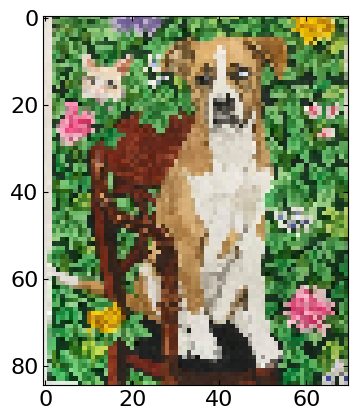

In [6]:
# Plots dog image
plt.imshow(image)


## Generating some data based on the image

### Define a non-linear function


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/generated.png?raw=true)


In [7]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [8]:
print_code(generate_data)

24: def generate_data(values, function=default_nl_function, length=25, range_=[-1, 1]):
25:   """function to generate data based on an arbitrary function
26: 
27:   Args:
28:       values (array): Input values to use
29:       function (obj, optional): Function to use for generation. Defaults to default_nl_function.
30:       length (int, optional): length of the vector to generate. Defaults to 25.
31:       range_ (list, optional): range of spectra where you generate data. Defaults to [-1, 1].
32: 
33:   Returns:
34:       array: computed spectra
35:   """
36:   # build x vector
37:   x = np.linspace(range_[0], range_[1], length)
38: 
39:   data = np.zeros((values.shape[0], length))
40: 
41:   for i in range(values.shape[0]):
42:       data[i, :] = function(x, values[i, 0], values[i, 1], values[i, 2])
43: 
44:   return data
45: 


In [9]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3),
                         length=10, function=non_linear_fn)


In [10]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


## Plots the generated data


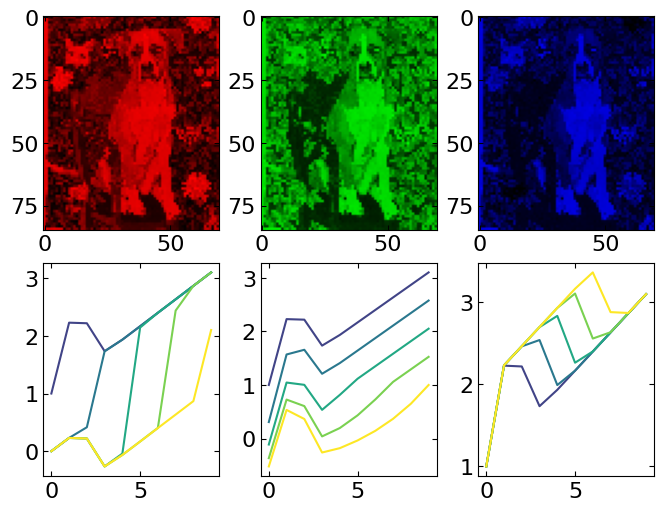

In [11]:
fig, ax = layout_fig(6, mod=3, figsize=(10, 5))

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    # for the first three plots we plot the image
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        # for the last three plots we plot the hyperspectral image
        values = np.zeros((5, 3))
        
        # generates 5 linearly spaced values between 0 and 1
        values[:, i - 3] = np.linspace(0, 1, 5)
        
        # generates the spectra 
        y_data = generate_data(values, length=10)
        
        for j in range(y_data.shape[0]):
            
            # computes the colormap for each spectra based on the value
            color = cmap((j + 1) / y_data.shape[0])
            
            # plots the data
            ax.plot(y_data[j], c=color)


## Building a Simple Autoencoder


### Defines the encoder and the decoder


In [12]:
# sets the number of latent dimensions for the autoencoder
latent_dim = 12


class Encoder(nn.Module):
    """Encoder class for the autoencoder"""
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    """Decoder class for the autoencoder"""
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


### Builds the autoencoder


In [13]:
class Autoencoder(nn.Module):
    """
    Autoencoder class that combines the encoder and decoder
    """
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


### Instantiates the model


In [14]:
import cpuinfo

cpudata = cpuinfo.get_cpu_info()["brand_raw"]
cpuname = cpudata.split(" ")[1]

# choose a device based on your system 
if cpuname == "M1":
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else:
    device = "cpu"

print(f"You are running on a {device}")

# builds the encode, decoder, and autoencoder
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


You are running on a cuda


In [15]:
# prints the model structure

try:
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to("cpu")
    summary(model_cpu, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 12 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


### Builds the dataloader


In [16]:

# builds a dataloader
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


### Trains the model


In [17]:
print_code(Train)

201: def Train(
202:     model,
203:     encoder,
204:     decoder,
205:     train_iterator,
206:     optimizer,
207:     epochs,
208:     coef=0,
209:     coef_1=0,
210:     ln_parm=1,
211:     beta=None,
212:     mse=True,
213:     device="cuda",
214:     save_weight = False,
215: ):
216:     """Function that trains the model
217: 
218:     Args:
219:         model (Pytorch model): autoencoder model
220:         encoder (PyTorch model): encoder of the mode
221:         decoder (PyTorch model): decoder of the model
222:         train_iterator (iter): iterator used from straining
223:         optimizer (obj): optimization methods used
224:         epochs (int): number of epochs
225:         coef (int, optional): used to set the lambda value of the regularization. Defaults to 0.
226:         coef1 (int, optional): not implemented. Defaults to 0.
227:         ln_parm (int, optional): norm value. Defaults to 1.
228:         beta (float, optional): beta for variational autoencoder. Default

In [18]:
# fixes the seed
random_seed(seed=42)

# trains the model
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 192.01it/s]


Epoch 0, Train Loss: 2.0557
.............................


100%|██████████| 19/19 [00:00<00:00, 177.25it/s]


Epoch 1, Train Loss: 1.8709
.............................


100%|██████████| 19/19 [00:00<00:00, 139.72it/s]


Epoch 2, Train Loss: 1.7014
.............................


100%|██████████| 19/19 [00:00<00:00, 155.00it/s]


Epoch 3, Train Loss: 1.5465
.............................


100%|██████████| 19/19 [00:00<00:00, 163.54it/s]


Epoch 4, Train Loss: 1.3983
.............................


100%|██████████| 19/19 [00:00<00:00, 194.47it/s]


Epoch 5, Train Loss: 1.2586
.............................


100%|██████████| 19/19 [00:00<00:00, 204.64it/s]


Epoch 6, Train Loss: 1.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 215.71it/s]


Epoch 7, Train Loss: 1.0058
.............................


100%|██████████| 19/19 [00:00<00:00, 229.61it/s]


Epoch 8, Train Loss: 0.8919
.............................


100%|██████████| 19/19 [00:00<00:00, 239.56it/s]


Epoch 9, Train Loss: 0.7870
.............................


100%|██████████| 19/19 [00:00<00:00, 236.56it/s]


Epoch 10, Train Loss: 0.6910
.............................


100%|██████████| 19/19 [00:00<00:00, 238.65it/s]


Epoch 11, Train Loss: 0.6044
.............................


100%|██████████| 19/19 [00:00<00:00, 220.84it/s]


Epoch 12, Train Loss: 0.5278
.............................


100%|██████████| 19/19 [00:00<00:00, 222.15it/s]


Epoch 13, Train Loss: 0.4611
.............................


100%|██████████| 19/19 [00:00<00:00, 224.19it/s]


Epoch 14, Train Loss: 0.4038
.............................


100%|██████████| 19/19 [00:00<00:00, 245.12it/s]


Epoch 15, Train Loss: 0.3553
.............................


100%|██████████| 19/19 [00:00<00:00, 262.09it/s]


Epoch 16, Train Loss: 0.3155
.............................


100%|██████████| 19/19 [00:00<00:00, 281.10it/s]


Epoch 17, Train Loss: 0.2828
.............................


100%|██████████| 19/19 [00:00<00:00, 279.85it/s]


Epoch 18, Train Loss: 0.2565
.............................


100%|██████████| 19/19 [00:00<00:00, 253.41it/s]


Epoch 19, Train Loss: 0.2355
.............................


100%|██████████| 19/19 [00:00<00:00, 271.48it/s]


Epoch 20, Train Loss: 0.2191
.............................


100%|██████████| 19/19 [00:00<00:00, 278.64it/s]


Epoch 21, Train Loss: 0.2055
.............................


100%|██████████| 19/19 [00:00<00:00, 281.28it/s]


Epoch 22, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 253.69it/s]


Epoch 23, Train Loss: 0.1857
.............................


100%|██████████| 19/19 [00:00<00:00, 243.19it/s]


Epoch 24, Train Loss: 0.1780
.............................


100%|██████████| 19/19 [00:00<00:00, 226.45it/s]


Epoch 25, Train Loss: 0.1714
.............................


100%|██████████| 19/19 [00:00<00:00, 237.58it/s]


Epoch 26, Train Loss: 0.1664
.............................


100%|██████████| 19/19 [00:00<00:00, 239.36it/s]


Epoch 27, Train Loss: 0.1614
.............................


100%|██████████| 19/19 [00:00<00:00, 267.73it/s]


Epoch 28, Train Loss: 0.1573
.............................


100%|██████████| 19/19 [00:00<00:00, 287.57it/s]


Epoch 29, Train Loss: 0.1535
.............................


100%|██████████| 19/19 [00:00<00:00, 259.67it/s]


Epoch 30, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 280.30it/s]


Epoch 31, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 260.75it/s]


Epoch 32, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 268.25it/s]


Epoch 33, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 249.67it/s]


Epoch 34, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 257.12it/s]


Epoch 35, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 244.97it/s]


Epoch 36, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 242.00it/s]


Epoch 37, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 223.02it/s]


Epoch 38, Train Loss: 0.1291
.............................


100%|██████████| 19/19 [00:00<00:00, 214.55it/s]


Epoch 39, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 235.43it/s]


Epoch 40, Train Loss: 0.1245
.............................


100%|██████████| 19/19 [00:00<00:00, 236.91it/s]


Epoch 41, Train Loss: 0.1225
.............................


100%|██████████| 19/19 [00:00<00:00, 287.32it/s]


Epoch 42, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 287.24it/s]


Epoch 43, Train Loss: 0.1181
.............................


100%|██████████| 19/19 [00:00<00:00, 280.61it/s]


Epoch 44, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 298.97it/s]


Epoch 45, Train Loss: 0.1140
.............................


100%|██████████| 19/19 [00:00<00:00, 287.30it/s]


Epoch 46, Train Loss: 0.1121
.............................


100%|██████████| 19/19 [00:00<00:00, 312.01it/s]


Epoch 47, Train Loss: 0.1099
.............................


100%|██████████| 19/19 [00:00<00:00, 310.81it/s]


Epoch 48, Train Loss: 0.1081
.............................


100%|██████████| 19/19 [00:00<00:00, 314.88it/s]


Epoch 49, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 322.79it/s]


Epoch 50, Train Loss: 0.1044
.............................


100%|██████████| 19/19 [00:00<00:00, 304.33it/s]


Epoch 51, Train Loss: 0.1024
.............................


100%|██████████| 19/19 [00:00<00:00, 269.17it/s]


Epoch 52, Train Loss: 0.1005
.............................


100%|██████████| 19/19 [00:00<00:00, 270.42it/s]


Epoch 53, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 272.95it/s]


Epoch 54, Train Loss: 0.0969
.............................


100%|██████████| 19/19 [00:00<00:00, 259.72it/s]


Epoch 55, Train Loss: 0.0949
.............................


100%|██████████| 19/19 [00:00<00:00, 277.27it/s]


Epoch 56, Train Loss: 0.0933
.............................


100%|██████████| 19/19 [00:00<00:00, 275.40it/s]


Epoch 57, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 294.18it/s]


Epoch 58, Train Loss: 0.0897
.............................


100%|██████████| 19/19 [00:00<00:00, 299.88it/s]


Epoch 59, Train Loss: 0.0880
.............................


100%|██████████| 19/19 [00:00<00:00, 288.19it/s]


Epoch 60, Train Loss: 0.0863
.............................


100%|██████████| 19/19 [00:00<00:00, 306.41it/s]


Epoch 61, Train Loss: 0.0847
.............................


100%|██████████| 19/19 [00:00<00:00, 311.60it/s]


Epoch 62, Train Loss: 0.0831
.............................


100%|██████████| 19/19 [00:00<00:00, 332.55it/s]


Epoch 63, Train Loss: 0.0816
.............................


100%|██████████| 19/19 [00:00<00:00, 320.83it/s]


Epoch 64, Train Loss: 0.0801
.............................


100%|██████████| 19/19 [00:00<00:00, 296.16it/s]


Epoch 65, Train Loss: 0.0784
.............................


100%|██████████| 19/19 [00:00<00:00, 287.46it/s]


Epoch 66, Train Loss: 0.0771
.............................


100%|██████████| 19/19 [00:00<00:00, 243.49it/s]


Epoch 67, Train Loss: 0.0755
.............................


100%|██████████| 19/19 [00:00<00:00, 269.28it/s]


Epoch 68, Train Loss: 0.0743
.............................


100%|██████████| 19/19 [00:00<00:00, 257.00it/s]


Epoch 69, Train Loss: 0.0727
.............................


100%|██████████| 19/19 [00:00<00:00, 318.64it/s]


Epoch 70, Train Loss: 0.0713
.............................


100%|██████████| 19/19 [00:00<00:00, 317.09it/s]


Epoch 71, Train Loss: 0.0701
.............................


100%|██████████| 19/19 [00:00<00:00, 351.75it/s]


Epoch 72, Train Loss: 0.0689
.............................


100%|██████████| 19/19 [00:00<00:00, 294.07it/s]


Epoch 73, Train Loss: 0.0676
.............................


100%|██████████| 19/19 [00:00<00:00, 345.36it/s]


Epoch 74, Train Loss: 0.0664
.............................


100%|██████████| 19/19 [00:00<00:00, 293.19it/s]


Epoch 75, Train Loss: 0.0651
.............................


100%|██████████| 19/19 [00:00<00:00, 349.66it/s]


Epoch 76, Train Loss: 0.0639
.............................


100%|██████████| 19/19 [00:00<00:00, 328.87it/s]


Epoch 77, Train Loss: 0.0628
.............................


100%|██████████| 19/19 [00:00<00:00, 351.59it/s]


Epoch 78, Train Loss: 0.0618
.............................


100%|██████████| 19/19 [00:00<00:00, 327.03it/s]


Epoch 79, Train Loss: 0.0607
.............................


100%|██████████| 19/19 [00:00<00:00, 286.40it/s]


Epoch 80, Train Loss: 0.0597
.............................


100%|██████████| 19/19 [00:00<00:00, 293.42it/s]


Epoch 81, Train Loss: 0.0586
.............................


100%|██████████| 19/19 [00:00<00:00, 284.66it/s]


Epoch 82, Train Loss: 0.0577
.............................


100%|██████████| 19/19 [00:00<00:00, 287.88it/s]


Epoch 83, Train Loss: 0.0568
.............................


100%|██████████| 19/19 [00:00<00:00, 289.26it/s]


Epoch 84, Train Loss: 0.0558
.............................


100%|██████████| 19/19 [00:00<00:00, 313.12it/s]


Epoch 85, Train Loss: 0.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 357.71it/s]


Epoch 86, Train Loss: 0.0539
.............................


100%|██████████| 19/19 [00:00<00:00, 299.77it/s]


Epoch 87, Train Loss: 0.0531
.............................


100%|██████████| 19/19 [00:00<00:00, 312.01it/s]


Epoch 88, Train Loss: 0.0524
.............................


100%|██████████| 19/19 [00:00<00:00, 258.07it/s]


Epoch 89, Train Loss: 0.0515
.............................


100%|██████████| 19/19 [00:00<00:00, 286.12it/s]


Epoch 90, Train Loss: 0.0507
.............................


100%|██████████| 19/19 [00:00<00:00, 283.67it/s]


Epoch 91, Train Loss: 0.0500
.............................


100%|██████████| 19/19 [00:00<00:00, 300.66it/s]


Epoch 92, Train Loss: 0.0492
.............................


100%|██████████| 19/19 [00:00<00:00, 300.98it/s]


Epoch 93, Train Loss: 0.0484
.............................


100%|██████████| 19/19 [00:00<00:00, 200.78it/s]


Epoch 94, Train Loss: 0.0477
.............................


100%|██████████| 19/19 [00:00<00:00, 261.14it/s]


Epoch 95, Train Loss: 0.0470
.............................


100%|██████████| 19/19 [00:00<00:00, 254.33it/s]


Epoch 96, Train Loss: 0.0463
.............................


100%|██████████| 19/19 [00:00<00:00, 231.07it/s]


Epoch 97, Train Loss: 0.0457
.............................


100%|██████████| 19/19 [00:00<00:00, 269.60it/s]


Epoch 98, Train Loss: 0.0451
.............................


100%|██████████| 19/19 [00:00<00:00, 248.60it/s]


Epoch 99, Train Loss: 0.0445
.............................


100%|██████████| 19/19 [00:00<00:00, 243.45it/s]


Epoch 100, Train Loss: 0.0437
.............................


100%|██████████| 19/19 [00:00<00:00, 279.24it/s]


Epoch 101, Train Loss: 0.0431
.............................


100%|██████████| 19/19 [00:00<00:00, 254.14it/s]


Epoch 102, Train Loss: 0.0425
.............................


100%|██████████| 19/19 [00:00<00:00, 274.76it/s]


Epoch 103, Train Loss: 0.0420
.............................


100%|██████████| 19/19 [00:00<00:00, 237.80it/s]


Epoch 104, Train Loss: 0.0415
.............................


100%|██████████| 19/19 [00:00<00:00, 260.97it/s]


Epoch 105, Train Loss: 0.0409
.............................


100%|██████████| 19/19 [00:00<00:00, 257.19it/s]


Epoch 106, Train Loss: 0.0403
.............................


100%|██████████| 19/19 [00:00<00:00, 252.05it/s]


Epoch 107, Train Loss: 0.0397
.............................


100%|██████████| 19/19 [00:00<00:00, 238.39it/s]


Epoch 108, Train Loss: 0.0392
.............................


100%|██████████| 19/19 [00:00<00:00, 229.99it/s]


Epoch 109, Train Loss: 0.0388
.............................


100%|██████████| 19/19 [00:00<00:00, 232.71it/s]


Epoch 110, Train Loss: 0.0382
.............................


100%|██████████| 19/19 [00:00<00:00, 241.02it/s]


Epoch 111, Train Loss: 0.0378
.............................


100%|██████████| 19/19 [00:00<00:00, 255.75it/s]


Epoch 112, Train Loss: 0.0373
.............................


100%|██████████| 19/19 [00:00<00:00, 277.68it/s]


Epoch 113, Train Loss: 0.0369
.............................


100%|██████████| 19/19 [00:00<00:00, 296.29it/s]


Epoch 114, Train Loss: 0.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 295.73it/s]


Epoch 115, Train Loss: 0.0359
.............................


100%|██████████| 19/19 [00:00<00:00, 306.25it/s]


Epoch 116, Train Loss: 0.0354
.............................


100%|██████████| 19/19 [00:00<00:00, 308.52it/s]


Epoch 117, Train Loss: 0.0350
.............................


100%|██████████| 19/19 [00:00<00:00, 293.90it/s]


Epoch 118, Train Loss: 0.0346
.............................


100%|██████████| 19/19 [00:00<00:00, 314.78it/s]


Epoch 119, Train Loss: 0.0341
.............................


100%|██████████| 19/19 [00:00<00:00, 354.97it/s]


Epoch 120, Train Loss: 0.0338
.............................


100%|██████████| 19/19 [00:00<00:00, 307.17it/s]


Epoch 121, Train Loss: 0.0333
.............................


100%|██████████| 19/19 [00:00<00:00, 264.40it/s]


Epoch 122, Train Loss: 0.0330
.............................


100%|██████████| 19/19 [00:00<00:00, 268.33it/s]


Epoch 123, Train Loss: 0.0326
.............................


100%|██████████| 19/19 [00:00<00:00, 279.55it/s]


Epoch 124, Train Loss: 0.0321
.............................


100%|██████████| 19/19 [00:00<00:00, 256.05it/s]


Epoch 125, Train Loss: 0.0318
.............................


100%|██████████| 19/19 [00:00<00:00, 246.08it/s]


Epoch 126, Train Loss: 0.0314
.............................


100%|██████████| 19/19 [00:00<00:00, 240.51it/s]


Epoch 127, Train Loss: 0.0311
.............................


100%|██████████| 19/19 [00:00<00:00, 239.84it/s]


Epoch 128, Train Loss: 0.0307
.............................


100%|██████████| 19/19 [00:00<00:00, 288.95it/s]


Epoch 129, Train Loss: 0.0304
.............................


100%|██████████| 19/19 [00:00<00:00, 287.23it/s]


Epoch 130, Train Loss: 0.0300
.............................


100%|██████████| 19/19 [00:00<00:00, 296.00it/s]


Epoch 131, Train Loss: 0.0297
.............................


100%|██████████| 19/19 [00:00<00:00, 295.12it/s]


Epoch 132, Train Loss: 0.0294
.............................


100%|██████████| 19/19 [00:00<00:00, 281.03it/s]


Epoch 133, Train Loss: 0.0290
.............................


100%|██████████| 19/19 [00:00<00:00, 263.25it/s]


Epoch 134, Train Loss: 0.0287
.............................


100%|██████████| 19/19 [00:00<00:00, 248.43it/s]


Epoch 135, Train Loss: 0.0283
.............................


100%|██████████| 19/19 [00:00<00:00, 254.66it/s]


Epoch 136, Train Loss: 0.0280
.............................


100%|██████████| 19/19 [00:00<00:00, 273.70it/s]


Epoch 137, Train Loss: 0.0278
.............................


100%|██████████| 19/19 [00:00<00:00, 253.24it/s]


Epoch 138, Train Loss: 0.0274
.............................


100%|██████████| 19/19 [00:00<00:00, 290.51it/s]


Epoch 139, Train Loss: 0.0271
.............................


100%|██████████| 19/19 [00:00<00:00, 280.83it/s]


Epoch 140, Train Loss: 0.0268
.............................


100%|██████████| 19/19 [00:00<00:00, 244.33it/s]


Epoch 141, Train Loss: 0.0266
.............................


100%|██████████| 19/19 [00:00<00:00, 278.15it/s]


Epoch 142, Train Loss: 0.0262
.............................


100%|██████████| 19/19 [00:00<00:00, 276.45it/s]


Epoch 143, Train Loss: 0.0259
.............................


100%|██████████| 19/19 [00:00<00:00, 278.25it/s]


Epoch 144, Train Loss: 0.0257
.............................


100%|██████████| 19/19 [00:00<00:00, 168.81it/s]


Epoch 145, Train Loss: 0.0254
.............................


100%|██████████| 19/19 [00:00<00:00, 145.02it/s]


Epoch 146, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 168.89it/s]


Epoch 147, Train Loss: 0.0250
.............................


100%|██████████| 19/19 [00:00<00:00, 201.56it/s]


Epoch 148, Train Loss: 0.0246
.............................


100%|██████████| 19/19 [00:00<00:00, 211.40it/s]


Epoch 149, Train Loss: 0.0245
.............................


100%|██████████| 19/19 [00:00<00:00, 217.27it/s]


Epoch 150, Train Loss: 0.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 208.17it/s]


Epoch 151, Train Loss: 0.0239
.............................


100%|██████████| 19/19 [00:00<00:00, 152.93it/s]


Epoch 152, Train Loss: 0.0237
.............................


100%|██████████| 19/19 [00:00<00:00, 131.37it/s]


Epoch 153, Train Loss: 0.0234
.............................


100%|██████████| 19/19 [00:00<00:00, 111.90it/s]


Epoch 154, Train Loss: 0.0232
.............................


100%|██████████| 19/19 [00:00<00:00, 65.08it/s]


Epoch 155, Train Loss: 0.0230
.............................


100%|██████████| 19/19 [00:00<00:00, 58.40it/s]


Epoch 156, Train Loss: 0.0227
.............................


100%|██████████| 19/19 [00:00<00:00, 38.78it/s]


Epoch 157, Train Loss: 0.0225
.............................


100%|██████████| 19/19 [00:00<00:00, 53.24it/s]


Epoch 158, Train Loss: 0.0224
.............................


100%|██████████| 19/19 [00:00<00:00, 50.67it/s]


Epoch 159, Train Loss: 0.0220
.............................


100%|██████████| 19/19 [00:00<00:00, 51.89it/s]


Epoch 160, Train Loss: 0.0218
.............................


100%|██████████| 19/19 [00:00<00:00, 59.71it/s]


Epoch 161, Train Loss: 0.0217
.............................


100%|██████████| 19/19 [00:00<00:00, 78.16it/s]


Epoch 162, Train Loss: 0.0215
.............................


100%|██████████| 19/19 [00:00<00:00, 91.03it/s]


Epoch 163, Train Loss: 0.0212
.............................


100%|██████████| 19/19 [00:00<00:00, 71.86it/s]


Epoch 164, Train Loss: 0.0211
.............................


100%|██████████| 19/19 [00:00<00:00, 48.53it/s]


Epoch 165, Train Loss: 0.0208
.............................


100%|██████████| 19/19 [00:00<00:00, 50.27it/s]


Epoch 166, Train Loss: 0.0207
.............................


100%|██████████| 19/19 [00:00<00:00, 56.50it/s]


Epoch 167, Train Loss: 0.0204
.............................


100%|██████████| 19/19 [00:00<00:00, 55.85it/s]


Epoch 168, Train Loss: 0.0202
.............................


100%|██████████| 19/19 [00:00<00:00, 104.92it/s]


Epoch 169, Train Loss: 0.0201
.............................


100%|██████████| 19/19 [00:00<00:00, 144.23it/s]


Epoch 170, Train Loss: 0.0199
.............................


100%|██████████| 19/19 [00:00<00:00, 172.17it/s]


Epoch 171, Train Loss: 0.0197
.............................


100%|██████████| 19/19 [00:00<00:00, 203.95it/s]


Epoch 172, Train Loss: 0.0195
.............................


100%|██████████| 19/19 [00:00<00:00, 111.94it/s]


Epoch 173, Train Loss: 0.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 121.98it/s]


Epoch 174, Train Loss: 0.0192
.............................


100%|██████████| 19/19 [00:00<00:00, 57.63it/s]


Epoch 175, Train Loss: 0.0190
.............................


100%|██████████| 19/19 [00:00<00:00, 50.94it/s]


Epoch 176, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 48.74it/s]


Epoch 177, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 66.74it/s]


Epoch 178, Train Loss: 0.0185
.............................


100%|██████████| 19/19 [00:00<00:00, 96.17it/s]


Epoch 179, Train Loss: 0.0182
.............................


100%|██████████| 19/19 [00:00<00:00, 87.94it/s]


Epoch 180, Train Loss: 0.0181
.............................


100%|██████████| 19/19 [00:00<00:00, 66.30it/s]


Epoch 181, Train Loss: 0.0179
.............................


100%|██████████| 19/19 [00:00<00:00, 53.34it/s]


Epoch 182, Train Loss: 0.0178
.............................


100%|██████████| 19/19 [00:00<00:00, 73.66it/s]


Epoch 183, Train Loss: 0.0176
.............................


100%|██████████| 19/19 [00:00<00:00, 135.48it/s]


Epoch 184, Train Loss: 0.0174
.............................


100%|██████████| 19/19 [00:00<00:00, 150.48it/s]


Epoch 185, Train Loss: 0.0173
.............................


100%|██████████| 19/19 [00:00<00:00, 169.16it/s]


Epoch 186, Train Loss: 0.0171
.............................


100%|██████████| 19/19 [00:00<00:00, 200.99it/s]


Epoch 187, Train Loss: 0.0169
.............................


100%|██████████| 19/19 [00:00<00:00, 180.00it/s]


Epoch 188, Train Loss: 0.0168
.............................


100%|██████████| 19/19 [00:00<00:00, 194.91it/s]


Epoch 189, Train Loss: 0.0166
.............................


100%|██████████| 19/19 [00:00<00:00, 220.68it/s]


Epoch 190, Train Loss: 0.0165
.............................


100%|██████████| 19/19 [00:00<00:00, 236.10it/s]


Epoch 191, Train Loss: 0.0164
.............................


100%|██████████| 19/19 [00:00<00:00, 258.53it/s]


Epoch 192, Train Loss: 0.0162
.............................


100%|██████████| 19/19 [00:00<00:00, 240.31it/s]


Epoch 193, Train Loss: 0.0161
.............................


100%|██████████| 19/19 [00:00<00:00, 257.42it/s]


Epoch 194, Train Loss: 0.0159
.............................


100%|██████████| 19/19 [00:00<00:00, 262.46it/s]


Epoch 195, Train Loss: 0.0158
.............................


100%|██████████| 19/19 [00:00<00:00, 261.42it/s]


Epoch 196, Train Loss: 0.0156
.............................


100%|██████████| 19/19 [00:00<00:00, 181.19it/s]


Epoch 197, Train Loss: 0.0155
.............................


100%|██████████| 19/19 [00:00<00:00, 146.83it/s]


Epoch 198, Train Loss: 0.0153
.............................


100%|██████████| 19/19 [00:00<00:00, 129.43it/s]


Epoch 199, Train Loss: 0.0152
.............................


100%|██████████| 19/19 [00:00<00:00, 138.57it/s]


Epoch 200, Train Loss: 0.0150
.............................


100%|██████████| 19/19 [00:00<00:00, 159.02it/s]


Epoch 201, Train Loss: 0.0148
.............................


100%|██████████| 19/19 [00:00<00:00, 159.63it/s]


Epoch 202, Train Loss: 0.0147
.............................


100%|██████████| 19/19 [00:00<00:00, 161.55it/s]


Epoch 203, Train Loss: 0.0145
.............................


100%|██████████| 19/19 [00:00<00:00, 181.00it/s]


Epoch 204, Train Loss: 0.0144
.............................


100%|██████████| 19/19 [00:00<00:00, 184.04it/s]


Epoch 205, Train Loss: 0.0143
.............................


100%|██████████| 19/19 [00:00<00:00, 184.06it/s]


Epoch 206, Train Loss: 0.0141
.............................


100%|██████████| 19/19 [00:00<00:00, 172.28it/s]


Epoch 207, Train Loss: 0.0139
.............................


100%|██████████| 19/19 [00:00<00:00, 170.78it/s]


Epoch 208, Train Loss: 0.0138
.............................


100%|██████████| 19/19 [00:00<00:00, 211.83it/s]


Epoch 209, Train Loss: 0.0136
.............................


100%|██████████| 19/19 [00:00<00:00, 146.43it/s]


Epoch 210, Train Loss: 0.0135
.............................


100%|██████████| 19/19 [00:00<00:00, 140.64it/s]


Epoch 211, Train Loss: 0.0134
.............................


100%|██████████| 19/19 [00:00<00:00, 146.76it/s]


Epoch 212, Train Loss: 0.0133
.............................


100%|██████████| 19/19 [00:00<00:00, 165.77it/s]


Epoch 213, Train Loss: 0.0131
.............................


100%|██████████| 19/19 [00:00<00:00, 178.57it/s]


Epoch 214, Train Loss: 0.0129
.............................


100%|██████████| 19/19 [00:00<00:00, 184.65it/s]


Epoch 215, Train Loss: 0.0128
.............................


100%|██████████| 19/19 [00:00<00:00, 192.72it/s]


Epoch 216, Train Loss: 0.0127
.............................


100%|██████████| 19/19 [00:00<00:00, 208.53it/s]


Epoch 217, Train Loss: 0.0125
.............................


100%|██████████| 19/19 [00:00<00:00, 198.04it/s]


Epoch 218, Train Loss: 0.0123
.............................


100%|██████████| 19/19 [00:00<00:00, 202.86it/s]


Epoch 219, Train Loss: 0.0122
.............................


100%|██████████| 19/19 [00:00<00:00, 227.64it/s]


Epoch 220, Train Loss: 0.0120
.............................


100%|██████████| 19/19 [00:00<00:00, 234.74it/s]


Epoch 221, Train Loss: 0.0119
.............................


100%|██████████| 19/19 [00:00<00:00, 235.16it/s]


Epoch 222, Train Loss: 0.0118
.............................


100%|██████████| 19/19 [00:00<00:00, 244.29it/s]


Epoch 223, Train Loss: 0.0116
.............................


100%|██████████| 19/19 [00:00<00:00, 254.65it/s]


Epoch 224, Train Loss: 0.0115
.............................


100%|██████████| 19/19 [00:00<00:00, 209.23it/s]


Epoch 225, Train Loss: 0.0114
.............................


100%|██████████| 19/19 [00:00<00:00, 219.21it/s]


Epoch 226, Train Loss: 0.0112
.............................


100%|██████████| 19/19 [00:00<00:00, 209.36it/s]


Epoch 227, Train Loss: 0.0110
.............................


100%|██████████| 19/19 [00:00<00:00, 248.81it/s]


Epoch 228, Train Loss: 0.0109
.............................


100%|██████████| 19/19 [00:00<00:00, 222.13it/s]


Epoch 229, Train Loss: 0.0108
.............................


100%|██████████| 19/19 [00:00<00:00, 271.99it/s]


Epoch 230, Train Loss: 0.0106
.............................


100%|██████████| 19/19 [00:00<00:00, 265.98it/s]


Epoch 231, Train Loss: 0.0105
.............................


100%|██████████| 19/19 [00:00<00:00, 237.31it/s]


Epoch 232, Train Loss: 0.0104
.............................


100%|██████████| 19/19 [00:00<00:00, 248.86it/s]


Epoch 233, Train Loss: 0.0102
.............................


100%|██████████| 19/19 [00:00<00:00, 256.87it/s]


Epoch 234, Train Loss: 0.0101
.............................


100%|██████████| 19/19 [00:00<00:00, 204.59it/s]


Epoch 235, Train Loss: 0.0099
.............................


100%|██████████| 19/19 [00:00<00:00, 206.75it/s]


Epoch 236, Train Loss: 0.0098
.............................


100%|██████████| 19/19 [00:00<00:00, 213.02it/s]


Epoch 237, Train Loss: 0.0096
.............................


100%|██████████| 19/19 [00:00<00:00, 205.31it/s]


Epoch 238, Train Loss: 0.0096
.............................


100%|██████████| 19/19 [00:00<00:00, 234.41it/s]


Epoch 239, Train Loss: 0.0094
.............................


100%|██████████| 19/19 [00:00<00:00, 240.48it/s]


Epoch 240, Train Loss: 0.0093
.............................


100%|██████████| 19/19 [00:00<00:00, 274.41it/s]


Epoch 241, Train Loss: 0.0092
.............................


100%|██████████| 19/19 [00:00<00:00, 251.08it/s]


Epoch 242, Train Loss: 0.0090
.............................


100%|██████████| 19/19 [00:00<00:00, 249.76it/s]


Epoch 243, Train Loss: 0.0088
.............................


100%|██████████| 19/19 [00:00<00:00, 268.99it/s]


Epoch 244, Train Loss: 0.0087
.............................


100%|██████████| 19/19 [00:00<00:00, 264.37it/s]


Epoch 245, Train Loss: 0.0086
.............................


100%|██████████| 19/19 [00:00<00:00, 277.62it/s]


Epoch 246, Train Loss: 0.0084
.............................


100%|██████████| 19/19 [00:00<00:00, 290.53it/s]


Epoch 247, Train Loss: 0.0083
.............................


100%|██████████| 19/19 [00:00<00:00, 272.89it/s]


Epoch 248, Train Loss: 0.0082
.............................


100%|██████████| 19/19 [00:00<00:00, 313.47it/s]


Epoch 249, Train Loss: 0.0080
.............................


100%|██████████| 19/19 [00:00<00:00, 284.34it/s]


Epoch 250, Train Loss: 0.0079
.............................


100%|██████████| 19/19 [00:00<00:00, 294.35it/s]


Epoch 251, Train Loss: 0.0078
.............................


100%|██████████| 19/19 [00:00<00:00, 272.51it/s]


Epoch 252, Train Loss: 0.0077
.............................


100%|██████████| 19/19 [00:00<00:00, 268.30it/s]


Epoch 253, Train Loss: 0.0075
.............................


100%|██████████| 19/19 [00:00<00:00, 287.59it/s]


Epoch 254, Train Loss: 0.0074
.............................


100%|██████████| 19/19 [00:00<00:00, 259.68it/s]


Epoch 255, Train Loss: 0.0073
.............................


100%|██████████| 19/19 [00:00<00:00, 237.13it/s]


Epoch 256, Train Loss: 0.0071
.............................


100%|██████████| 19/19 [00:00<00:00, 238.43it/s]


Epoch 257, Train Loss: 0.0070
.............................


100%|██████████| 19/19 [00:00<00:00, 237.59it/s]


Epoch 258, Train Loss: 0.0069
.............................


100%|██████████| 19/19 [00:00<00:00, 219.25it/s]


Epoch 259, Train Loss: 0.0067
.............................


100%|██████████| 19/19 [00:00<00:00, 211.56it/s]


Epoch 260, Train Loss: 0.0066
.............................


100%|██████████| 19/19 [00:00<00:00, 220.51it/s]


Epoch 261, Train Loss: 0.0065
.............................


100%|██████████| 19/19 [00:00<00:00, 200.52it/s]


Epoch 262, Train Loss: 0.0064
.............................


100%|██████████| 19/19 [00:00<00:00, 206.39it/s]


Epoch 263, Train Loss: 0.0062
.............................


100%|██████████| 19/19 [00:00<00:00, 219.03it/s]


Epoch 264, Train Loss: 0.0061
.............................


100%|██████████| 19/19 [00:00<00:00, 230.29it/s]


Epoch 265, Train Loss: 0.0060
.............................


100%|██████████| 19/19 [00:00<00:00, 249.26it/s]


Epoch 266, Train Loss: 0.0059
.............................


100%|██████████| 19/19 [00:00<00:00, 222.65it/s]


Epoch 267, Train Loss: 0.0057
.............................


100%|██████████| 19/19 [00:00<00:00, 236.20it/s]


Epoch 268, Train Loss: 0.0056
.............................


100%|██████████| 19/19 [00:00<00:00, 249.60it/s]


Epoch 269, Train Loss: 0.0055
.............................


100%|██████████| 19/19 [00:00<00:00, 255.59it/s]


Epoch 270, Train Loss: 0.0054
.............................


100%|██████████| 19/19 [00:00<00:00, 284.72it/s]


Epoch 271, Train Loss: 0.0052
.............................


100%|██████████| 19/19 [00:00<00:00, 268.93it/s]


Epoch 272, Train Loss: 0.0052
.............................


100%|██████████| 19/19 [00:00<00:00, 271.27it/s]


Epoch 273, Train Loss: 0.0050
.............................


100%|██████████| 19/19 [00:00<00:00, 231.87it/s]


Epoch 274, Train Loss: 0.0049
.............................


100%|██████████| 19/19 [00:00<00:00, 174.05it/s]


Epoch 275, Train Loss: 0.0048
.............................


100%|██████████| 19/19 [00:00<00:00, 150.13it/s]


Epoch 276, Train Loss: 0.0047
.............................


100%|██████████| 19/19 [00:00<00:00, 204.34it/s]


Epoch 277, Train Loss: 0.0046
.............................


100%|██████████| 19/19 [00:00<00:00, 216.81it/s]


Epoch 278, Train Loss: 0.0045
.............................


100%|██████████| 19/19 [00:00<00:00, 214.52it/s]


Epoch 279, Train Loss: 0.0043
.............................


100%|██████████| 19/19 [00:00<00:00, 230.57it/s]


Epoch 280, Train Loss: 0.0042
.............................


100%|██████████| 19/19 [00:00<00:00, 244.89it/s]


Epoch 281, Train Loss: 0.0041
.............................


100%|██████████| 19/19 [00:00<00:00, 246.59it/s]


Epoch 282, Train Loss: 0.0040
.............................


100%|██████████| 19/19 [00:00<00:00, 241.82it/s]


Epoch 283, Train Loss: 0.0039
.............................


100%|██████████| 19/19 [00:00<00:00, 267.92it/s]


Epoch 284, Train Loss: 0.0038
.............................


100%|██████████| 19/19 [00:00<00:00, 216.96it/s]


Epoch 285, Train Loss: 0.0037
.............................


100%|██████████| 19/19 [00:00<00:00, 245.98it/s]


Epoch 286, Train Loss: 0.0036
.............................


100%|██████████| 19/19 [00:00<00:00, 236.91it/s]


Epoch 287, Train Loss: 0.0035
.............................


100%|██████████| 19/19 [00:00<00:00, 240.13it/s]


Epoch 288, Train Loss: 0.0034
.............................


100%|██████████| 19/19 [00:00<00:00, 246.23it/s]


Epoch 289, Train Loss: 0.0033
.............................


100%|██████████| 19/19 [00:00<00:00, 263.19it/s]


Epoch 290, Train Loss: 0.0032
.............................


100%|██████████| 19/19 [00:00<00:00, 259.79it/s]


Epoch 291, Train Loss: 0.0031
.............................


100%|██████████| 19/19 [00:00<00:00, 271.92it/s]


Epoch 292, Train Loss: 0.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 272.71it/s]


Epoch 293, Train Loss: 0.0029
.............................


100%|██████████| 19/19 [00:00<00:00, 288.67it/s]


Epoch 294, Train Loss: 0.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 257.82it/s]


Epoch 295, Train Loss: 0.0027
.............................


100%|██████████| 19/19 [00:00<00:00, 239.35it/s]


Epoch 296, Train Loss: 0.0026
.............................


100%|██████████| 19/19 [00:00<00:00, 251.49it/s]


Epoch 297, Train Loss: 0.0025
.............................


100%|██████████| 19/19 [00:00<00:00, 219.45it/s]


Epoch 298, Train Loss: 0.0024
.............................


100%|██████████| 19/19 [00:00<00:00, 194.69it/s]


Epoch 299, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 213.33it/s]


Epoch 300, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 241.34it/s]


Epoch 301, Train Loss: 0.0022
.............................


100%|██████████| 19/19 [00:00<00:00, 247.09it/s]


Epoch 302, Train Loss: 0.0021
.............................


100%|██████████| 19/19 [00:00<00:00, 265.98it/s]


Epoch 303, Train Loss: 0.0020
.............................


100%|██████████| 19/19 [00:00<00:00, 259.54it/s]


Epoch 304, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 259.80it/s]


Epoch 305, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 280.37it/s]


Epoch 306, Train Loss: 0.0018
.............................


100%|██████████| 19/19 [00:00<00:00, 242.99it/s]


Epoch 307, Train Loss: 0.0017
.............................


100%|██████████| 19/19 [00:00<00:00, 259.13it/s]


Epoch 308, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 297.03it/s]


Epoch 309, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 260.69it/s]


Epoch 310, Train Loss: 0.0015
.............................


100%|██████████| 19/19 [00:00<00:00, 231.15it/s]


Epoch 311, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 260.14it/s]


Epoch 312, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 193.42it/s]


Epoch 313, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 237.66it/s]


Epoch 314, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 249.45it/s]


Epoch 315, Train Loss: 0.0012
.............................


100%|██████████| 19/19 [00:00<00:00, 241.09it/s]


Epoch 316, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 266.04it/s]


Epoch 317, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 246.18it/s]


Epoch 318, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 241.42it/s]


Epoch 319, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 256.22it/s]


Epoch 320, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 253.33it/s]


Epoch 321, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 276.65it/s]


Epoch 322, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 232.74it/s]


Epoch 323, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 247.00it/s]


Epoch 324, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 268.35it/s]


Epoch 325, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 264.16it/s]


Epoch 326, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 237.38it/s]


Epoch 327, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 228.56it/s]


Epoch 328, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 243.77it/s]


Epoch 329, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 259.62it/s]


Epoch 330, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 251.54it/s]


Epoch 331, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 255.98it/s]


Epoch 332, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 271.72it/s]


Epoch 333, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 248.20it/s]


Epoch 334, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 250.78it/s]


Epoch 335, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 201.36it/s]


Epoch 336, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 226.61it/s]


Epoch 337, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 241.49it/s]


Epoch 338, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 229.83it/s]


Epoch 339, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 221.26it/s]


Epoch 340, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 255.41it/s]


Epoch 341, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 265.76it/s]


Epoch 342, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 242.38it/s]


Epoch 343, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 263.99it/s]


Epoch 344, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 271.54it/s]


Epoch 345, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 245.24it/s]


Epoch 346, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 243.52it/s]


Epoch 347, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 175.70it/s]


Epoch 348, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 211.70it/s]


Epoch 349, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 217.31it/s]


Epoch 350, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 226.11it/s]


Epoch 351, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 245.63it/s]


Epoch 352, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 261.93it/s]


Epoch 353, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 273.21it/s]


Epoch 354, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 283.04it/s]


Epoch 355, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 276.63it/s]


Epoch 356, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 285.42it/s]


Epoch 357, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 282.96it/s]


Epoch 358, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 290.20it/s]


Epoch 359, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 234.60it/s]


Epoch 360, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 261.71it/s]


Epoch 361, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 253.48it/s]


Epoch 362, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 244.26it/s]


Epoch 363, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 282.06it/s]


Epoch 364, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 302.88it/s]


Epoch 365, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 306.19it/s]


Epoch 366, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 294.54it/s]


Epoch 367, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 334.32it/s]


Epoch 368, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 332.24it/s]


Epoch 369, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 330.68it/s]


Epoch 370, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 348.89it/s]


Epoch 371, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 305.83it/s]


Epoch 372, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 332.12it/s]


Epoch 373, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 307.47it/s]


Epoch 374, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 299.50it/s]


Epoch 375, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 310.43it/s]


Epoch 376, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 285.44it/s]


Epoch 377, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 283.57it/s]


Epoch 378, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 171.98it/s]


Epoch 379, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 207.26it/s]


Epoch 380, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 203.59it/s]


Epoch 381, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 209.69it/s]


Epoch 382, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 213.33it/s]


Epoch 383, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 198.88it/s]


Epoch 384, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 201.85it/s]


Epoch 385, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 189.55it/s]


Epoch 386, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 222.78it/s]


Epoch 387, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 217.45it/s]


Epoch 388, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 226.10it/s]


Epoch 389, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 225.51it/s]


Epoch 390, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 198.01it/s]


Epoch 391, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 185.55it/s]


Epoch 392, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 244.33it/s]


Epoch 393, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 242.72it/s]


Epoch 394, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 234.90it/s]


Epoch 395, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 224.60it/s]


Epoch 396, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 220.36it/s]


Epoch 397, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 207.57it/s]


Epoch 398, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 215.99it/s]


Epoch 399, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 181.53it/s]


Epoch 400, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 203.20it/s]


Epoch 401, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 238.12it/s]


Epoch 402, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 223.14it/s]


Epoch 403, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 186.93it/s]


Epoch 404, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 234.76it/s]


Epoch 405, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 214.18it/s]


Epoch 406, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 207.98it/s]


Epoch 407, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 210.64it/s]


Epoch 408, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 243.86it/s]


Epoch 409, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 248.06it/s]


Epoch 410, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 269.39it/s]


Epoch 411, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 245.74it/s]


Epoch 412, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 237.74it/s]


Epoch 413, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 257.78it/s]


Epoch 414, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 258.46it/s]


Epoch 415, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 272.58it/s]


Epoch 416, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 250.97it/s]


Epoch 417, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 250.59it/s]


Epoch 418, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 238.71it/s]


Epoch 419, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 226.99it/s]


Epoch 420, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 251.66it/s]


Epoch 421, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 239.29it/s]


Epoch 422, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 217.13it/s]


Epoch 423, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 225.07it/s]


Epoch 424, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 214.21it/s]


Epoch 425, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 229.55it/s]


Epoch 426, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 253.03it/s]


Epoch 427, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 227.07it/s]


Epoch 428, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 263.31it/s]


Epoch 429, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 247.46it/s]


Epoch 430, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 241.64it/s]


Epoch 431, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 215.56it/s]


Epoch 432, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 180.94it/s]


Epoch 433, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 190.41it/s]


Epoch 434, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 196.75it/s]


Epoch 435, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 168.34it/s]


Epoch 436, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 188.79it/s]


Epoch 437, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 200.51it/s]


Epoch 438, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 207.01it/s]


Epoch 439, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 200.03it/s]


Epoch 440, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 191.15it/s]


Epoch 441, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 207.00it/s]


Epoch 442, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 235.06it/s]


Epoch 443, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 213.89it/s]


Epoch 444, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 237.01it/s]


Epoch 445, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 253.34it/s]


Epoch 446, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 271.06it/s]


Epoch 447, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 247.39it/s]


Epoch 448, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 264.64it/s]


Epoch 449, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 255.45it/s]


Epoch 450, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 275.51it/s]


Epoch 451, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 236.20it/s]


Epoch 452, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 205.03it/s]


Epoch 453, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 221.13it/s]


Epoch 454, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 201.97it/s]


Epoch 455, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 216.58it/s]


Epoch 456, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 235.36it/s]


Epoch 457, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 238.38it/s]


Epoch 458, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 234.33it/s]


Epoch 459, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 192.56it/s]


Epoch 460, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 243.08it/s]


Epoch 461, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 231.19it/s]


Epoch 462, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 234.68it/s]


Epoch 463, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 216.66it/s]


Epoch 464, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 225.53it/s]


Epoch 465, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 247.55it/s]


Epoch 466, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 259.87it/s]


Epoch 467, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 250.00it/s]


Epoch 468, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 244.17it/s]


Epoch 469, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 243.68it/s]


Epoch 470, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 265.31it/s]


Epoch 471, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 267.64it/s]


Epoch 472, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 251.04it/s]


Epoch 473, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 272.93it/s]


Epoch 474, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 276.36it/s]


Epoch 475, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 256.53it/s]


Epoch 476, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 237.09it/s]


Epoch 477, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 238.68it/s]


Epoch 478, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 250.48it/s]


Epoch 479, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 268.73it/s]


Epoch 480, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 275.41it/s]


Epoch 481, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 244.34it/s]


Epoch 482, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 257.83it/s]


Epoch 483, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 223.11it/s]


Epoch 484, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 198.90it/s]


Epoch 485, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 241.32it/s]


Epoch 486, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 240.49it/s]


Epoch 487, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 238.89it/s]


Epoch 488, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 217.46it/s]


Epoch 489, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 227.85it/s]


Epoch 490, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 223.45it/s]


Epoch 491, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 214.32it/s]


Epoch 492, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 214.17it/s]


Epoch 493, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 216.96it/s]


Epoch 494, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 227.07it/s]


Epoch 495, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 209.24it/s]


Epoch 496, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 221.78it/s]


Epoch 497, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 215.55it/s]


Epoch 498, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 238.53it/s]

Epoch 499, Train Loss: 0.0000
.............................


### Evaluates the model after training


In [19]:
print_code(transform_nn)

278: def transform_nn(data, encoder, decoder, device = 'cuda'):
279:     """Extracts the inference from the autoencoder
280: 
281:     Args:
282:         data (array, float): input data
283:         encoder (PyTorch model): encoder block
284:         decoder (PyTorch model): decoder block
285:         device (str, optional): selects the device to use. Defaults to "cuda".
286: 
287:     Returns:
288:         array, float: encoder results, decoder results
289:     """
290:     try:
291:         encoded_spectra = encoder(
292:             torch.tensor(np.atleast_3d(data), dtype=torch.float32).to(device)
293:         )
294:     except:
295:         pass
296: 
297:     try:
298:         encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))
299:     except:
300:         pass
301: 
302:     decoded_spectra = decoder(encoded_spectra)
303: 
304:     encoded_spectra = encoded_spectra.to("cpu")
305:     encoded_spectra = encoded_spectra.detach().numpy()
306:     decoded_sp

In [20]:
# evaluates the model
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


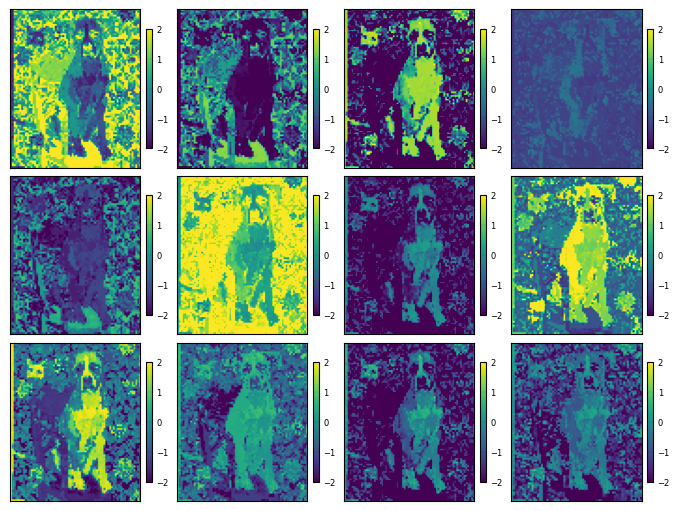

In [21]:
# computes the embeddings
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5), clim=(-2, 2))


- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


- We know that we only have 3 intrinsic latent variables


## Model with 3 latent variables

### Instantiates the model (3 latent variables)


In [22]:
# rebuilds the model with 3 latent dimensions
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [23]:
# prints the summary of the model
summary(model, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 3 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


In [24]:
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


### Trains the model


In [25]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 185.15it/s]


Epoch 0, Train Loss: 2.3594
.............................


100%|██████████| 19/19 [00:00<00:00, 160.84it/s]


Epoch 1, Train Loss: 2.3181
.............................


100%|██████████| 19/19 [00:00<00:00, 121.84it/s]


Epoch 2, Train Loss: 2.2805
.............................


100%|██████████| 19/19 [00:00<00:00, 159.81it/s]


Epoch 3, Train Loss: 2.2494
.............................


100%|██████████| 19/19 [00:00<00:00, 153.89it/s]


Epoch 4, Train Loss: 2.2163
.............................


100%|██████████| 19/19 [00:00<00:00, 158.97it/s]


Epoch 5, Train Loss: 2.1850
.............................


100%|██████████| 19/19 [00:00<00:00, 173.05it/s]


Epoch 6, Train Loss: 2.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 173.22it/s]


Epoch 7, Train Loss: 2.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 200.67it/s]


Epoch 8, Train Loss: 2.0912
.............................


100%|██████████| 19/19 [00:00<00:00, 205.04it/s]


Epoch 9, Train Loss: 2.0593
.............................


100%|██████████| 19/19 [00:00<00:00, 232.27it/s]


Epoch 10, Train Loss: 2.0236
.............................


100%|██████████| 19/19 [00:00<00:00, 253.01it/s]


Epoch 11, Train Loss: 1.9853
.............................


100%|██████████| 19/19 [00:00<00:00, 232.77it/s]


Epoch 12, Train Loss: 1.9495
.............................


100%|██████████| 19/19 [00:00<00:00, 243.98it/s]


Epoch 13, Train Loss: 1.9113
.............................


100%|██████████| 19/19 [00:00<00:00, 247.44it/s]


Epoch 14, Train Loss: 1.8703
.............................


100%|██████████| 19/19 [00:00<00:00, 200.00it/s]


Epoch 15, Train Loss: 1.8264
.............................


100%|██████████| 19/19 [00:00<00:00, 224.54it/s]


Epoch 16, Train Loss: 1.7808
.............................


100%|██████████| 19/19 [00:00<00:00, 202.97it/s]


Epoch 17, Train Loss: 1.7369
.............................


100%|██████████| 19/19 [00:00<00:00, 208.39it/s]


Epoch 18, Train Loss: 1.6876
.............................


100%|██████████| 19/19 [00:00<00:00, 226.41it/s]


Epoch 19, Train Loss: 1.6333
.............................


100%|██████████| 19/19 [00:00<00:00, 224.22it/s]

Epoch 20, Train Loss: 1.5798
.............................



100%|██████████| 19/19 [00:00<00:00, 228.76it/s]


Epoch 21, Train Loss: 1.5261
.............................


100%|██████████| 19/19 [00:00<00:00, 228.95it/s]


Epoch 22, Train Loss: 1.4660
.............................


100%|██████████| 19/19 [00:00<00:00, 241.65it/s]


Epoch 23, Train Loss: 1.4064
.............................


100%|██████████| 19/19 [00:00<00:00, 267.49it/s]


Epoch 24, Train Loss: 1.3457
.............................


100%|██████████| 19/19 [00:00<00:00, 244.16it/s]


Epoch 25, Train Loss: 1.2864
.............................


100%|██████████| 19/19 [00:00<00:00, 240.50it/s]


Epoch 26, Train Loss: 1.2266
.............................


100%|██████████| 19/19 [00:00<00:00, 249.87it/s]


Epoch 27, Train Loss: 1.1686
.............................


100%|██████████| 19/19 [00:00<00:00, 250.95it/s]


Epoch 28, Train Loss: 1.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 246.91it/s]


Epoch 29, Train Loss: 1.0524
.............................


100%|██████████| 19/19 [00:00<00:00, 268.66it/s]


Epoch 30, Train Loss: 0.9975
.............................


100%|██████████| 19/19 [00:00<00:00, 235.47it/s]


Epoch 31, Train Loss: 0.9439
.............................


100%|██████████| 19/19 [00:00<00:00, 246.54it/s]


Epoch 32, Train Loss: 0.8917
.............................


100%|██████████| 19/19 [00:00<00:00, 276.43it/s]


Epoch 33, Train Loss: 0.8427
.............................


100%|██████████| 19/19 [00:00<00:00, 250.52it/s]


Epoch 34, Train Loss: 0.7950
.............................


100%|██████████| 19/19 [00:00<00:00, 280.81it/s]


Epoch 35, Train Loss: 0.7502
.............................


100%|██████████| 19/19 [00:00<00:00, 256.57it/s]


Epoch 36, Train Loss: 0.7077
.............................


100%|██████████| 19/19 [00:00<00:00, 302.90it/s]


Epoch 37, Train Loss: 0.6668
.............................


100%|██████████| 19/19 [00:00<00:00, 257.87it/s]


Epoch 38, Train Loss: 0.6293
.............................


100%|██████████| 19/19 [00:00<00:00, 258.80it/s]


Epoch 39, Train Loss: 0.5935
.............................


100%|██████████| 19/19 [00:00<00:00, 260.11it/s]


Epoch 40, Train Loss: 0.5598
.............................


100%|██████████| 19/19 [00:00<00:00, 248.06it/s]


Epoch 41, Train Loss: 0.5290
.............................


100%|██████████| 19/19 [00:00<00:00, 247.68it/s]


Epoch 42, Train Loss: 0.5001
.............................


100%|██████████| 19/19 [00:00<00:00, 298.47it/s]


Epoch 43, Train Loss: 0.4723
.............................


100%|██████████| 19/19 [00:00<00:00, 333.02it/s]


Epoch 44, Train Loss: 0.4470
.............................


100%|██████████| 19/19 [00:00<00:00, 323.85it/s]


Epoch 45, Train Loss: 0.4242
.............................


100%|██████████| 19/19 [00:00<00:00, 317.10it/s]


Epoch 46, Train Loss: 0.4030
.............................


100%|██████████| 19/19 [00:00<00:00, 309.46it/s]


Epoch 47, Train Loss: 0.3825
.............................


100%|██████████| 19/19 [00:00<00:00, 304.61it/s]


Epoch 48, Train Loss: 0.3655
.............................


100%|██████████| 19/19 [00:00<00:00, 311.56it/s]


Epoch 49, Train Loss: 0.3486
.............................


100%|██████████| 19/19 [00:00<00:00, 306.18it/s]


Epoch 50, Train Loss: 0.3335
.............................


100%|██████████| 19/19 [00:00<00:00, 293.63it/s]


Epoch 51, Train Loss: 0.3193
.............................


100%|██████████| 19/19 [00:00<00:00, 311.20it/s]


Epoch 52, Train Loss: 0.3065
.............................


100%|██████████| 19/19 [00:00<00:00, 321.97it/s]


Epoch 53, Train Loss: 0.2943
.............................


100%|██████████| 19/19 [00:00<00:00, 278.17it/s]


Epoch 54, Train Loss: 0.2836
.............................


100%|██████████| 19/19 [00:00<00:00, 289.47it/s]


Epoch 55, Train Loss: 0.2732
.............................


100%|██████████| 19/19 [00:00<00:00, 269.93it/s]


Epoch 56, Train Loss: 0.2647
.............................


100%|██████████| 19/19 [00:00<00:00, 276.76it/s]


Epoch 57, Train Loss: 0.2565
.............................


100%|██████████| 19/19 [00:00<00:00, 272.15it/s]


Epoch 58, Train Loss: 0.2486
.............................


100%|██████████| 19/19 [00:00<00:00, 264.95it/s]


Epoch 59, Train Loss: 0.2418
.............................


100%|██████████| 19/19 [00:00<00:00, 249.44it/s]


Epoch 60, Train Loss: 0.2354
.............................


100%|██████████| 19/19 [00:00<00:00, 264.80it/s]


Epoch 61, Train Loss: 0.2295
.............................


100%|██████████| 19/19 [00:00<00:00, 254.25it/s]


Epoch 62, Train Loss: 0.2243
.............................


100%|██████████| 19/19 [00:00<00:00, 241.93it/s]


Epoch 63, Train Loss: 0.2194
.............................


100%|██████████| 19/19 [00:00<00:00, 249.06it/s]


Epoch 64, Train Loss: 0.2149
.............................


100%|██████████| 19/19 [00:00<00:00, 279.45it/s]


Epoch 65, Train Loss: 0.2106
.............................


100%|██████████| 19/19 [00:00<00:00, 251.44it/s]


Epoch 66, Train Loss: 0.2071
.............................


100%|██████████| 19/19 [00:00<00:00, 254.21it/s]


Epoch 67, Train Loss: 0.2032
.............................


100%|██████████| 19/19 [00:00<00:00, 224.20it/s]


Epoch 68, Train Loss: 0.2003
.............................


100%|██████████| 19/19 [00:00<00:00, 247.87it/s]


Epoch 69, Train Loss: 0.1968
.............................


100%|██████████| 19/19 [00:00<00:00, 276.75it/s]


Epoch 70, Train Loss: 0.1943
.............................


100%|██████████| 19/19 [00:00<00:00, 284.78it/s]


Epoch 71, Train Loss: 0.1916
.............................


100%|██████████| 19/19 [00:00<00:00, 263.21it/s]


Epoch 72, Train Loss: 0.1892
.............................


100%|██████████| 19/19 [00:00<00:00, 250.23it/s]


Epoch 73, Train Loss: 0.1871
.............................


100%|██████████| 19/19 [00:00<00:00, 250.40it/s]


Epoch 74, Train Loss: 0.1847
.............................


100%|██████████| 19/19 [00:00<00:00, 281.03it/s]


Epoch 75, Train Loss: 0.1827
.............................


100%|██████████| 19/19 [00:00<00:00, 289.15it/s]


Epoch 76, Train Loss: 0.1810
.............................


100%|██████████| 19/19 [00:00<00:00, 288.29it/s]


Epoch 77, Train Loss: 0.1790
.............................


100%|██████████| 19/19 [00:00<00:00, 261.10it/s]


Epoch 78, Train Loss: 0.1775
.............................


100%|██████████| 19/19 [00:00<00:00, 253.69it/s]


Epoch 79, Train Loss: 0.1761
.............................


100%|██████████| 19/19 [00:00<00:00, 225.27it/s]


Epoch 80, Train Loss: 0.1748
.............................


100%|██████████| 19/19 [00:00<00:00, 212.70it/s]


Epoch 81, Train Loss: 0.1733
.............................


100%|██████████| 19/19 [00:00<00:00, 245.06it/s]


Epoch 82, Train Loss: 0.1723
.............................


100%|██████████| 19/19 [00:00<00:00, 267.40it/s]


Epoch 83, Train Loss: 0.1712
.............................


100%|██████████| 19/19 [00:00<00:00, 268.73it/s]


Epoch 84, Train Loss: 0.1699
.............................


100%|██████████| 19/19 [00:00<00:00, 271.97it/s]


Epoch 85, Train Loss: 0.1690
.............................


100%|██████████| 19/19 [00:00<00:00, 268.69it/s]


Epoch 86, Train Loss: 0.1679
.............................


100%|██████████| 19/19 [00:00<00:00, 240.23it/s]


Epoch 87, Train Loss: 0.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 283.54it/s]


Epoch 88, Train Loss: 0.1664
.............................


100%|██████████| 19/19 [00:00<00:00, 284.71it/s]


Epoch 89, Train Loss: 0.1657
.............................


100%|██████████| 19/19 [00:00<00:00, 265.02it/s]


Epoch 90, Train Loss: 0.1649
.............................


100%|██████████| 19/19 [00:00<00:00, 306.31it/s]


Epoch 91, Train Loss: 0.1641
.............................


100%|██████████| 19/19 [00:00<00:00, 298.84it/s]


Epoch 92, Train Loss: 0.1634
.............................


100%|██████████| 19/19 [00:00<00:00, 299.74it/s]


Epoch 93, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 275.13it/s]


Epoch 94, Train Loss: 0.1623
.............................


100%|██████████| 19/19 [00:00<00:00, 224.59it/s]


Epoch 95, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 201.91it/s]


Epoch 96, Train Loss: 0.1612
.............................


100%|██████████| 19/19 [00:00<00:00, 251.40it/s]


Epoch 97, Train Loss: 0.1608
.............................


100%|██████████| 19/19 [00:00<00:00, 241.40it/s]


Epoch 98, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 268.44it/s]


Epoch 99, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 278.97it/s]


Epoch 100, Train Loss: 0.1595
.............................


100%|██████████| 19/19 [00:00<00:00, 293.98it/s]


Epoch 101, Train Loss: 0.1592
.............................


100%|██████████| 19/19 [00:00<00:00, 282.78it/s]


Epoch 102, Train Loss: 0.1587
.............................


100%|██████████| 19/19 [00:00<00:00, 293.13it/s]


Epoch 103, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 296.97it/s]


Epoch 104, Train Loss: 0.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 272.76it/s]


Epoch 105, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 287.46it/s]


Epoch 106, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 281.11it/s]


Epoch 107, Train Loss: 0.1570
.............................


100%|██████████| 19/19 [00:00<00:00, 262.46it/s]


Epoch 108, Train Loss: 0.1569
.............................


100%|██████████| 19/19 [00:00<00:00, 271.88it/s]


Epoch 109, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 298.48it/s]


Epoch 110, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 297.02it/s]


Epoch 111, Train Loss: 0.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 325.29it/s]


Epoch 112, Train Loss: 0.1559
.............................


100%|██████████| 19/19 [00:00<00:00, 319.52it/s]


Epoch 113, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 328.94it/s]


Epoch 114, Train Loss: 0.1554
.............................


100%|██████████| 19/19 [00:00<00:00, 334.42it/s]


Epoch 115, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 322.01it/s]


Epoch 116, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 328.86it/s]


Epoch 117, Train Loss: 0.1545
.............................


100%|██████████| 19/19 [00:00<00:00, 334.65it/s]


Epoch 118, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 328.76it/s]


Epoch 119, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 318.25it/s]


Epoch 120, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 310.12it/s]


Epoch 121, Train Loss: 0.1537
.............................


100%|██████████| 19/19 [00:00<00:00, 280.24it/s]


Epoch 122, Train Loss: 0.1535
.............................


100%|██████████| 19/19 [00:00<00:00, 233.71it/s]


Epoch 123, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 244.92it/s]


Epoch 124, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 223.34it/s]


Epoch 125, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 226.85it/s]


Epoch 126, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 204.98it/s]


Epoch 127, Train Loss: 0.1524
.............................


100%|██████████| 19/19 [00:00<00:00, 222.91it/s]


Epoch 128, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 196.99it/s]


Epoch 129, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 215.86it/s]


Epoch 130, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 207.61it/s]


Epoch 131, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 235.41it/s]


Epoch 132, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 226.72it/s]


Epoch 133, Train Loss: 0.1510
.............................


100%|██████████| 19/19 [00:00<00:00, 223.24it/s]


Epoch 134, Train Loss: 0.1509
.............................


100%|██████████| 19/19 [00:00<00:00, 221.67it/s]


Epoch 135, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 227.58it/s]


Epoch 136, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 224.16it/s]


Epoch 137, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 224.35it/s]


Epoch 138, Train Loss: 0.1499
.............................


100%|██████████| 19/19 [00:00<00:00, 216.34it/s]


Epoch 139, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 229.59it/s]


Epoch 140, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 232.54it/s]


Epoch 141, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 232.16it/s]


Epoch 142, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 204.70it/s]


Epoch 143, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 202.91it/s]


Epoch 144, Train Loss: 0.1485
.............................


100%|██████████| 19/19 [00:00<00:00, 191.88it/s]


Epoch 145, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 194.36it/s]


Epoch 146, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 224.63it/s]


Epoch 147, Train Loss: 0.1478
.............................


100%|██████████| 19/19 [00:00<00:00, 221.61it/s]


Epoch 148, Train Loss: 0.1474
.............................


100%|██████████| 19/19 [00:00<00:00, 243.96it/s]


Epoch 149, Train Loss: 0.1474
.............................


100%|██████████| 19/19 [00:00<00:00, 215.39it/s]


Epoch 150, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 244.40it/s]


Epoch 151, Train Loss: 0.1469
.............................


100%|██████████| 19/19 [00:00<00:00, 244.57it/s]


Epoch 152, Train Loss: 0.1466
.............................


100%|██████████| 19/19 [00:00<00:00, 237.62it/s]


Epoch 153, Train Loss: 0.1463
.............................


100%|██████████| 19/19 [00:00<00:00, 241.78it/s]


Epoch 154, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 220.49it/s]


Epoch 155, Train Loss: 0.1458
.............................


100%|██████████| 19/19 [00:00<00:00, 257.94it/s]


Epoch 156, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 226.98it/s]


Epoch 157, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 202.78it/s]


Epoch 158, Train Loss: 0.1451
.............................


100%|██████████| 19/19 [00:00<00:00, 237.83it/s]


Epoch 159, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 223.46it/s]


Epoch 160, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 257.71it/s]


Epoch 161, Train Loss: 0.1441
.............................


100%|██████████| 19/19 [00:00<00:00, 247.64it/s]


Epoch 162, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 232.42it/s]


Epoch 163, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 250.62it/s]


Epoch 164, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 252.93it/s]


Epoch 165, Train Loss: 0.1431
.............................


100%|██████████| 19/19 [00:00<00:00, 235.72it/s]


Epoch 166, Train Loss: 0.1429
.............................


100%|██████████| 19/19 [00:00<00:00, 217.85it/s]


Epoch 167, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 211.78it/s]


Epoch 168, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 197.13it/s]


Epoch 169, Train Loss: 0.1422
.............................


100%|██████████| 19/19 [00:00<00:00, 232.51it/s]


Epoch 170, Train Loss: 0.1420
.............................


100%|██████████| 19/19 [00:00<00:00, 238.52it/s]


Epoch 171, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 242.93it/s]


Epoch 172, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 234.45it/s]


Epoch 173, Train Loss: 0.1411
.............................


100%|██████████| 19/19 [00:00<00:00, 252.48it/s]


Epoch 174, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 268.94it/s]


Epoch 175, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 250.92it/s]


Epoch 176, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 257.77it/s]


Epoch 177, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 249.79it/s]


Epoch 178, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 246.76it/s]


Epoch 179, Train Loss: 0.1395
.............................


100%|██████████| 19/19 [00:00<00:00, 229.07it/s]


Epoch 180, Train Loss: 0.1391
.............................


100%|██████████| 19/19 [00:00<00:00, 226.64it/s]


Epoch 181, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 229.14it/s]


Epoch 182, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 237.74it/s]


Epoch 183, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 235.10it/s]


Epoch 184, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 245.72it/s]


Epoch 185, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 222.10it/s]


Epoch 186, Train Loss: 0.1371
.............................


100%|██████████| 19/19 [00:00<00:00, 198.90it/s]


Epoch 187, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 209.20it/s]


Epoch 188, Train Loss: 0.1367
.............................


100%|██████████| 19/19 [00:00<00:00, 224.95it/s]


Epoch 189, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 243.91it/s]


Epoch 190, Train Loss: 0.1363
.............................


100%|██████████| 19/19 [00:00<00:00, 211.58it/s]


Epoch 191, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 219.13it/s]


Epoch 192, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 275.67it/s]


Epoch 193, Train Loss: 0.1355
.............................


100%|██████████| 19/19 [00:00<00:00, 259.82it/s]


Epoch 194, Train Loss: 0.1350
.............................


100%|██████████| 19/19 [00:00<00:00, 251.05it/s]


Epoch 195, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 272.03it/s]


Epoch 196, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 277.34it/s]


Epoch 197, Train Loss: 0.1342
.............................


100%|██████████| 19/19 [00:00<00:00, 271.04it/s]


Epoch 198, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 287.20it/s]


Epoch 199, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 298.11it/s]


Epoch 200, Train Loss: 0.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 288.28it/s]


Epoch 201, Train Loss: 0.1328
.............................


100%|██████████| 19/19 [00:00<00:00, 269.75it/s]


Epoch 202, Train Loss: 0.1326
.............................


100%|██████████| 19/19 [00:00<00:00, 251.12it/s]


Epoch 203, Train Loss: 0.1325
.............................


100%|██████████| 19/19 [00:00<00:00, 238.57it/s]


Epoch 204, Train Loss: 0.1321
.............................


100%|██████████| 19/19 [00:00<00:00, 143.90it/s]


Epoch 205, Train Loss: 0.1320
.............................


100%|██████████| 19/19 [00:00<00:00, 238.76it/s]


Epoch 206, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 224.36it/s]


Epoch 207, Train Loss: 0.1311
.............................


100%|██████████| 19/19 [00:00<00:00, 247.24it/s]


Epoch 208, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 253.48it/s]


Epoch 209, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 270.09it/s]


Epoch 210, Train Loss: 0.1303
.............................


100%|██████████| 19/19 [00:00<00:00, 281.94it/s]


Epoch 211, Train Loss: 0.1302
.............................


100%|██████████| 19/19 [00:00<00:00, 257.85it/s]


Epoch 212, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 283.80it/s]


Epoch 213, Train Loss: 0.1294
.............................


100%|██████████| 19/19 [00:00<00:00, 297.09it/s]


Epoch 214, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 271.97it/s]


Epoch 215, Train Loss: 0.1287
.............................


100%|██████████| 19/19 [00:00<00:00, 199.54it/s]


Epoch 216, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 262.95it/s]


Epoch 217, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 268.78it/s]


Epoch 218, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 279.40it/s]


Epoch 219, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 265.22it/s]


Epoch 220, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 280.47it/s]


Epoch 221, Train Loss: 0.1271
.............................


100%|██████████| 19/19 [00:00<00:00, 250.79it/s]


Epoch 222, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 316.90it/s]


Epoch 223, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 297.47it/s]


Epoch 224, Train Loss: 0.1264
.............................


100%|██████████| 19/19 [00:00<00:00, 293.33it/s]


Epoch 225, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 292.56it/s]


Epoch 226, Train Loss: 0.1255
.............................


100%|██████████| 19/19 [00:00<00:00, 334.83it/s]


Epoch 227, Train Loss: 0.1253
.............................


100%|██████████| 19/19 [00:00<00:00, 321.66it/s]


Epoch 228, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 300.76it/s]


Epoch 229, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 281.02it/s]


Epoch 230, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 264.31it/s]


Epoch 231, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 275.66it/s]


Epoch 232, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 293.77it/s]


Epoch 233, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 322.48it/s]


Epoch 234, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 305.69it/s]


Epoch 235, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 334.63it/s]


Epoch 236, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 307.51it/s]


Epoch 237, Train Loss: 0.1223
.............................


100%|██████████| 19/19 [00:00<00:00, 316.79it/s]


Epoch 238, Train Loss: 0.1220
.............................


100%|██████████| 19/19 [00:00<00:00, 312.37it/s]


Epoch 239, Train Loss: 0.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 347.32it/s]


Epoch 240, Train Loss: 0.1217
.............................


100%|██████████| 19/19 [00:00<00:00, 345.47it/s]


Epoch 241, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 318.56it/s]


Epoch 242, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 308.38it/s]


Epoch 243, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 269.29it/s]


Epoch 244, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 260.19it/s]


Epoch 245, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:00<00:00, 254.09it/s]


Epoch 246, Train Loss: 0.1198
.............................


100%|██████████| 19/19 [00:00<00:00, 274.03it/s]


Epoch 247, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 235.66it/s]


Epoch 248, Train Loss: 0.1193
.............................


100%|██████████| 19/19 [00:00<00:00, 243.77it/s]


Epoch 249, Train Loss: 0.1189
.............................


100%|██████████| 19/19 [00:00<00:00, 220.91it/s]


Epoch 250, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 135.48it/s]


Epoch 251, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 166.19it/s]


Epoch 252, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 172.28it/s]


Epoch 253, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 202.31it/s]


Epoch 254, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 185.05it/s]


Epoch 255, Train Loss: 0.1174
.............................


100%|██████████| 19/19 [00:00<00:00, 211.92it/s]


Epoch 256, Train Loss: 0.1170
.............................


100%|██████████| 19/19 [00:00<00:00, 218.69it/s]


Epoch 257, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 218.82it/s]


Epoch 258, Train Loss: 0.1166
.............................


100%|██████████| 19/19 [00:00<00:00, 238.24it/s]


Epoch 259, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 260.28it/s]


Epoch 260, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 265.95it/s]


Epoch 261, Train Loss: 0.1159
.............................


100%|██████████| 19/19 [00:00<00:00, 249.16it/s]


Epoch 262, Train Loss: 0.1156
.............................


100%|██████████| 19/19 [00:00<00:00, 251.06it/s]


Epoch 263, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 243.65it/s]


Epoch 264, Train Loss: 0.1150
.............................


100%|██████████| 19/19 [00:00<00:00, 235.03it/s]


Epoch 265, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 215.93it/s]


Epoch 266, Train Loss: 0.1145
.............................


100%|██████████| 19/19 [00:00<00:00, 199.79it/s]


Epoch 267, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 216.07it/s]


Epoch 268, Train Loss: 0.1140
.............................


100%|██████████| 19/19 [00:00<00:00, 202.29it/s]


Epoch 269, Train Loss: 0.1137
.............................


100%|██████████| 19/19 [00:00<00:00, 242.98it/s]

Epoch 270, Train Loss: 0.1135
.............................



100%|██████████| 19/19 [00:00<00:00, 237.73it/s]


Epoch 271, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 229.04it/s]


Epoch 272, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 226.89it/s]


Epoch 273, Train Loss: 0.1127
.............................


100%|██████████| 19/19 [00:00<00:00, 221.35it/s]


Epoch 274, Train Loss: 0.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 225.77it/s]


Epoch 275, Train Loss: 0.1125
.............................


100%|██████████| 19/19 [00:00<00:00, 268.42it/s]


Epoch 276, Train Loss: 0.1122
.............................


100%|██████████| 19/19 [00:00<00:00, 264.48it/s]


Epoch 277, Train Loss: 0.1119
.............................


100%|██████████| 19/19 [00:00<00:00, 247.59it/s]


Epoch 278, Train Loss: 0.1117
.............................


100%|██████████| 19/19 [00:00<00:00, 232.35it/s]


Epoch 279, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 236.69it/s]


Epoch 280, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 254.63it/s]


Epoch 281, Train Loss: 0.1110
.............................


100%|██████████| 19/19 [00:00<00:00, 238.18it/s]


Epoch 282, Train Loss: 0.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 261.12it/s]


Epoch 283, Train Loss: 0.1106
.............................


100%|██████████| 19/19 [00:00<00:00, 243.73it/s]


Epoch 284, Train Loss: 0.1104
.............................


100%|██████████| 19/19 [00:00<00:00, 259.78it/s]


Epoch 285, Train Loss: 0.1100
.............................


100%|██████████| 19/19 [00:00<00:00, 238.15it/s]


Epoch 286, Train Loss: 0.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 235.04it/s]


Epoch 287, Train Loss: 0.1094
.............................


100%|██████████| 19/19 [00:00<00:00, 280.75it/s]


Epoch 288, Train Loss: 0.1096
.............................


100%|██████████| 19/19 [00:00<00:00, 244.58it/s]


Epoch 289, Train Loss: 0.1092
.............................


100%|██████████| 19/19 [00:00<00:00, 221.27it/s]


Epoch 290, Train Loss: 0.1091
.............................


100%|██████████| 19/19 [00:00<00:00, 174.58it/s]


Epoch 291, Train Loss: 0.1089
.............................


100%|██████████| 19/19 [00:00<00:00, 232.27it/s]


Epoch 292, Train Loss: 0.1084
.............................


100%|██████████| 19/19 [00:00<00:00, 240.69it/s]


Epoch 293, Train Loss: 0.1084
.............................


100%|██████████| 19/19 [00:00<00:00, 229.91it/s]


Epoch 294, Train Loss: 0.1083
.............................


100%|██████████| 19/19 [00:00<00:00, 254.78it/s]


Epoch 295, Train Loss: 0.1081
.............................


100%|██████████| 19/19 [00:00<00:00, 241.08it/s]


Epoch 296, Train Loss: 0.1079
.............................


100%|██████████| 19/19 [00:00<00:00, 250.34it/s]


Epoch 297, Train Loss: 0.1076
.............................


100%|██████████| 19/19 [00:00<00:00, 243.22it/s]


Epoch 298, Train Loss: 0.1073
.............................


100%|██████████| 19/19 [00:00<00:00, 246.49it/s]


Epoch 299, Train Loss: 0.1072
.............................


100%|██████████| 19/19 [00:00<00:00, 224.99it/s]


Epoch 300, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 246.64it/s]


Epoch 301, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 206.20it/s]


Epoch 302, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 228.59it/s]


Epoch 303, Train Loss: 0.1066
.............................


100%|██████████| 19/19 [00:00<00:00, 211.92it/s]


Epoch 304, Train Loss: 0.1063
.............................


100%|██████████| 19/19 [00:00<00:00, 207.42it/s]


Epoch 305, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 204.76it/s]


Epoch 306, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 213.74it/s]


Epoch 307, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 206.99it/s]


Epoch 308, Train Loss: 0.1060
.............................


100%|██████████| 19/19 [00:00<00:00, 205.18it/s]


Epoch 309, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 228.47it/s]


Epoch 310, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 207.09it/s]


Epoch 311, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 232.56it/s]


Epoch 312, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 217.93it/s]


Epoch 313, Train Loss: 0.1050
.............................


100%|██████████| 19/19 [00:00<00:00, 211.94it/s]


Epoch 314, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 232.31it/s]


Epoch 315, Train Loss: 0.1045
.............................


100%|██████████| 19/19 [00:00<00:00, 235.12it/s]


Epoch 316, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 257.42it/s]


Epoch 317, Train Loss: 0.1042
.............................


100%|██████████| 19/19 [00:00<00:00, 243.26it/s]


Epoch 318, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 254.66it/s]


Epoch 319, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 241.93it/s]


Epoch 320, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 251.13it/s]


Epoch 321, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 208.88it/s]


Epoch 322, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 229.42it/s]


Epoch 323, Train Loss: 0.1035
.............................


100%|██████████| 19/19 [00:00<00:00, 207.79it/s]


Epoch 324, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 203.06it/s]


Epoch 325, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 236.52it/s]


Epoch 326, Train Loss: 0.1029
.............................


100%|██████████| 19/19 [00:00<00:00, 241.43it/s]


Epoch 327, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 167.43it/s]


Epoch 328, Train Loss: 0.1028
.............................


100%|██████████| 19/19 [00:00<00:00, 185.99it/s]


Epoch 329, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 231.47it/s]


Epoch 330, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 235.52it/s]


Epoch 331, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 226.97it/s]


Epoch 332, Train Loss: 0.1023
.............................


100%|██████████| 19/19 [00:00<00:00, 237.93it/s]


Epoch 333, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 243.18it/s]


Epoch 334, Train Loss: 0.1020
.............................


100%|██████████| 19/19 [00:00<00:00, 208.25it/s]


Epoch 335, Train Loss: 0.1018
.............................


100%|██████████| 19/19 [00:00<00:00, 214.48it/s]


Epoch 336, Train Loss: 0.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 237.10it/s]


Epoch 337, Train Loss: 0.1017
.............................


100%|██████████| 19/19 [00:00<00:00, 223.52it/s]


Epoch 338, Train Loss: 0.1017
.............................


100%|██████████| 19/19 [00:00<00:00, 219.15it/s]


Epoch 339, Train Loss: 0.1014
.............................


100%|██████████| 19/19 [00:00<00:00, 247.26it/s]


Epoch 340, Train Loss: 0.1011
.............................


100%|██████████| 19/19 [00:00<00:00, 228.80it/s]


Epoch 341, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 247.07it/s]


Epoch 342, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 268.35it/s]


Epoch 343, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 267.52it/s]


Epoch 344, Train Loss: 0.1008
.............................


100%|██████████| 19/19 [00:00<00:00, 250.76it/s]


Epoch 345, Train Loss: 0.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 227.17it/s]


Epoch 346, Train Loss: 0.1006
.............................


100%|██████████| 19/19 [00:00<00:00, 227.44it/s]


Epoch 347, Train Loss: 0.1004
.............................


100%|██████████| 19/19 [00:00<00:00, 219.57it/s]


Epoch 348, Train Loss: 0.1002
.............................


100%|██████████| 19/19 [00:00<00:00, 230.41it/s]


Epoch 349, Train Loss: 0.1000
.............................


100%|██████████| 19/19 [00:00<00:00, 260.87it/s]


Epoch 350, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 247.24it/s]


Epoch 351, Train Loss: 0.1000
.............................


100%|██████████| 19/19 [00:00<00:00, 264.86it/s]


Epoch 352, Train Loss: 0.0998
.............................


100%|██████████| 19/19 [00:00<00:00, 264.96it/s]


Epoch 353, Train Loss: 0.0997
.............................


100%|██████████| 19/19 [00:00<00:00, 245.46it/s]


Epoch 354, Train Loss: 0.0998
.............................


100%|██████████| 19/19 [00:00<00:00, 249.81it/s]


Epoch 355, Train Loss: 0.0995
.............................


100%|██████████| 19/19 [00:00<00:00, 272.71it/s]


Epoch 356, Train Loss: 0.0992
.............................


100%|██████████| 19/19 [00:00<00:00, 277.82it/s]


Epoch 357, Train Loss: 0.0991
.............................


100%|██████████| 19/19 [00:00<00:00, 240.62it/s]


Epoch 358, Train Loss: 0.0992
.............................


100%|██████████| 19/19 [00:00<00:00, 244.29it/s]


Epoch 359, Train Loss: 0.0989
.............................


100%|██████████| 19/19 [00:00<00:00, 198.42it/s]


Epoch 360, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 209.30it/s]


Epoch 361, Train Loss: 0.0988
.............................


100%|██████████| 19/19 [00:00<00:00, 153.64it/s]


Epoch 362, Train Loss: 0.0987
.............................


100%|██████████| 19/19 [00:00<00:00, 175.04it/s]


Epoch 363, Train Loss: 0.0987
.............................


100%|██████████| 19/19 [00:00<00:00, 179.94it/s]


Epoch 364, Train Loss: 0.0985
.............................


100%|██████████| 19/19 [00:00<00:00, 184.19it/s]


Epoch 365, Train Loss: 0.0983
.............................


100%|██████████| 19/19 [00:00<00:00, 185.37it/s]


Epoch 366, Train Loss: 0.0982
.............................


100%|██████████| 19/19 [00:00<00:00, 207.19it/s]


Epoch 367, Train Loss: 0.0980
.............................


100%|██████████| 19/19 [00:00<00:00, 198.45it/s]


Epoch 368, Train Loss: 0.0980
.............................


100%|██████████| 19/19 [00:00<00:00, 165.59it/s]


Epoch 369, Train Loss: 0.0979
.............................


100%|██████████| 19/19 [00:00<00:00, 164.19it/s]


Epoch 370, Train Loss: 0.0975
.............................


100%|██████████| 19/19 [00:00<00:00, 183.14it/s]


Epoch 371, Train Loss: 0.0977
.............................


100%|██████████| 19/19 [00:00<00:00, 207.92it/s]


Epoch 372, Train Loss: 0.0974
.............................


100%|██████████| 19/19 [00:00<00:00, 214.26it/s]


Epoch 373, Train Loss: 0.0974
.............................


100%|██████████| 19/19 [00:00<00:00, 215.85it/s]


Epoch 374, Train Loss: 0.0973
.............................


100%|██████████| 19/19 [00:00<00:00, 246.00it/s]


Epoch 375, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 223.80it/s]


Epoch 376, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 226.19it/s]


Epoch 377, Train Loss: 0.0969
.............................


100%|██████████| 19/19 [00:00<00:00, 227.98it/s]


Epoch 378, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 204.39it/s]


Epoch 379, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 196.52it/s]


Epoch 380, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 198.19it/s]


Epoch 381, Train Loss: 0.0963
.............................


100%|██████████| 19/19 [00:00<00:00, 211.68it/s]


Epoch 382, Train Loss: 0.0961
.............................


100%|██████████| 19/19 [00:00<00:00, 232.20it/s]


Epoch 383, Train Loss: 0.0962
.............................


100%|██████████| 19/19 [00:00<00:00, 237.29it/s]


Epoch 384, Train Loss: 0.0960
.............................


100%|██████████| 19/19 [00:00<00:00, 244.55it/s]


Epoch 385, Train Loss: 0.0959
.............................


100%|██████████| 19/19 [00:00<00:00, 224.96it/s]


Epoch 386, Train Loss: 0.0958
.............................


100%|██████████| 19/19 [00:00<00:00, 241.36it/s]


Epoch 387, Train Loss: 0.0956
.............................


100%|██████████| 19/19 [00:00<00:00, 264.45it/s]


Epoch 388, Train Loss: 0.0955
.............................


100%|██████████| 19/19 [00:00<00:00, 241.23it/s]


Epoch 389, Train Loss: 0.0954
.............................


100%|██████████| 19/19 [00:00<00:00, 250.01it/s]


Epoch 390, Train Loss: 0.0953
.............................


100%|██████████| 19/19 [00:00<00:00, 214.44it/s]

Epoch 391, Train Loss: 0.0951
.............................



100%|██████████| 19/19 [00:00<00:00, 169.03it/s]


Epoch 392, Train Loss: 0.0949
.............................


100%|██████████| 19/19 [00:00<00:00, 220.69it/s]


Epoch 393, Train Loss: 0.0948
.............................


100%|██████████| 19/19 [00:00<00:00, 238.75it/s]


Epoch 394, Train Loss: 0.0946
.............................


100%|██████████| 19/19 [00:00<00:00, 244.25it/s]


Epoch 395, Train Loss: 0.0944
.............................


100%|██████████| 19/19 [00:00<00:00, 232.49it/s]


Epoch 396, Train Loss: 0.0943
.............................


100%|██████████| 19/19 [00:00<00:00, 257.04it/s]


Epoch 397, Train Loss: 0.0943
.............................


100%|██████████| 19/19 [00:00<00:00, 239.17it/s]


Epoch 398, Train Loss: 0.0941
.............................


100%|██████████| 19/19 [00:00<00:00, 256.63it/s]


Epoch 399, Train Loss: 0.0941
.............................


100%|██████████| 19/19 [00:00<00:00, 261.14it/s]


Epoch 400, Train Loss: 0.0939
.............................


100%|██████████| 19/19 [00:00<00:00, 254.89it/s]


Epoch 401, Train Loss: 0.0937
.............................


100%|██████████| 19/19 [00:00<00:00, 257.78it/s]


Epoch 402, Train Loss: 0.0935
.............................


100%|██████████| 19/19 [00:00<00:00, 221.87it/s]


Epoch 403, Train Loss: 0.0934
.............................


100%|██████████| 19/19 [00:00<00:00, 230.92it/s]


Epoch 404, Train Loss: 0.0934
.............................


100%|██████████| 19/19 [00:00<00:00, 238.48it/s]


Epoch 405, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 244.58it/s]


Epoch 406, Train Loss: 0.0930
.............................


100%|██████████| 19/19 [00:00<00:00, 247.36it/s]


Epoch 407, Train Loss: 0.0929
.............................


100%|██████████| 19/19 [00:00<00:00, 261.09it/s]


Epoch 408, Train Loss: 0.0926
.............................


100%|██████████| 19/19 [00:00<00:00, 252.85it/s]


Epoch 409, Train Loss: 0.0925
.............................


100%|██████████| 19/19 [00:00<00:00, 243.58it/s]


Epoch 410, Train Loss: 0.0926
.............................


100%|██████████| 19/19 [00:00<00:00, 250.73it/s]


Epoch 411, Train Loss: 0.0925
.............................


100%|██████████| 19/19 [00:00<00:00, 253.83it/s]


Epoch 412, Train Loss: 0.0922
.............................


100%|██████████| 19/19 [00:00<00:00, 264.26it/s]


Epoch 413, Train Loss: 0.0922
.............................


100%|██████████| 19/19 [00:00<00:00, 251.10it/s]


Epoch 414, Train Loss: 0.0918
.............................


100%|██████████| 19/19 [00:00<00:00, 221.02it/s]


Epoch 415, Train Loss: 0.0918
.............................


100%|██████████| 19/19 [00:00<00:00, 212.02it/s]


Epoch 416, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 209.68it/s]


Epoch 417, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 200.46it/s]


Epoch 418, Train Loss: 0.0916
.............................


100%|██████████| 19/19 [00:00<00:00, 195.70it/s]


Epoch 419, Train Loss: 0.0913
.............................


100%|██████████| 19/19 [00:00<00:00, 200.25it/s]


Epoch 420, Train Loss: 0.0911
.............................


100%|██████████| 19/19 [00:00<00:00, 196.00it/s]


Epoch 421, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 157.88it/s]


Epoch 422, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 194.70it/s]


Epoch 423, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 190.56it/s]


Epoch 424, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 169.45it/s]


Epoch 425, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 192.72it/s]


Epoch 426, Train Loss: 0.0903
.............................


100%|██████████| 19/19 [00:00<00:00, 181.32it/s]


Epoch 427, Train Loss: 0.0901
.............................


100%|██████████| 19/19 [00:00<00:00, 202.73it/s]


Epoch 428, Train Loss: 0.0900
.............................


100%|██████████| 19/19 [00:00<00:00, 209.08it/s]


Epoch 429, Train Loss: 0.0899
.............................


100%|██████████| 19/19 [00:00<00:00, 201.47it/s]


Epoch 430, Train Loss: 0.0896
.............................


100%|██████████| 19/19 [00:00<00:00, 203.96it/s]


Epoch 431, Train Loss: 0.0896
.............................


100%|██████████| 19/19 [00:00<00:00, 182.09it/s]


Epoch 432, Train Loss: 0.0894
.............................


100%|██████████| 19/19 [00:00<00:00, 180.19it/s]


Epoch 433, Train Loss: 0.0894
.............................


100%|██████████| 19/19 [00:00<00:00, 171.18it/s]


Epoch 434, Train Loss: 0.0892
.............................


100%|██████████| 19/19 [00:00<00:00, 181.63it/s]


Epoch 435, Train Loss: 0.0889
.............................


100%|██████████| 19/19 [00:00<00:00, 177.37it/s]


Epoch 436, Train Loss: 0.0888
.............................


100%|██████████| 19/19 [00:00<00:00, 188.32it/s]


Epoch 437, Train Loss: 0.0887
.............................


100%|██████████| 19/19 [00:00<00:00, 202.37it/s]


Epoch 438, Train Loss: 0.0885
.............................


100%|██████████| 19/19 [00:00<00:00, 222.79it/s]


Epoch 439, Train Loss: 0.0884
.............................


100%|██████████| 19/19 [00:00<00:00, 234.88it/s]


Epoch 440, Train Loss: 0.0883
.............................


100%|██████████| 19/19 [00:00<00:00, 228.48it/s]


Epoch 441, Train Loss: 0.0882
.............................


100%|██████████| 19/19 [00:00<00:00, 250.02it/s]


Epoch 442, Train Loss: 0.0878
.............................


100%|██████████| 19/19 [00:00<00:00, 254.11it/s]


Epoch 443, Train Loss: 0.0878
.............................


100%|██████████| 19/19 [00:00<00:00, 237.48it/s]


Epoch 444, Train Loss: 0.0876
.............................


100%|██████████| 19/19 [00:00<00:00, 238.41it/s]


Epoch 445, Train Loss: 0.0875
.............................


100%|██████████| 19/19 [00:00<00:00, 209.18it/s]


Epoch 446, Train Loss: 0.0872
.............................


100%|██████████| 19/19 [00:00<00:00, 160.07it/s]


Epoch 447, Train Loss: 0.0872
.............................


100%|██████████| 19/19 [00:00<00:00, 200.14it/s]


Epoch 448, Train Loss: 0.0870
.............................


100%|██████████| 19/19 [00:00<00:00, 202.76it/s]


Epoch 449, Train Loss: 0.0870
.............................


100%|██████████| 19/19 [00:00<00:00, 226.89it/s]


Epoch 450, Train Loss: 0.0868
.............................


100%|██████████| 19/19 [00:00<00:00, 240.46it/s]


Epoch 451, Train Loss: 0.0867
.............................


100%|██████████| 19/19 [00:00<00:00, 229.12it/s]


Epoch 452, Train Loss: 0.0867
.............................


100%|██████████| 19/19 [00:00<00:00, 244.16it/s]


Epoch 453, Train Loss: 0.0864
.............................


100%|██████████| 19/19 [00:00<00:00, 241.06it/s]


Epoch 454, Train Loss: 0.0863
.............................


100%|██████████| 19/19 [00:00<00:00, 253.33it/s]


Epoch 455, Train Loss: 0.0860
.............................


100%|██████████| 19/19 [00:00<00:00, 208.32it/s]


Epoch 456, Train Loss: 0.0858
.............................


100%|██████████| 19/19 [00:00<00:00, 217.03it/s]


Epoch 457, Train Loss: 0.0857
.............................


100%|██████████| 19/19 [00:00<00:00, 224.30it/s]


Epoch 458, Train Loss: 0.0857
.............................


100%|██████████| 19/19 [00:00<00:00, 244.36it/s]


Epoch 459, Train Loss: 0.0856
.............................


100%|██████████| 19/19 [00:00<00:00, 226.49it/s]


Epoch 460, Train Loss: 0.0854
.............................


100%|██████████| 19/19 [00:00<00:00, 243.90it/s]


Epoch 461, Train Loss: 0.0852
.............................


100%|██████████| 19/19 [00:00<00:00, 258.47it/s]


Epoch 462, Train Loss: 0.0850
.............................


100%|██████████| 19/19 [00:00<00:00, 250.10it/s]


Epoch 463, Train Loss: 0.0849
.............................


100%|██████████| 19/19 [00:00<00:00, 276.71it/s]


Epoch 464, Train Loss: 0.0849
.............................


100%|██████████| 19/19 [00:00<00:00, 281.99it/s]


Epoch 465, Train Loss: 0.0847
.............................


100%|██████████| 19/19 [00:00<00:00, 257.38it/s]


Epoch 466, Train Loss: 0.0845
.............................


100%|██████████| 19/19 [00:00<00:00, 249.28it/s]


Epoch 467, Train Loss: 0.0843
.............................


100%|██████████| 19/19 [00:00<00:00, 204.12it/s]


Epoch 468, Train Loss: 0.0843
.............................


100%|██████████| 19/19 [00:00<00:00, 211.55it/s]


Epoch 469, Train Loss: 0.0841
.............................


100%|██████████| 19/19 [00:00<00:00, 218.71it/s]

Epoch 470, Train Loss: 0.0840
.............................



100%|██████████| 19/19 [00:00<00:00, 198.67it/s]


Epoch 471, Train Loss: 0.0839
.............................


100%|██████████| 19/19 [00:00<00:00, 202.83it/s]


Epoch 472, Train Loss: 0.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 140.82it/s]


Epoch 473, Train Loss: 0.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 162.21it/s]


Epoch 474, Train Loss: 0.0833
.............................


100%|██████████| 19/19 [00:00<00:00, 193.76it/s]


Epoch 475, Train Loss: 0.0834
.............................


100%|██████████| 19/19 [00:00<00:00, 204.57it/s]


Epoch 476, Train Loss: 0.0831
.............................


100%|██████████| 19/19 [00:00<00:00, 209.24it/s]


Epoch 477, Train Loss: 0.0830
.............................


100%|██████████| 19/19 [00:00<00:00, 198.19it/s]


Epoch 478, Train Loss: 0.0830
.............................


100%|██████████| 19/19 [00:00<00:00, 206.96it/s]


Epoch 479, Train Loss: 0.0827
.............................


100%|██████████| 19/19 [00:00<00:00, 224.05it/s]


Epoch 480, Train Loss: 0.0826
.............................


100%|██████████| 19/19 [00:00<00:00, 226.53it/s]


Epoch 481, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 211.02it/s]


Epoch 482, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 216.59it/s]


Epoch 483, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 173.76it/s]


Epoch 484, Train Loss: 0.0822
.............................


100%|██████████| 19/19 [00:00<00:00, 187.30it/s]


Epoch 485, Train Loss: 0.0819
.............................


100%|██████████| 19/19 [00:00<00:00, 180.92it/s]


Epoch 486, Train Loss: 0.0818
.............................


100%|██████████| 19/19 [00:00<00:00, 194.54it/s]


Epoch 487, Train Loss: 0.0819
.............................


100%|██████████| 19/19 [00:00<00:00, 187.10it/s]


Epoch 488, Train Loss: 0.0817
.............................


100%|██████████| 19/19 [00:00<00:00, 204.70it/s]


Epoch 489, Train Loss: 0.0815
.............................


100%|██████████| 19/19 [00:00<00:00, 221.34it/s]


Epoch 490, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 204.24it/s]


Epoch 491, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 238.07it/s]


Epoch 492, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 246.43it/s]


Epoch 493, Train Loss: 0.0811
.............................


100%|██████████| 19/19 [00:00<00:00, 207.96it/s]


Epoch 494, Train Loss: 0.0809
.............................


100%|██████████| 19/19 [00:00<00:00, 227.11it/s]


Epoch 495, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 246.15it/s]


Epoch 496, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 176.65it/s]


Epoch 497, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 211.92it/s]


Epoch 498, Train Loss: 0.0804
.............................


100%|██████████| 19/19 [00:00<00:00, 226.95it/s]

Epoch 499, Train Loss: 0.0803
.............................


In [26]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


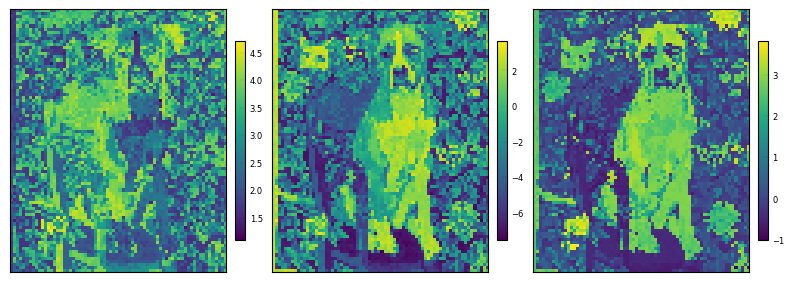

In [27]:
embeddings(encode, shape_=image.shape[0:2], figsize=(10, 5))


- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


### Generator

- Now we want to see how the spectra changes as we traverse the latent space


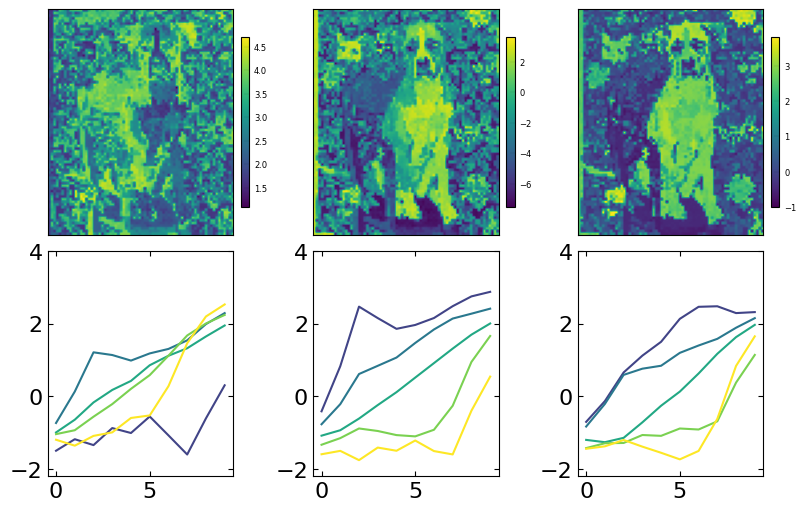

In [28]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(10, 5), divider_=False)


## Recurrent Neural Network Autoencoders


- The above example did not consider the temporal information in the data.


- This can be improved by using a recurrent neural network that processes each time step sequentially.


- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/LSTM%20Node.png?raw=true)


### Builds the model


In [29]:
latent_dim = 12

# encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [30]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


### Dataloader


In [31]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [32]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:02<00:00,  7.74it/s]


Epoch 0, Train Loss: 2.2412
.............................


100%|██████████| 19/19 [00:00<00:00, 102.28it/s]


Epoch 1, Train Loss: 2.2313
.............................


100%|██████████| 19/19 [00:00<00:00, 100.37it/s]


Epoch 2, Train Loss: 2.2214
.............................


100%|██████████| 19/19 [00:00<00:00, 106.61it/s]


Epoch 3, Train Loss: 2.2117
.............................


100%|██████████| 19/19 [00:00<00:00, 98.70it/s] 


Epoch 4, Train Loss: 2.2020
.............................


100%|██████████| 19/19 [00:00<00:00, 99.71it/s] 


Epoch 5, Train Loss: 2.1923
.............................


100%|██████████| 19/19 [00:00<00:00, 102.58it/s]


Epoch 6, Train Loss: 2.1826
.............................


100%|██████████| 19/19 [00:00<00:00, 108.96it/s]


Epoch 7, Train Loss: 2.1729
.............................


100%|██████████| 19/19 [00:00<00:00, 105.27it/s]


Epoch 8, Train Loss: 2.1631
.............................


100%|██████████| 19/19 [00:00<00:00, 81.70it/s]


Epoch 9, Train Loss: 2.1533
.............................


100%|██████████| 19/19 [00:00<00:00, 75.08it/s]


Epoch 10, Train Loss: 2.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 79.69it/s]


Epoch 11, Train Loss: 2.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 91.71it/s]


Epoch 12, Train Loss: 2.1230
.............................


100%|██████████| 19/19 [00:00<00:00, 88.31it/s]


Epoch 13, Train Loss: 2.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 94.18it/s]


Epoch 14, Train Loss: 2.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 102.28it/s]


Epoch 15, Train Loss: 2.0911
.............................


100%|██████████| 19/19 [00:00<00:00, 92.19it/s]


Epoch 16, Train Loss: 2.0799
.............................


100%|██████████| 19/19 [00:00<00:00, 81.28it/s]


Epoch 17, Train Loss: 2.0686
.............................


100%|██████████| 19/19 [00:00<00:00, 69.83it/s]


Epoch 18, Train Loss: 2.0569
.............................


100%|██████████| 19/19 [00:00<00:00, 82.15it/s]


Epoch 19, Train Loss: 2.0449
.............................


100%|██████████| 19/19 [00:00<00:00, 86.99it/s]


Epoch 20, Train Loss: 2.0326
.............................


100%|██████████| 19/19 [00:00<00:00, 87.16it/s]


Epoch 21, Train Loss: 2.0200
.............................


100%|██████████| 19/19 [00:00<00:00, 97.60it/s] 


Epoch 22, Train Loss: 2.0070
.............................


100%|██████████| 19/19 [00:00<00:00, 95.18it/s]


Epoch 23, Train Loss: 1.9937
.............................


100%|██████████| 19/19 [00:00<00:00, 109.85it/s]


Epoch 24, Train Loss: 1.9799
.............................


100%|██████████| 19/19 [00:00<00:00, 107.62it/s]


Epoch 25, Train Loss: 1.9658
.............................


100%|██████████| 19/19 [00:00<00:00, 103.88it/s]


Epoch 26, Train Loss: 1.9512
.............................


100%|██████████| 19/19 [00:00<00:00, 100.39it/s]


Epoch 27, Train Loss: 1.9362
.............................


100%|██████████| 19/19 [00:00<00:00, 98.26it/s] 


Epoch 28, Train Loss: 1.9208
.............................


100%|██████████| 19/19 [00:00<00:00, 97.22it/s] 


Epoch 29, Train Loss: 1.9050
.............................


100%|██████████| 19/19 [00:00<00:00, 88.63it/s]


Epoch 30, Train Loss: 1.8887
.............................


100%|██████████| 19/19 [00:00<00:00, 88.93it/s]


Epoch 31, Train Loss: 1.8719
.............................


100%|██████████| 19/19 [00:00<00:00, 76.44it/s]


Epoch 32, Train Loss: 1.8548
.............................


100%|██████████| 19/19 [00:00<00:00, 73.27it/s]


Epoch 33, Train Loss: 1.8372
.............................


100%|██████████| 19/19 [00:00<00:00, 76.02it/s]


Epoch 34, Train Loss: 1.8192
.............................


100%|██████████| 19/19 [00:00<00:00, 75.50it/s]


Epoch 35, Train Loss: 1.8008
.............................


100%|██████████| 19/19 [00:00<00:00, 93.34it/s]


Epoch 36, Train Loss: 1.7821
.............................


100%|██████████| 19/19 [00:00<00:00, 92.19it/s]


Epoch 37, Train Loss: 1.7630
.............................


100%|██████████| 19/19 [00:00<00:00, 101.09it/s]


Epoch 38, Train Loss: 1.7436
.............................


100%|██████████| 19/19 [00:00<00:00, 107.43it/s]


Epoch 39, Train Loss: 1.7240
.............................


100%|██████████| 19/19 [00:00<00:00, 99.12it/s] 


Epoch 40, Train Loss: 1.7042
.............................


100%|██████████| 19/19 [00:00<00:00, 87.17it/s]


Epoch 41, Train Loss: 1.6842
.............................


100%|██████████| 19/19 [00:00<00:00, 92.42it/s]


Epoch 42, Train Loss: 1.6642
.............................


100%|██████████| 19/19 [00:00<00:00, 97.03it/s]


Epoch 43, Train Loss: 1.6441
.............................


100%|██████████| 19/19 [00:00<00:00, 100.42it/s]


Epoch 44, Train Loss: 1.6241
.............................


100%|██████████| 19/19 [00:00<00:00, 105.94it/s]


Epoch 45, Train Loss: 1.6043
.............................


100%|██████████| 19/19 [00:00<00:00, 96.58it/s]


Epoch 46, Train Loss: 1.5846
.............................


100%|██████████| 19/19 [00:00<00:00, 101.73it/s]


Epoch 47, Train Loss: 1.5652
.............................


100%|██████████| 19/19 [00:00<00:00, 103.70it/s]


Epoch 48, Train Loss: 1.5462
.............................


100%|██████████| 19/19 [00:00<00:00, 105.47it/s]


Epoch 49, Train Loss: 1.5276
.............................


100%|██████████| 19/19 [00:00<00:00, 98.86it/s]


Epoch 50, Train Loss: 1.5093
.............................


100%|██████████| 19/19 [00:00<00:00, 104.17it/s]


Epoch 51, Train Loss: 1.4916
.............................


100%|██████████| 19/19 [00:00<00:00, 100.82it/s]


Epoch 52, Train Loss: 1.4743
.............................


100%|██████████| 19/19 [00:00<00:00, 98.34it/s]


Epoch 53, Train Loss: 1.4574
.............................


100%|██████████| 19/19 [00:00<00:00, 102.69it/s]


Epoch 54, Train Loss: 1.4410
.............................


100%|██████████| 19/19 [00:00<00:00, 106.06it/s]


Epoch 55, Train Loss: 1.4251
.............................


100%|██████████| 19/19 [00:00<00:00, 103.23it/s]


Epoch 56, Train Loss: 1.4096
.............................


100%|██████████| 19/19 [00:00<00:00, 87.28it/s]


Epoch 57, Train Loss: 1.3944
.............................


100%|██████████| 19/19 [00:00<00:00, 86.05it/s]


Epoch 58, Train Loss: 1.3796
.............................


100%|██████████| 19/19 [00:00<00:00, 87.49it/s]


Epoch 59, Train Loss: 1.3650
.............................


100%|██████████| 19/19 [00:00<00:00, 101.80it/s]


Epoch 60, Train Loss: 1.3507
.............................


100%|██████████| 19/19 [00:00<00:00, 96.79it/s] 


Epoch 61, Train Loss: 1.3366
.............................


100%|██████████| 19/19 [00:00<00:00, 99.15it/s] 


Epoch 62, Train Loss: 1.3226
.............................


100%|██████████| 19/19 [00:00<00:00, 99.01it/s]


Epoch 63, Train Loss: 1.3087
.............................


100%|██████████| 19/19 [00:00<00:00, 100.16it/s]


Epoch 64, Train Loss: 1.2948
.............................


100%|██████████| 19/19 [00:00<00:00, 93.17it/s]


Epoch 65, Train Loss: 1.2810
.............................


100%|██████████| 19/19 [00:00<00:00, 92.37it/s]


Epoch 66, Train Loss: 1.2672
.............................


100%|██████████| 19/19 [00:00<00:00, 82.50it/s]


Epoch 67, Train Loss: 1.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 90.30it/s]


Epoch 68, Train Loss: 1.2395
.............................


100%|██████████| 19/19 [00:00<00:00, 75.09it/s]


Epoch 69, Train Loss: 1.2255
.............................


100%|██████████| 19/19 [00:00<00:00, 87.23it/s]


Epoch 70, Train Loss: 1.2115
.............................


100%|██████████| 19/19 [00:00<00:00, 85.31it/s]


Epoch 71, Train Loss: 1.1974
.............................


100%|██████████| 19/19 [00:00<00:00, 95.38it/s]


Epoch 72, Train Loss: 1.1832
.............................


100%|██████████| 19/19 [00:00<00:00, 99.92it/s]


Epoch 73, Train Loss: 1.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 102.48it/s]


Epoch 74, Train Loss: 1.1546
.............................


100%|██████████| 19/19 [00:00<00:00, 101.00it/s]


Epoch 75, Train Loss: 1.1401
.............................


100%|██████████| 19/19 [00:00<00:00, 89.28it/s]


Epoch 76, Train Loss: 1.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 108.26it/s]


Epoch 77, Train Loss: 1.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 103.40it/s]


Epoch 78, Train Loss: 1.0962
.............................


100%|██████████| 19/19 [00:00<00:00, 108.28it/s]


Epoch 79, Train Loss: 1.0814
.............................


100%|██████████| 19/19 [00:00<00:00, 103.69it/s]


Epoch 80, Train Loss: 1.0666
.............................


100%|██████████| 19/19 [00:00<00:00, 92.53it/s]


Epoch 81, Train Loss: 1.0516
.............................


100%|██████████| 19/19 [00:00<00:00, 86.26it/s]


Epoch 82, Train Loss: 1.0367
.............................


100%|██████████| 19/19 [00:00<00:00, 80.45it/s]


Epoch 83, Train Loss: 1.0217
.............................


100%|██████████| 19/19 [00:00<00:00, 89.69it/s]


Epoch 84, Train Loss: 1.0067
.............................


100%|██████████| 19/19 [00:00<00:00, 88.28it/s]


Epoch 85, Train Loss: 0.9916
.............................


100%|██████████| 19/19 [00:00<00:00, 89.13it/s]


Epoch 86, Train Loss: 0.9766
.............................


100%|██████████| 19/19 [00:00<00:00, 91.98it/s]


Epoch 87, Train Loss: 0.9615
.............................


100%|██████████| 19/19 [00:00<00:00, 87.65it/s]


Epoch 88, Train Loss: 0.9465
.............................


100%|██████████| 19/19 [00:00<00:00, 91.31it/s]


Epoch 89, Train Loss: 0.9314
.............................


100%|██████████| 19/19 [00:00<00:00, 89.97it/s]


Epoch 90, Train Loss: 0.9164
.............................


100%|██████████| 19/19 [00:00<00:00, 82.68it/s]


Epoch 91, Train Loss: 0.9015
.............................


100%|██████████| 19/19 [00:00<00:00, 90.48it/s]


Epoch 92, Train Loss: 0.8866
.............................


100%|██████████| 19/19 [00:00<00:00, 99.87it/s]


Epoch 93, Train Loss: 0.8717
.............................


100%|██████████| 19/19 [00:00<00:00, 98.15it/s]


Epoch 94, Train Loss: 0.8569
.............................


100%|██████████| 19/19 [00:00<00:00, 96.71it/s]


Epoch 95, Train Loss: 0.8422
.............................


100%|██████████| 19/19 [00:00<00:00, 95.68it/s]


Epoch 96, Train Loss: 0.8275
.............................


100%|██████████| 19/19 [00:00<00:00, 104.27it/s]


Epoch 97, Train Loss: 0.8129
.............................


100%|██████████| 19/19 [00:00<00:00, 95.64it/s]


Epoch 98, Train Loss: 0.7984
.............................


100%|██████████| 19/19 [00:00<00:00, 105.99it/s]


Epoch 99, Train Loss: 0.7840
.............................


100%|██████████| 19/19 [00:00<00:00, 97.31it/s] 


Epoch 100, Train Loss: 0.7697
.............................


100%|██████████| 19/19 [00:00<00:00, 91.51it/s]


Epoch 101, Train Loss: 0.7555
.............................


100%|██████████| 19/19 [00:00<00:00, 94.69it/s]


Epoch 102, Train Loss: 0.7414
.............................


100%|██████████| 19/19 [00:00<00:00, 93.97it/s]


Epoch 103, Train Loss: 0.7274
.............................


100%|██████████| 19/19 [00:00<00:00, 85.92it/s]


Epoch 104, Train Loss: 0.7135
.............................


100%|██████████| 19/19 [00:00<00:00, 64.61it/s]


Epoch 105, Train Loss: 0.6997
.............................


100%|██████████| 19/19 [00:00<00:00, 64.93it/s]


Epoch 106, Train Loss: 0.6861
.............................


100%|██████████| 19/19 [00:00<00:00, 76.28it/s]


Epoch 107, Train Loss: 0.6726
.............................


100%|██████████| 19/19 [00:00<00:00, 78.73it/s]


Epoch 108, Train Loss: 0.6592
.............................


100%|██████████| 19/19 [00:00<00:00, 41.42it/s]


Epoch 109, Train Loss: 0.6459
.............................


100%|██████████| 19/19 [00:00<00:00, 36.46it/s]


Epoch 110, Train Loss: 0.6328
.............................


100%|██████████| 19/19 [00:00<00:00, 62.24it/s]


Epoch 111, Train Loss: 0.6199
.............................


100%|██████████| 19/19 [00:00<00:00, 67.92it/s]


Epoch 112, Train Loss: 0.6070
.............................


100%|██████████| 19/19 [00:00<00:00, 81.10it/s]


Epoch 113, Train Loss: 0.5944
.............................


100%|██████████| 19/19 [00:00<00:00, 75.00it/s]


Epoch 114, Train Loss: 0.5818
.............................


100%|██████████| 19/19 [00:00<00:00, 73.54it/s]


Epoch 115, Train Loss: 0.5695
.............................


100%|██████████| 19/19 [00:00<00:00, 77.93it/s]


Epoch 116, Train Loss: 0.5573
.............................


100%|██████████| 19/19 [00:00<00:00, 87.89it/s]


Epoch 117, Train Loss: 0.5453
.............................


100%|██████████| 19/19 [00:00<00:00, 87.15it/s]


Epoch 118, Train Loss: 0.5334
.............................


100%|██████████| 19/19 [00:00<00:00, 90.30it/s]


Epoch 119, Train Loss: 0.5218
.............................


100%|██████████| 19/19 [00:00<00:00, 90.19it/s]


Epoch 120, Train Loss: 0.5104
.............................


100%|██████████| 19/19 [00:00<00:00, 91.38it/s]


Epoch 121, Train Loss: 0.4991
.............................


100%|██████████| 19/19 [00:00<00:00, 80.49it/s]


Epoch 122, Train Loss: 0.4881
.............................


100%|██████████| 19/19 [00:00<00:00, 73.10it/s]


Epoch 123, Train Loss: 0.4774
.............................


100%|██████████| 19/19 [00:00<00:00, 72.71it/s]


Epoch 124, Train Loss: 0.4668
.............................


100%|██████████| 19/19 [00:00<00:00, 78.68it/s]


Epoch 125, Train Loss: 0.4566
.............................


100%|██████████| 19/19 [00:00<00:00, 90.75it/s]


Epoch 126, Train Loss: 0.4466
.............................


100%|██████████| 19/19 [00:00<00:00, 91.07it/s]


Epoch 127, Train Loss: 0.4369
.............................


100%|██████████| 19/19 [00:00<00:00, 96.07it/s]


Epoch 128, Train Loss: 0.4274
.............................


100%|██████████| 19/19 [00:00<00:00, 94.55it/s] 


Epoch 129, Train Loss: 0.4183
.............................


100%|██████████| 19/19 [00:00<00:00, 97.74it/s]


Epoch 130, Train Loss: 0.4094
.............................


100%|██████████| 19/19 [00:00<00:00, 81.93it/s]


Epoch 131, Train Loss: 0.4008
.............................


100%|██████████| 19/19 [00:00<00:00, 88.62it/s]


Epoch 132, Train Loss: 0.3925
.............................


100%|██████████| 19/19 [00:00<00:00, 97.67it/s]


Epoch 133, Train Loss: 0.3845
.............................


100%|██████████| 19/19 [00:00<00:00, 97.06it/s] 


Epoch 134, Train Loss: 0.3767
.............................


100%|██████████| 19/19 [00:00<00:00, 107.17it/s]


Epoch 135, Train Loss: 0.3692
.............................


100%|██████████| 19/19 [00:00<00:00, 91.86it/s]


Epoch 136, Train Loss: 0.3620
.............................


100%|██████████| 19/19 [00:00<00:00, 95.32it/s]


Epoch 137, Train Loss: 0.3550
.............................


100%|██████████| 19/19 [00:00<00:00, 101.70it/s]


Epoch 138, Train Loss: 0.3482
.............................


100%|██████████| 19/19 [00:00<00:00, 96.98it/s]


Epoch 139, Train Loss: 0.3417
.............................


100%|██████████| 19/19 [00:00<00:00, 98.36it/s]


Epoch 140, Train Loss: 0.3354
.............................


100%|██████████| 19/19 [00:00<00:00, 89.75it/s]


Epoch 141, Train Loss: 0.3294
.............................


100%|██████████| 19/19 [00:00<00:00, 84.10it/s]


Epoch 142, Train Loss: 0.3235
.............................


100%|██████████| 19/19 [00:00<00:00, 99.30it/s] 


Epoch 143, Train Loss: 0.3179
.............................


100%|██████████| 19/19 [00:00<00:00, 95.13it/s]


Epoch 144, Train Loss: 0.3124
.............................


100%|██████████| 19/19 [00:00<00:00, 94.92it/s]


Epoch 145, Train Loss: 0.3072
.............................


100%|██████████| 19/19 [00:00<00:00, 75.54it/s]


Epoch 146, Train Loss: 0.3021
.............................


100%|██████████| 19/19 [00:00<00:00, 82.26it/s]


Epoch 147, Train Loss: 0.2973
.............................


100%|██████████| 19/19 [00:00<00:00, 60.25it/s]


Epoch 148, Train Loss: 0.2926
.............................


100%|██████████| 19/19 [00:00<00:00, 69.98it/s]


Epoch 149, Train Loss: 0.2880
.............................


100%|██████████| 19/19 [00:00<00:00, 72.30it/s]


Epoch 150, Train Loss: 0.2837
.............................


100%|██████████| 19/19 [00:00<00:00, 88.73it/s]


Epoch 151, Train Loss: 0.2795
.............................


100%|██████████| 19/19 [00:00<00:00, 74.60it/s]


Epoch 152, Train Loss: 0.2754
.............................


100%|██████████| 19/19 [00:00<00:00, 63.40it/s]


Epoch 153, Train Loss: 0.2716
.............................


100%|██████████| 19/19 [00:00<00:00, 69.77it/s]


Epoch 154, Train Loss: 0.2678
.............................


100%|██████████| 19/19 [00:00<00:00, 80.04it/s]


Epoch 155, Train Loss: 0.2642
.............................


100%|██████████| 19/19 [00:00<00:00, 90.14it/s]


Epoch 156, Train Loss: 0.2607
.............................


100%|██████████| 19/19 [00:00<00:00, 91.70it/s]


Epoch 157, Train Loss: 0.2574
.............................


100%|██████████| 19/19 [00:00<00:00, 81.74it/s]


Epoch 158, Train Loss: 0.2542
.............................


100%|██████████| 19/19 [00:00<00:00, 79.00it/s]


Epoch 159, Train Loss: 0.2511
.............................


100%|██████████| 19/19 [00:00<00:00, 81.07it/s]


Epoch 160, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 88.78it/s]


Epoch 161, Train Loss: 0.2453
.............................


100%|██████████| 19/19 [00:00<00:00, 80.43it/s]


Epoch 162, Train Loss: 0.2425
.............................


100%|██████████| 19/19 [00:00<00:00, 91.79it/s]


Epoch 163, Train Loss: 0.2399
.............................


100%|██████████| 19/19 [00:00<00:00, 91.17it/s]


Epoch 164, Train Loss: 0.2374
.............................


100%|██████████| 19/19 [00:00<00:00, 94.96it/s]


Epoch 165, Train Loss: 0.2349
.............................


100%|██████████| 19/19 [00:00<00:00, 88.05it/s] 


Epoch 166, Train Loss: 0.2326
.............................


100%|██████████| 19/19 [00:00<00:00, 75.27it/s]


Epoch 167, Train Loss: 0.2303
.............................


100%|██████████| 19/19 [00:00<00:00, 74.59it/s]


Epoch 168, Train Loss: 0.2281
.............................


100%|██████████| 19/19 [00:00<00:00, 82.26it/s]


Epoch 169, Train Loss: 0.2261
.............................


100%|██████████| 19/19 [00:00<00:00, 92.99it/s]


Epoch 170, Train Loss: 0.2241
.............................


100%|██████████| 19/19 [00:00<00:00, 94.14it/s]


Epoch 171, Train Loss: 0.2221
.............................


100%|██████████| 19/19 [00:00<00:00, 87.35it/s]


Epoch 172, Train Loss: 0.2203
.............................


100%|██████████| 19/19 [00:00<00:00, 94.99it/s]


Epoch 173, Train Loss: 0.2185
.............................


100%|██████████| 19/19 [00:00<00:00, 90.71it/s]


Epoch 174, Train Loss: 0.2167
.............................


100%|██████████| 19/19 [00:00<00:00, 82.20it/s]


Epoch 175, Train Loss: 0.2151
.............................


100%|██████████| 19/19 [00:00<00:00, 84.36it/s]


Epoch 176, Train Loss: 0.2135
.............................


100%|██████████| 19/19 [00:00<00:00, 89.28it/s]


Epoch 177, Train Loss: 0.2119
.............................


100%|██████████| 19/19 [00:00<00:00, 99.09it/s]


Epoch 178, Train Loss: 0.2104
.............................


100%|██████████| 19/19 [00:00<00:00, 99.81it/s] 


Epoch 179, Train Loss: 0.2090
.............................


100%|██████████| 19/19 [00:00<00:00, 89.02it/s]


Epoch 180, Train Loss: 0.2076
.............................


100%|██████████| 19/19 [00:00<00:00, 93.13it/s]


Epoch 181, Train Loss: 0.2062
.............................


100%|██████████| 19/19 [00:00<00:00, 92.50it/s]


Epoch 182, Train Loss: 0.2049
.............................


100%|██████████| 19/19 [00:00<00:00, 92.55it/s]


Epoch 183, Train Loss: 0.2036
.............................


100%|██████████| 19/19 [00:00<00:00, 96.27it/s] 


Epoch 184, Train Loss: 0.2024
.............................


100%|██████████| 19/19 [00:00<00:00, 90.23it/s]


Epoch 185, Train Loss: 0.2012
.............................


100%|██████████| 19/19 [00:00<00:00, 93.95it/s] 


Epoch 186, Train Loss: 0.2000
.............................


100%|██████████| 19/19 [00:00<00:00, 88.71it/s]


Epoch 187, Train Loss: 0.1989
.............................


100%|██████████| 19/19 [00:00<00:00, 95.66it/s]


Epoch 188, Train Loss: 0.1977
.............................


100%|██████████| 19/19 [00:00<00:00, 66.08it/s]


Epoch 189, Train Loss: 0.1967
.............................


100%|██████████| 19/19 [00:00<00:00, 62.99it/s]


Epoch 190, Train Loss: 0.1956
.............................


100%|██████████| 19/19 [00:00<00:00, 58.09it/s]


Epoch 191, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 69.34it/s]


Epoch 192, Train Loss: 0.1935
.............................


100%|██████████| 19/19 [00:00<00:00, 79.98it/s]


Epoch 193, Train Loss: 0.1925
.............................


100%|██████████| 19/19 [00:00<00:00, 71.66it/s]


Epoch 194, Train Loss: 0.1915
.............................


100%|██████████| 19/19 [00:00<00:00, 76.60it/s]


Epoch 195, Train Loss: 0.1906
.............................


100%|██████████| 19/19 [00:00<00:00, 71.00it/s]


Epoch 196, Train Loss: 0.1897
.............................


100%|██████████| 19/19 [00:00<00:00, 77.91it/s]


Epoch 197, Train Loss: 0.1888
.............................


100%|██████████| 19/19 [00:00<00:00, 64.10it/s]


Epoch 198, Train Loss: 0.1879
.............................


100%|██████████| 19/19 [00:00<00:00, 75.14it/s]


Epoch 199, Train Loss: 0.1871
.............................


100%|██████████| 19/19 [00:00<00:00, 70.29it/s]


Epoch 200, Train Loss: 0.1862
.............................


100%|██████████| 19/19 [00:00<00:00, 78.72it/s]


Epoch 201, Train Loss: 0.1854
.............................


100%|██████████| 19/19 [00:00<00:00, 76.94it/s]


Epoch 202, Train Loss: 0.1847
.............................


100%|██████████| 19/19 [00:00<00:00, 74.31it/s]


Epoch 203, Train Loss: 0.1839
.............................


100%|██████████| 19/19 [00:00<00:00, 74.22it/s]


Epoch 204, Train Loss: 0.1832
.............................


100%|██████████| 19/19 [00:00<00:00, 75.52it/s]


Epoch 205, Train Loss: 0.1825
.............................


100%|██████████| 19/19 [00:00<00:00, 76.06it/s]


Epoch 206, Train Loss: 0.1818
.............................


100%|██████████| 19/19 [00:00<00:00, 80.41it/s]


Epoch 207, Train Loss: 0.1812
.............................


100%|██████████| 19/19 [00:00<00:00, 74.88it/s]


Epoch 208, Train Loss: 0.1805
.............................


100%|██████████| 19/19 [00:00<00:00, 72.73it/s]


Epoch 209, Train Loss: 0.1799
.............................


100%|██████████| 19/19 [00:00<00:00, 73.96it/s]


Epoch 210, Train Loss: 0.1793
.............................


100%|██████████| 19/19 [00:00<00:00, 79.68it/s]


Epoch 211, Train Loss: 0.1787
.............................


100%|██████████| 19/19 [00:00<00:00, 86.21it/s]


Epoch 212, Train Loss: 0.1781
.............................


100%|██████████| 19/19 [00:00<00:00, 90.86it/s]


Epoch 213, Train Loss: 0.1776
.............................


100%|██████████| 19/19 [00:00<00:00, 81.47it/s]


Epoch 214, Train Loss: 0.1771
.............................


100%|██████████| 19/19 [00:00<00:00, 67.15it/s]


Epoch 215, Train Loss: 0.1765
.............................


100%|██████████| 19/19 [00:00<00:00, 71.95it/s]


Epoch 216, Train Loss: 0.1760
.............................


100%|██████████| 19/19 [00:00<00:00, 71.24it/s]


Epoch 217, Train Loss: 0.1755
.............................


100%|██████████| 19/19 [00:00<00:00, 73.80it/s]


Epoch 218, Train Loss: 0.1750
.............................


100%|██████████| 19/19 [00:00<00:00, 68.97it/s]


Epoch 219, Train Loss: 0.1746
.............................


100%|██████████| 19/19 [00:00<00:00, 80.61it/s]


Epoch 220, Train Loss: 0.1741
.............................


100%|██████████| 19/19 [00:00<00:00, 73.77it/s]


Epoch 221, Train Loss: 0.1736
.............................


100%|██████████| 19/19 [00:00<00:00, 84.77it/s]


Epoch 222, Train Loss: 0.1732
.............................


100%|██████████| 19/19 [00:00<00:00, 84.98it/s]


Epoch 223, Train Loss: 0.1728
.............................


100%|██████████| 19/19 [00:00<00:00, 83.58it/s]


Epoch 224, Train Loss: 0.1723
.............................


100%|██████████| 19/19 [00:00<00:00, 96.07it/s]


Epoch 225, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 99.76it/s] 


Epoch 226, Train Loss: 0.1715
.............................


100%|██████████| 19/19 [00:00<00:00, 92.26it/s]


Epoch 227, Train Loss: 0.1711
.............................


100%|██████████| 19/19 [00:00<00:00, 81.72it/s]


Epoch 228, Train Loss: 0.1707
.............................


100%|██████████| 19/19 [00:00<00:00, 77.36it/s]


Epoch 229, Train Loss: 0.1704
.............................


100%|██████████| 19/19 [00:00<00:00, 70.04it/s]


Epoch 230, Train Loss: 0.1700
.............................


100%|██████████| 19/19 [00:00<00:00, 74.15it/s]


Epoch 231, Train Loss: 0.1696
.............................


100%|██████████| 19/19 [00:00<00:00, 79.73it/s]


Epoch 232, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 86.05it/s]


Epoch 233, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 99.38it/s]


Epoch 234, Train Loss: 0.1685
.............................


100%|██████████| 19/19 [00:00<00:00, 92.85it/s]


Epoch 235, Train Loss: 0.1682
.............................


100%|██████████| 19/19 [00:00<00:00, 78.37it/s]


Epoch 236, Train Loss: 0.1678
.............................


100%|██████████| 19/19 [00:00<00:00, 73.87it/s]


Epoch 237, Train Loss: 0.1675
.............................


100%|██████████| 19/19 [00:00<00:00, 85.66it/s]


Epoch 238, Train Loss: 0.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 97.47it/s]


Epoch 239, Train Loss: 0.1668
.............................


100%|██████████| 19/19 [00:00<00:00, 81.81it/s]


Epoch 240, Train Loss: 0.1665
.............................


100%|██████████| 19/19 [00:00<00:00, 81.67it/s]


Epoch 241, Train Loss: 0.1662
.............................


100%|██████████| 19/19 [00:00<00:00, 89.33it/s]


Epoch 242, Train Loss: 0.1659
.............................


100%|██████████| 19/19 [00:00<00:00, 92.43it/s]


Epoch 243, Train Loss: 0.1655
.............................


100%|██████████| 19/19 [00:00<00:00, 92.31it/s]


Epoch 244, Train Loss: 0.1652
.............................


100%|██████████| 19/19 [00:00<00:00, 84.08it/s]


Epoch 245, Train Loss: 0.1649
.............................


100%|██████████| 19/19 [00:00<00:00, 81.00it/s]


Epoch 246, Train Loss: 0.1646
.............................


100%|██████████| 19/19 [00:00<00:00, 76.31it/s]


Epoch 247, Train Loss: 0.1643
.............................


100%|██████████| 19/19 [00:00<00:00, 81.31it/s]


Epoch 248, Train Loss: 0.1640
.............................


100%|██████████| 19/19 [00:00<00:00, 78.13it/s]


Epoch 249, Train Loss: 0.1637
.............................


100%|██████████| 19/19 [00:00<00:00, 69.78it/s]


Epoch 250, Train Loss: 0.1634
.............................


100%|██████████| 19/19 [00:00<00:00, 53.26it/s]


Epoch 251, Train Loss: 0.1631
.............................


100%|██████████| 19/19 [00:00<00:00, 77.40it/s]


Epoch 252, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 71.33it/s]


Epoch 253, Train Loss: 0.1625
.............................


100%|██████████| 19/19 [00:00<00:00, 81.14it/s]


Epoch 254, Train Loss: 0.1622
.............................


100%|██████████| 19/19 [00:00<00:00, 92.73it/s]


Epoch 255, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 93.18it/s]


Epoch 256, Train Loss: 0.1616
.............................


100%|██████████| 19/19 [00:00<00:00, 80.40it/s]


Epoch 257, Train Loss: 0.1614
.............................


100%|██████████| 19/19 [00:00<00:00, 76.56it/s]


Epoch 258, Train Loss: 0.1611
.............................


100%|██████████| 19/19 [00:00<00:00, 90.08it/s]


Epoch 259, Train Loss: 0.1608
.............................


100%|██████████| 19/19 [00:00<00:00, 97.40it/s]


Epoch 260, Train Loss: 0.1605
.............................


100%|██████████| 19/19 [00:00<00:00, 99.48it/s]


Epoch 261, Train Loss: 0.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 88.97it/s]


Epoch 262, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 87.11it/s]


Epoch 263, Train Loss: 0.1597
.............................


100%|██████████| 19/19 [00:00<00:00, 96.49it/s]


Epoch 264, Train Loss: 0.1594
.............................


100%|██████████| 19/19 [00:00<00:00, 98.11it/s] 


Epoch 265, Train Loss: 0.1591
.............................


100%|██████████| 19/19 [00:00<00:00, 94.42it/s]


Epoch 266, Train Loss: 0.1588
.............................


100%|██████████| 19/19 [00:00<00:00, 80.49it/s]


Epoch 267, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 97.98it/s] 


Epoch 268, Train Loss: 0.1583
.............................


100%|██████████| 19/19 [00:00<00:00, 92.10it/s]


Epoch 269, Train Loss: 0.1580
.............................


100%|██████████| 19/19 [00:00<00:00, 94.23it/s]


Epoch 270, Train Loss: 0.1577
.............................


100%|██████████| 19/19 [00:00<00:00, 78.38it/s]


Epoch 271, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 77.38it/s]


Epoch 272, Train Loss: 0.1571
.............................


100%|██████████| 19/19 [00:00<00:00, 69.08it/s]


Epoch 273, Train Loss: 0.1569
.............................


100%|██████████| 19/19 [00:00<00:00, 81.73it/s]


Epoch 274, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 81.21it/s]


Epoch 275, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 87.24it/s]


Epoch 276, Train Loss: 0.1560
.............................


100%|██████████| 19/19 [00:00<00:00, 90.62it/s]


Epoch 277, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 84.91it/s]


Epoch 278, Train Loss: 0.1555
.............................


100%|██████████| 19/19 [00:00<00:00, 66.69it/s]


Epoch 279, Train Loss: 0.1552
.............................


100%|██████████| 19/19 [00:00<00:00, 75.11it/s]


Epoch 280, Train Loss: 0.1549
.............................


100%|██████████| 19/19 [00:00<00:00, 85.64it/s]


Epoch 281, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 85.94it/s]


Epoch 282, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 88.66it/s]


Epoch 283, Train Loss: 0.1541
.............................


100%|██████████| 19/19 [00:00<00:00, 85.91it/s]


Epoch 284, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 89.36it/s]


Epoch 285, Train Loss: 0.1536
.............................


100%|██████████| 19/19 [00:00<00:00, 88.48it/s]


Epoch 286, Train Loss: 0.1533
.............................


100%|██████████| 19/19 [00:00<00:00, 94.15it/s]


Epoch 287, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 94.05it/s]


Epoch 288, Train Loss: 0.1528
.............................


100%|██████████| 19/19 [00:00<00:00, 82.57it/s]


Epoch 289, Train Loss: 0.1525
.............................


100%|██████████| 19/19 [00:00<00:00, 93.39it/s]


Epoch 290, Train Loss: 0.1522
.............................


100%|██████████| 19/19 [00:00<00:00, 97.90it/s]


Epoch 291, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 87.62it/s]


Epoch 292, Train Loss: 0.1517
.............................


100%|██████████| 19/19 [00:00<00:00, 65.42it/s]


Epoch 293, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 66.47it/s]


Epoch 294, Train Loss: 0.1511
.............................


100%|██████████| 19/19 [00:00<00:00, 79.86it/s]


Epoch 295, Train Loss: 0.1509
.............................


100%|██████████| 19/19 [00:00<00:00, 89.33it/s]


Epoch 296, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 79.65it/s]


Epoch 297, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 79.81it/s]


Epoch 298, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 78.81it/s]


Epoch 299, Train Loss: 0.1498
.............................


100%|██████████| 19/19 [00:00<00:00, 75.97it/s]


Epoch 300, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 67.52it/s]


Epoch 301, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 71.42it/s]


Epoch 302, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 83.51it/s]


Epoch 303, Train Loss: 0.1488
.............................


100%|██████████| 19/19 [00:00<00:00, 84.32it/s]


Epoch 304, Train Loss: 0.1485
.............................


100%|██████████| 19/19 [00:00<00:00, 86.28it/s]


Epoch 305, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 87.61it/s]


Epoch 306, Train Loss: 0.1480
.............................


100%|██████████| 19/19 [00:00<00:00, 77.21it/s]


Epoch 307, Train Loss: 0.1477
.............................


100%|██████████| 19/19 [00:00<00:00, 82.59it/s]


Epoch 308, Train Loss: 0.1475
.............................


100%|██████████| 19/19 [00:00<00:00, 83.72it/s]


Epoch 309, Train Loss: 0.1472
.............................


100%|██████████| 19/19 [00:00<00:00, 94.33it/s]


Epoch 310, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 88.13it/s]


Epoch 311, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 94.86it/s]


Epoch 312, Train Loss: 0.1465
.............................


100%|██████████| 19/19 [00:00<00:00, 88.01it/s]


Epoch 313, Train Loss: 0.1462
.............................


100%|██████████| 19/19 [00:00<00:00, 81.64it/s]


Epoch 314, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 83.46it/s]


Epoch 315, Train Loss: 0.1457
.............................


100%|██████████| 19/19 [00:00<00:00, 87.76it/s]


Epoch 316, Train Loss: 0.1455
.............................


100%|██████████| 19/19 [00:00<00:00, 97.05it/s]


Epoch 317, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 91.14it/s]


Epoch 318, Train Loss: 0.1450
.............................


100%|██████████| 19/19 [00:00<00:00, 93.67it/s]


Epoch 319, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 87.01it/s] 


Epoch 320, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 81.11it/s]


Epoch 321, Train Loss: 0.1442
.............................


100%|██████████| 19/19 [00:00<00:00, 80.91it/s]


Epoch 322, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 83.41it/s]


Epoch 323, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 84.17it/s]


Epoch 324, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 84.66it/s]


Epoch 325, Train Loss: 0.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 94.01it/s]


Epoch 326, Train Loss: 0.1430
.............................


100%|██████████| 19/19 [00:00<00:00, 88.54it/s]


Epoch 327, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 92.41it/s]


Epoch 328, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 96.01it/s]


Epoch 329, Train Loss: 0.1423
.............................


100%|██████████| 19/19 [00:00<00:00, 95.70it/s]


Epoch 330, Train Loss: 0.1421
.............................


100%|██████████| 19/19 [00:00<00:00, 79.37it/s]


Epoch 331, Train Loss: 0.1419
.............................


100%|██████████| 19/19 [00:00<00:00, 85.43it/s]


Epoch 332, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 95.33it/s]


Epoch 333, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 87.12it/s]


Epoch 334, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 87.16it/s]


Epoch 335, Train Loss: 0.1409
.............................


100%|██████████| 19/19 [00:00<00:00, 82.27it/s]


Epoch 336, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 73.33it/s]


Epoch 337, Train Loss: 0.1405
.............................


100%|██████████| 19/19 [00:00<00:00, 70.04it/s]


Epoch 338, Train Loss: 0.1403
.............................


100%|██████████| 19/19 [00:00<00:00, 78.63it/s]


Epoch 339, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 81.23it/s]


Epoch 340, Train Loss: 0.1398
.............................


100%|██████████| 19/19 [00:00<00:00, 78.79it/s]


Epoch 341, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 80.63it/s]


Epoch 342, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 72.80it/s]


Epoch 343, Train Loss: 0.1392
.............................


100%|██████████| 19/19 [00:00<00:00, 78.30it/s]


Epoch 344, Train Loss: 0.1389
.............................


100%|██████████| 19/19 [00:00<00:00, 76.18it/s]


Epoch 345, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 85.51it/s]


Epoch 346, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 87.76it/s]


Epoch 347, Train Loss: 0.1383
.............................


100%|██████████| 19/19 [00:00<00:00, 92.47it/s]


Epoch 348, Train Loss: 0.1381
.............................


100%|██████████| 19/19 [00:00<00:00, 84.48it/s]


Epoch 349, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 81.66it/s]


Epoch 350, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 77.93it/s]


Epoch 351, Train Loss: 0.1375
.............................


100%|██████████| 19/19 [00:00<00:00, 92.02it/s]


Epoch 352, Train Loss: 0.1372
.............................


100%|██████████| 19/19 [00:00<00:00, 89.70it/s]


Epoch 353, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 85.73it/s]


Epoch 354, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 93.45it/s]


Epoch 355, Train Loss: 0.1366
.............................


100%|██████████| 19/19 [00:00<00:00, 87.27it/s]


Epoch 356, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 78.20it/s]


Epoch 357, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 70.64it/s]


Epoch 358, Train Loss: 0.1360
.............................


100%|██████████| 19/19 [00:00<00:00, 57.62it/s]


Epoch 359, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 66.63it/s]


Epoch 360, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 71.77it/s]


Epoch 361, Train Loss: 0.1354
.............................


100%|██████████| 19/19 [00:00<00:00, 71.00it/s]


Epoch 362, Train Loss: 0.1353
.............................


100%|██████████| 19/19 [00:00<00:00, 68.40it/s]


Epoch 363, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 72.66it/s]


Epoch 364, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 72.45it/s]


Epoch 365, Train Loss: 0.1347
.............................


100%|██████████| 19/19 [00:00<00:00, 67.85it/s]


Epoch 366, Train Loss: 0.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 68.41it/s]


Epoch 367, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 68.37it/s]


Epoch 368, Train Loss: 0.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 63.83it/s]


Epoch 369, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 67.25it/s]


Epoch 370, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 69.47it/s]


Epoch 371, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 70.85it/s]


Epoch 372, Train Loss: 0.1334
.............................


100%|██████████| 19/19 [00:00<00:00, 71.28it/s]


Epoch 373, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 72.03it/s]


Epoch 374, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 62.93it/s]


Epoch 375, Train Loss: 0.1329
.............................


100%|██████████| 19/19 [00:00<00:00, 60.91it/s]


Epoch 376, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 66.50it/s]


Epoch 377, Train Loss: 0.1325
.............................


100%|██████████| 19/19 [00:00<00:00, 55.92it/s]


Epoch 378, Train Loss: 0.1324
.............................


100%|██████████| 19/19 [00:00<00:00, 62.31it/s]


Epoch 379, Train Loss: 0.1322
.............................


100%|██████████| 19/19 [00:00<00:00, 52.85it/s]


Epoch 380, Train Loss: 0.1320
.............................


100%|██████████| 19/19 [00:00<00:00, 63.22it/s]


Epoch 381, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 68.86it/s]


Epoch 382, Train Loss: 0.1317
.............................


100%|██████████| 19/19 [00:00<00:00, 68.86it/s]


Epoch 383, Train Loss: 0.1315
.............................


100%|██████████| 19/19 [00:00<00:00, 70.41it/s]


Epoch 384, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 69.89it/s]


Epoch 385, Train Loss: 0.1312
.............................


100%|██████████| 19/19 [00:00<00:00, 77.73it/s]


Epoch 386, Train Loss: 0.1310
.............................


100%|██████████| 19/19 [00:00<00:00, 79.50it/s]


Epoch 387, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 77.58it/s]


Epoch 388, Train Loss: 0.1307
.............................


100%|██████████| 19/19 [00:00<00:00, 73.13it/s]


Epoch 389, Train Loss: 0.1306
.............................


100%|██████████| 19/19 [00:00<00:00, 68.38it/s]


Epoch 390, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 68.52it/s]


Epoch 391, Train Loss: 0.1303
.............................


100%|██████████| 19/19 [00:00<00:00, 64.91it/s]


Epoch 392, Train Loss: 0.1301
.............................


100%|██████████| 19/19 [00:00<00:00, 63.92it/s]


Epoch 393, Train Loss: 0.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 72.06it/s]


Epoch 394, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 88.68it/s]


Epoch 395, Train Loss: 0.1296
.............................


100%|██████████| 19/19 [00:00<00:00, 86.75it/s]


Epoch 396, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 86.94it/s]


Epoch 397, Train Loss: 0.1293
.............................


100%|██████████| 19/19 [00:00<00:00, 91.90it/s]


Epoch 398, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 84.77it/s]


Epoch 399, Train Loss: 0.1290
.............................


100%|██████████| 19/19 [00:00<00:00, 66.46it/s]


Epoch 400, Train Loss: 0.1289
.............................


100%|██████████| 19/19 [00:00<00:00, 73.84it/s]


Epoch 401, Train Loss: 0.1288
.............................


100%|██████████| 19/19 [00:00<00:00, 84.47it/s]


Epoch 402, Train Loss: 0.1286
.............................


100%|██████████| 19/19 [00:00<00:00, 80.50it/s]


Epoch 403, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 86.12it/s]


Epoch 404, Train Loss: 0.1283
.............................


100%|██████████| 19/19 [00:00<00:00, 79.58it/s]


Epoch 405, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 83.81it/s]


Epoch 406, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 93.69it/s]


Epoch 407, Train Loss: 0.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 99.32it/s] 


Epoch 408, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 85.87it/s]


Epoch 409, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 79.51it/s]


Epoch 410, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 81.96it/s]


Epoch 411, Train Loss: 0.1273
.............................


100%|██████████| 19/19 [00:00<00:00, 79.50it/s]


Epoch 412, Train Loss: 0.1272
.............................


100%|██████████| 19/19 [00:00<00:00, 77.43it/s]


Epoch 413, Train Loss: 0.1270
.............................


100%|██████████| 19/19 [00:00<00:00, 72.77it/s]


Epoch 414, Train Loss: 0.1269
.............................


100%|██████████| 19/19 [00:00<00:00, 85.69it/s]


Epoch 415, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 95.76it/s]


Epoch 416, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 104.37it/s]


Epoch 417, Train Loss: 0.1265
.............................


100%|██████████| 19/19 [00:00<00:00, 93.39it/s]


Epoch 418, Train Loss: 0.1264
.............................


100%|██████████| 19/19 [00:00<00:00, 95.98it/s]


Epoch 419, Train Loss: 0.1262
.............................


100%|██████████| 19/19 [00:00<00:00, 88.34it/s]


Epoch 420, Train Loss: 0.1261
.............................


100%|██████████| 19/19 [00:00<00:00, 74.77it/s]


Epoch 421, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 88.42it/s]


Epoch 422, Train Loss: 0.1258
.............................


100%|██████████| 19/19 [00:00<00:00, 84.85it/s]


Epoch 423, Train Loss: 0.1257
.............................


100%|██████████| 19/19 [00:00<00:00, 104.61it/s]


Epoch 424, Train Loss: 0.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 103.75it/s]


Epoch 425, Train Loss: 0.1254
.............................


100%|██████████| 19/19 [00:00<00:00, 113.94it/s]


Epoch 426, Train Loss: 0.1253
.............................


100%|██████████| 19/19 [00:00<00:00, 107.13it/s]


Epoch 427, Train Loss: 0.1251
.............................


100%|██████████| 19/19 [00:00<00:00, 100.06it/s]


Epoch 428, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 106.97it/s]


Epoch 429, Train Loss: 0.1249
.............................


100%|██████████| 19/19 [00:00<00:00, 113.99it/s]


Epoch 430, Train Loss: 0.1248
.............................


100%|██████████| 19/19 [00:00<00:00, 114.32it/s]


Epoch 431, Train Loss: 0.1246
.............................


100%|██████████| 19/19 [00:00<00:00, 111.83it/s]


Epoch 432, Train Loss: 0.1245
.............................


100%|██████████| 19/19 [00:00<00:00, 109.56it/s]


Epoch 433, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 100.59it/s]


Epoch 434, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 101.89it/s]


Epoch 435, Train Loss: 0.1241
.............................


100%|██████████| 19/19 [00:00<00:00, 92.35it/s]


Epoch 436, Train Loss: 0.1240
.............................


100%|██████████| 19/19 [00:00<00:00, 88.48it/s]


Epoch 437, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 75.21it/s]


Epoch 438, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 78.66it/s]


Epoch 439, Train Loss: 0.1236
.............................


100%|██████████| 19/19 [00:00<00:00, 94.04it/s]


Epoch 440, Train Loss: 0.1234
.............................


100%|██████████| 19/19 [00:00<00:00, 104.22it/s]


Epoch 441, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 91.02it/s]


Epoch 442, Train Loss: 0.1232
.............................


100%|██████████| 19/19 [00:00<00:00, 94.49it/s]


Epoch 443, Train Loss: 0.1231
.............................


100%|██████████| 19/19 [00:00<00:00, 92.03it/s]


Epoch 444, Train Loss: 0.1229
.............................


100%|██████████| 19/19 [00:00<00:00, 94.88it/s]


Epoch 445, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 104.23it/s]


Epoch 446, Train Loss: 0.1227
.............................


100%|██████████| 19/19 [00:00<00:00, 107.64it/s]


Epoch 447, Train Loss: 0.1225
.............................


100%|██████████| 19/19 [00:00<00:00, 111.67it/s]


Epoch 448, Train Loss: 0.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 98.29it/s]


Epoch 449, Train Loss: 0.1223
.............................


100%|██████████| 19/19 [00:00<00:00, 108.09it/s]


Epoch 450, Train Loss: 0.1222
.............................


100%|██████████| 19/19 [00:00<00:00, 117.50it/s]


Epoch 451, Train Loss: 0.1220
.............................


100%|██████████| 19/19 [00:00<00:00, 116.62it/s]


Epoch 452, Train Loss: 0.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 114.35it/s]


Epoch 453, Train Loss: 0.1218
.............................


100%|██████████| 19/19 [00:00<00:00, 117.53it/s]


Epoch 454, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 123.44it/s]


Epoch 455, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 113.49it/s]


Epoch 456, Train Loss: 0.1214
.............................


100%|██████████| 19/19 [00:00<00:00, 123.87it/s]


Epoch 457, Train Loss: 0.1213
.............................


100%|██████████| 19/19 [00:00<00:00, 121.00it/s]


Epoch 458, Train Loss: 0.1211
.............................


100%|██████████| 19/19 [00:00<00:00, 117.51it/s]


Epoch 459, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 122.98it/s]


Epoch 460, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 104.46it/s]


Epoch 461, Train Loss: 0.1208
.............................


100%|██████████| 19/19 [00:00<00:00, 112.19it/s]


Epoch 462, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 104.73it/s]


Epoch 463, Train Loss: 0.1205
.............................


100%|██████████| 19/19 [00:00<00:00, 117.78it/s]


Epoch 464, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 101.06it/s]


Epoch 465, Train Loss: 0.1202
.............................


100%|██████████| 19/19 [00:00<00:00, 103.14it/s]


Epoch 466, Train Loss: 0.1201
.............................


100%|██████████| 19/19 [00:00<00:00, 78.95it/s]


Epoch 467, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 101.73it/s]


Epoch 468, Train Loss: 0.1199
.............................


100%|██████████| 19/19 [00:00<00:00, 109.46it/s]


Epoch 469, Train Loss: 0.1197
.............................


100%|██████████| 19/19 [00:00<00:00, 104.28it/s]


Epoch 470, Train Loss: 0.1196
.............................


100%|██████████| 19/19 [00:00<00:00, 95.77it/s]


Epoch 471, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 88.98it/s]


Epoch 472, Train Loss: 0.1194
.............................


100%|██████████| 19/19 [00:00<00:00, 97.72it/s]


Epoch 473, Train Loss: 0.1192
.............................


100%|██████████| 19/19 [00:00<00:00, 100.68it/s]


Epoch 474, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 95.72it/s]


Epoch 475, Train Loss: 0.1190
.............................


100%|██████████| 19/19 [00:00<00:00, 93.16it/s]


Epoch 476, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 87.92it/s]


Epoch 477, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 100.91it/s]


Epoch 478, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 98.96it/s]


Epoch 479, Train Loss: 0.1185
.............................


100%|██████████| 19/19 [00:00<00:00, 97.24it/s]


Epoch 480, Train Loss: 0.1183
.............................


100%|██████████| 19/19 [00:00<00:00, 97.36it/s] 


Epoch 481, Train Loss: 0.1182
.............................


100%|██████████| 19/19 [00:00<00:00, 94.82it/s] 


Epoch 482, Train Loss: 0.1181
.............................


100%|██████████| 19/19 [00:00<00:00, 93.03it/s]


Epoch 483, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 107.27it/s]


Epoch 484, Train Loss: 0.1178
.............................


100%|██████████| 19/19 [00:00<00:00, 103.53it/s]


Epoch 485, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 104.20it/s]


Epoch 486, Train Loss: 0.1176
.............................


100%|██████████| 19/19 [00:00<00:00, 99.04it/s] 


Epoch 487, Train Loss: 0.1174
.............................


100%|██████████| 19/19 [00:00<00:00, 90.76it/s]


Epoch 488, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 96.05it/s]


Epoch 489, Train Loss: 0.1172
.............................


100%|██████████| 19/19 [00:00<00:00, 99.23it/s] 


Epoch 490, Train Loss: 0.1171
.............................


100%|██████████| 19/19 [00:00<00:00, 100.69it/s]


Epoch 491, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 106.13it/s]


Epoch 492, Train Loss: 0.1168
.............................


100%|██████████| 19/19 [00:00<00:00, 104.24it/s]


Epoch 493, Train Loss: 0.1167
.............................


100%|██████████| 19/19 [00:00<00:00, 109.17it/s]


Epoch 494, Train Loss: 0.1166
.............................


100%|██████████| 19/19 [00:00<00:00, 111.91it/s]


Epoch 495, Train Loss: 0.1164
.............................


100%|██████████| 19/19 [00:00<00:00, 110.74it/s]


Epoch 496, Train Loss: 0.1163
.............................


100%|██████████| 19/19 [00:00<00:00, 95.06it/s] 


Epoch 497, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 100.23it/s]


Epoch 498, Train Loss: 0.1160
.............................


100%|██████████| 19/19 [00:00<00:00, 98.09it/s]

Epoch 499, Train Loss: 0.1159
.............................


### Validation


In [33]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


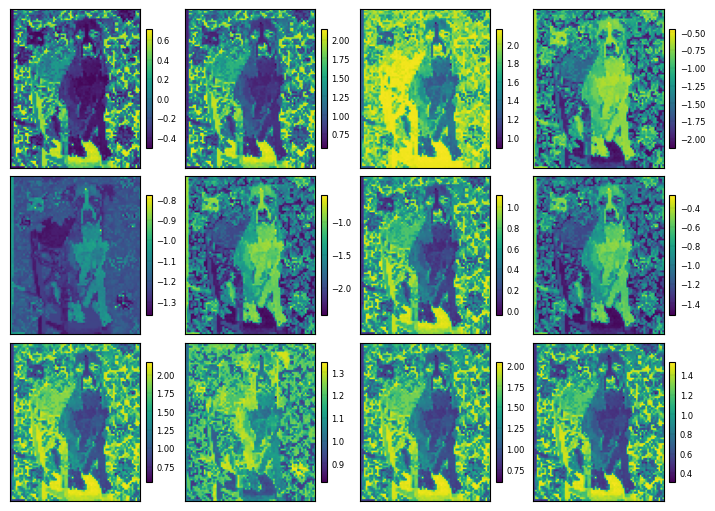

In [34]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


- This does not really mean too much because the latent variables are all competing with one another


## LSTM Autoencoder with 3 Latent Variables


In [35]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [36]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [37]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [38]:
random_seed(seed=42)

Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 98.98it/s] 


Epoch 0, Train Loss: 2.0366
.............................


100%|██████████| 19/19 [00:00<00:00, 83.40it/s]


Epoch 1, Train Loss: 2.0331
.............................


100%|██████████| 19/19 [00:00<00:00, 76.68it/s]


Epoch 2, Train Loss: 2.0296
.............................


100%|██████████| 19/19 [00:00<00:00, 79.62it/s]


Epoch 3, Train Loss: 2.0262
.............................


100%|██████████| 19/19 [00:00<00:00, 81.95it/s]


Epoch 4, Train Loss: 2.0227
.............................


100%|██████████| 19/19 [00:00<00:00, 92.91it/s] 


Epoch 5, Train Loss: 2.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 100.77it/s]


Epoch 6, Train Loss: 2.0158
.............................


100%|██████████| 19/19 [00:00<00:00, 105.71it/s]


Epoch 7, Train Loss: 2.0124
.............................


100%|██████████| 19/19 [00:00<00:00, 92.38it/s]


Epoch 8, Train Loss: 2.0089
.............................


100%|██████████| 19/19 [00:00<00:00, 96.03it/s]


Epoch 9, Train Loss: 2.0054
.............................


100%|██████████| 19/19 [00:00<00:00, 93.26it/s] 


Epoch 10, Train Loss: 2.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 105.33it/s]


Epoch 11, Train Loss: 1.9984
.............................


100%|██████████| 19/19 [00:00<00:00, 110.67it/s]


Epoch 12, Train Loss: 1.9948
.............................


100%|██████████| 19/19 [00:00<00:00, 113.51it/s]


Epoch 13, Train Loss: 1.9912
.............................


100%|██████████| 19/19 [00:00<00:00, 116.89it/s]


Epoch 14, Train Loss: 1.9876
.............................


100%|██████████| 19/19 [00:00<00:00, 124.86it/s]


Epoch 15, Train Loss: 1.9839
.............................


100%|██████████| 19/19 [00:00<00:00, 114.41it/s]


Epoch 16, Train Loss: 1.9801
.............................


100%|██████████| 19/19 [00:00<00:00, 110.74it/s]


Epoch 17, Train Loss: 1.9763
.............................


100%|██████████| 19/19 [00:00<00:00, 111.96it/s]


Epoch 18, Train Loss: 1.9725
.............................


100%|██████████| 19/19 [00:00<00:00, 111.57it/s]


Epoch 19, Train Loss: 1.9685
.............................


100%|██████████| 19/19 [00:00<00:00, 101.21it/s]


Epoch 20, Train Loss: 1.9645
.............................


100%|██████████| 19/19 [00:00<00:00, 92.81it/s]


Epoch 21, Train Loss: 1.9604
.............................


100%|██████████| 19/19 [00:00<00:00, 91.89it/s]


Epoch 22, Train Loss: 1.9562
.............................


100%|██████████| 19/19 [00:00<00:00, 95.25it/s]


Epoch 23, Train Loss: 1.9519
.............................


100%|██████████| 19/19 [00:00<00:00, 105.40it/s]


Epoch 24, Train Loss: 1.9476
.............................


100%|██████████| 19/19 [00:00<00:00, 105.07it/s]


Epoch 25, Train Loss: 1.9431
.............................


100%|██████████| 19/19 [00:00<00:00, 109.15it/s]


Epoch 26, Train Loss: 1.9384
.............................


100%|██████████| 19/19 [00:00<00:00, 104.25it/s]


Epoch 27, Train Loss: 1.9337
.............................


100%|██████████| 19/19 [00:00<00:00, 101.70it/s]


Epoch 28, Train Loss: 1.9288
.............................


100%|██████████| 19/19 [00:00<00:00, 84.62it/s]


Epoch 29, Train Loss: 1.9238
.............................


100%|██████████| 19/19 [00:00<00:00, 94.26it/s]


Epoch 30, Train Loss: 1.9186
.............................


100%|██████████| 19/19 [00:00<00:00, 123.38it/s]


Epoch 31, Train Loss: 1.9133
.............................


100%|██████████| 19/19 [00:00<00:00, 153.44it/s]


Epoch 32, Train Loss: 1.9077
.............................


100%|██████████| 19/19 [00:00<00:00, 170.25it/s]


Epoch 33, Train Loss: 1.9021
.............................


100%|██████████| 19/19 [00:00<00:00, 177.30it/s]


Epoch 34, Train Loss: 1.8962
.............................


100%|██████████| 19/19 [00:00<00:00, 170.84it/s]


Epoch 35, Train Loss: 1.8901
.............................


100%|██████████| 19/19 [00:00<00:00, 201.42it/s]


Epoch 36, Train Loss: 1.8838
.............................


100%|██████████| 19/19 [00:00<00:00, 204.46it/s]


Epoch 37, Train Loss: 1.8773
.............................


100%|██████████| 19/19 [00:00<00:00, 173.98it/s]


Epoch 38, Train Loss: 1.8705
.............................


100%|██████████| 19/19 [00:00<00:00, 196.99it/s]


Epoch 39, Train Loss: 1.8635
.............................


100%|██████████| 19/19 [00:00<00:00, 208.44it/s]


Epoch 40, Train Loss: 1.8563
.............................


100%|██████████| 19/19 [00:00<00:00, 197.60it/s]


Epoch 41, Train Loss: 1.8487
.............................


100%|██████████| 19/19 [00:00<00:00, 202.43it/s]


Epoch 42, Train Loss: 1.8409
.............................


100%|██████████| 19/19 [00:00<00:00, 195.85it/s]


Epoch 43, Train Loss: 1.8328
.............................


100%|██████████| 19/19 [00:00<00:00, 185.36it/s]


Epoch 44, Train Loss: 1.8244
.............................


100%|██████████| 19/19 [00:00<00:00, 183.52it/s]


Epoch 45, Train Loss: 1.8156
.............................


100%|██████████| 19/19 [00:00<00:00, 195.81it/s]


Epoch 46, Train Loss: 1.8065
.............................


100%|██████████| 19/19 [00:00<00:00, 198.56it/s]


Epoch 47, Train Loss: 1.7971
.............................


100%|██████████| 19/19 [00:00<00:00, 201.54it/s]


Epoch 48, Train Loss: 1.7872
.............................


100%|██████████| 19/19 [00:00<00:00, 176.12it/s]


Epoch 49, Train Loss: 1.7770
.............................


100%|██████████| 19/19 [00:00<00:00, 191.85it/s]


Epoch 50, Train Loss: 1.7664
.............................


100%|██████████| 19/19 [00:00<00:00, 167.42it/s]


Epoch 51, Train Loss: 1.7553
.............................


100%|██████████| 19/19 [00:00<00:00, 197.89it/s]


Epoch 52, Train Loss: 1.7437
.............................


100%|██████████| 19/19 [00:00<00:00, 184.27it/s]


Epoch 53, Train Loss: 1.7317
.............................


100%|██████████| 19/19 [00:00<00:00, 189.02it/s]


Epoch 54, Train Loss: 1.7192
.............................


100%|██████████| 19/19 [00:00<00:00, 184.07it/s]


Epoch 55, Train Loss: 1.7062
.............................


100%|██████████| 19/19 [00:00<00:00, 192.23it/s]


Epoch 56, Train Loss: 1.6927
.............................


100%|██████████| 19/19 [00:00<00:00, 195.00it/s]


Epoch 57, Train Loss: 1.6786
.............................


100%|██████████| 19/19 [00:00<00:00, 151.14it/s]


Epoch 58, Train Loss: 1.6640
.............................


100%|██████████| 19/19 [00:00<00:00, 156.11it/s]


Epoch 59, Train Loss: 1.6488
.............................


100%|██████████| 19/19 [00:00<00:00, 156.53it/s]


Epoch 60, Train Loss: 1.6331
.............................


100%|██████████| 19/19 [00:00<00:00, 187.40it/s]


Epoch 61, Train Loss: 1.6169
.............................


100%|██████████| 19/19 [00:00<00:00, 193.07it/s]


Epoch 62, Train Loss: 1.6002
.............................


100%|██████████| 19/19 [00:00<00:00, 181.54it/s]


Epoch 63, Train Loss: 1.5830
.............................


100%|██████████| 19/19 [00:00<00:00, 198.62it/s]


Epoch 64, Train Loss: 1.5653
.............................


100%|██████████| 19/19 [00:00<00:00, 186.72it/s]


Epoch 65, Train Loss: 1.5472
.............................


100%|██████████| 19/19 [00:00<00:00, 208.78it/s]


Epoch 66, Train Loss: 1.5287
.............................


100%|██████████| 19/19 [00:00<00:00, 214.03it/s]


Epoch 67, Train Loss: 1.5099
.............................


100%|██████████| 19/19 [00:00<00:00, 171.28it/s]


Epoch 68, Train Loss: 1.4908
.............................


100%|██████████| 19/19 [00:00<00:00, 174.85it/s]


Epoch 69, Train Loss: 1.4715
.............................


100%|██████████| 19/19 [00:00<00:00, 179.81it/s]


Epoch 70, Train Loss: 1.4519
.............................


100%|██████████| 19/19 [00:00<00:00, 179.36it/s]


Epoch 71, Train Loss: 1.4322
.............................


100%|██████████| 19/19 [00:00<00:00, 167.49it/s]


Epoch 72, Train Loss: 1.4124
.............................


100%|██████████| 19/19 [00:00<00:00, 171.14it/s]


Epoch 73, Train Loss: 1.3925
.............................


100%|██████████| 19/19 [00:00<00:00, 186.73it/s]


Epoch 74, Train Loss: 1.3726
.............................


100%|██████████| 19/19 [00:00<00:00, 194.30it/s]


Epoch 75, Train Loss: 1.3526
.............................


100%|██████████| 19/19 [00:00<00:00, 186.74it/s]


Epoch 76, Train Loss: 1.3327
.............................


100%|██████████| 19/19 [00:00<00:00, 186.72it/s]


Epoch 77, Train Loss: 1.3128
.............................


100%|██████████| 19/19 [00:00<00:00, 198.50it/s]


Epoch 78, Train Loss: 1.2929
.............................


100%|██████████| 19/19 [00:00<00:00, 172.80it/s]


Epoch 79, Train Loss: 1.2731
.............................


100%|██████████| 19/19 [00:00<00:00, 178.74it/s]


Epoch 80, Train Loss: 1.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 187.89it/s]


Epoch 81, Train Loss: 1.2337
.............................


100%|██████████| 19/19 [00:00<00:00, 173.29it/s]


Epoch 82, Train Loss: 1.2141
.............................


100%|██████████| 19/19 [00:00<00:00, 196.85it/s]


Epoch 83, Train Loss: 1.1946
.............................


100%|██████████| 19/19 [00:00<00:00, 200.81it/s]


Epoch 84, Train Loss: 1.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 199.93it/s]


Epoch 85, Train Loss: 1.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 207.72it/s]


Epoch 86, Train Loss: 1.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 162.36it/s]


Epoch 87, Train Loss: 1.1172
.............................


100%|██████████| 19/19 [00:00<00:00, 146.81it/s]


Epoch 88, Train Loss: 1.0979
.............................


100%|██████████| 19/19 [00:00<00:00, 138.96it/s]


Epoch 89, Train Loss: 1.0786
.............................


100%|██████████| 19/19 [00:00<00:00, 150.99it/s]


Epoch 90, Train Loss: 1.0593
.............................


100%|██████████| 19/19 [00:00<00:00, 164.49it/s]


Epoch 91, Train Loss: 1.0400
.............................


100%|██████████| 19/19 [00:00<00:00, 190.46it/s]


Epoch 92, Train Loss: 1.0206
.............................


100%|██████████| 19/19 [00:00<00:00, 190.96it/s]


Epoch 93, Train Loss: 1.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 204.43it/s]


Epoch 94, Train Loss: 0.9814
.............................


100%|██████████| 19/19 [00:00<00:00, 203.73it/s]


Epoch 95, Train Loss: 0.9616
.............................


100%|██████████| 19/19 [00:00<00:00, 182.92it/s]


Epoch 96, Train Loss: 0.9417
.............................


100%|██████████| 19/19 [00:00<00:00, 178.04it/s]


Epoch 97, Train Loss: 0.9216
.............................


100%|██████████| 19/19 [00:00<00:00, 188.53it/s]


Epoch 98, Train Loss: 0.9012
.............................


100%|██████████| 19/19 [00:00<00:00, 207.10it/s]


Epoch 99, Train Loss: 0.8807
.............................


100%|██████████| 19/19 [00:00<00:00, 171.17it/s]


Epoch 100, Train Loss: 0.8600
.............................


100%|██████████| 19/19 [00:00<00:00, 195.02it/s]


Epoch 101, Train Loss: 0.8391
.............................


100%|██████████| 19/19 [00:00<00:00, 194.22it/s]


Epoch 102, Train Loss: 0.8181
.............................


100%|██████████| 19/19 [00:00<00:00, 177.11it/s]


Epoch 103, Train Loss: 0.7968
.............................


100%|██████████| 19/19 [00:00<00:00, 171.29it/s]


Epoch 104, Train Loss: 0.7754
.............................


100%|██████████| 19/19 [00:00<00:00, 154.41it/s]


Epoch 105, Train Loss: 0.7539
.............................


100%|██████████| 19/19 [00:00<00:00, 146.69it/s]


Epoch 106, Train Loss: 0.7324
.............................


100%|██████████| 19/19 [00:00<00:00, 152.12it/s]


Epoch 107, Train Loss: 0.7108
.............................


100%|██████████| 19/19 [00:00<00:00, 159.53it/s]


Epoch 108, Train Loss: 0.6893
.............................


100%|██████████| 19/19 [00:00<00:00, 187.00it/s]


Epoch 109, Train Loss: 0.6680
.............................


100%|██████████| 19/19 [00:00<00:00, 178.59it/s]


Epoch 110, Train Loss: 0.6468
.............................


100%|██████████| 19/19 [00:00<00:00, 197.91it/s]


Epoch 111, Train Loss: 0.6259
.............................


100%|██████████| 19/19 [00:00<00:00, 209.04it/s]


Epoch 112, Train Loss: 0.6053
.............................


100%|██████████| 19/19 [00:00<00:00, 192.71it/s]


Epoch 113, Train Loss: 0.5853
.............................


100%|██████████| 19/19 [00:00<00:00, 193.13it/s]


Epoch 114, Train Loss: 0.5657
.............................


100%|██████████| 19/19 [00:00<00:00, 196.89it/s]


Epoch 115, Train Loss: 0.5467
.............................


100%|██████████| 19/19 [00:00<00:00, 197.33it/s]


Epoch 116, Train Loss: 0.5284
.............................


100%|██████████| 19/19 [00:00<00:00, 162.00it/s]


Epoch 117, Train Loss: 0.5108
.............................


100%|██████████| 19/19 [00:00<00:00, 159.62it/s]


Epoch 118, Train Loss: 0.4939
.............................


100%|██████████| 19/19 [00:00<00:00, 180.82it/s]


Epoch 119, Train Loss: 0.4779
.............................


100%|██████████| 19/19 [00:00<00:00, 183.43it/s]


Epoch 120, Train Loss: 0.4626
.............................


100%|██████████| 19/19 [00:00<00:00, 169.81it/s]


Epoch 121, Train Loss: 0.4482
.............................


100%|██████████| 19/19 [00:00<00:00, 205.11it/s]


Epoch 122, Train Loss: 0.4346
.............................


100%|██████████| 19/19 [00:00<00:00, 177.89it/s]


Epoch 123, Train Loss: 0.4218
.............................


100%|██████████| 19/19 [00:00<00:00, 193.79it/s]


Epoch 124, Train Loss: 0.4097
.............................


100%|██████████| 19/19 [00:00<00:00, 181.09it/s]


Epoch 125, Train Loss: 0.3984
.............................


100%|██████████| 19/19 [00:00<00:00, 173.86it/s]


Epoch 126, Train Loss: 0.3878
.............................


100%|██████████| 19/19 [00:00<00:00, 173.02it/s]


Epoch 127, Train Loss: 0.3778
.............................


100%|██████████| 19/19 [00:00<00:00, 180.94it/s]


Epoch 128, Train Loss: 0.3685
.............................


100%|██████████| 19/19 [00:00<00:00, 183.28it/s]


Epoch 129, Train Loss: 0.3597
.............................


100%|██████████| 19/19 [00:00<00:00, 187.26it/s]


Epoch 130, Train Loss: 0.3515
.............................


100%|██████████| 19/19 [00:00<00:00, 191.71it/s]


Epoch 131, Train Loss: 0.3438
.............................


100%|██████████| 19/19 [00:00<00:00, 177.14it/s]


Epoch 132, Train Loss: 0.3365
.............................


100%|██████████| 19/19 [00:00<00:00, 202.78it/s]


Epoch 133, Train Loss: 0.3297
.............................


100%|██████████| 19/19 [00:00<00:00, 198.58it/s]


Epoch 134, Train Loss: 0.3232
.............................


100%|██████████| 19/19 [00:00<00:00, 175.24it/s]


Epoch 135, Train Loss: 0.3171
.............................


100%|██████████| 19/19 [00:00<00:00, 174.53it/s]


Epoch 136, Train Loss: 0.3114
.............................


100%|██████████| 19/19 [00:00<00:00, 191.86it/s]


Epoch 137, Train Loss: 0.3060
.............................


100%|██████████| 19/19 [00:00<00:00, 188.32it/s]


Epoch 138, Train Loss: 0.3009
.............................


100%|██████████| 19/19 [00:00<00:00, 173.97it/s]


Epoch 139, Train Loss: 0.2961
.............................


100%|██████████| 19/19 [00:00<00:00, 198.37it/s]


Epoch 140, Train Loss: 0.2915
.............................


100%|██████████| 19/19 [00:00<00:00, 191.18it/s]


Epoch 141, Train Loss: 0.2872
.............................


100%|██████████| 19/19 [00:00<00:00, 195.49it/s]


Epoch 142, Train Loss: 0.2831
.............................


100%|██████████| 19/19 [00:00<00:00, 184.50it/s]


Epoch 143, Train Loss: 0.2792
.............................


100%|██████████| 19/19 [00:00<00:00, 152.88it/s]


Epoch 144, Train Loss: 0.2756
.............................


100%|██████████| 19/19 [00:00<00:00, 182.91it/s]


Epoch 145, Train Loss: 0.2721
.............................


100%|██████████| 19/19 [00:00<00:00, 167.99it/s]


Epoch 146, Train Loss: 0.2688
.............................


100%|██████████| 19/19 [00:00<00:00, 174.73it/s]


Epoch 147, Train Loss: 0.2657
.............................


100%|██████████| 19/19 [00:00<00:00, 173.96it/s]


Epoch 148, Train Loss: 0.2628
.............................


100%|██████████| 19/19 [00:00<00:00, 178.19it/s]


Epoch 149, Train Loss: 0.2600
.............................


100%|██████████| 19/19 [00:00<00:00, 181.67it/s]


Epoch 150, Train Loss: 0.2574
.............................


100%|██████████| 19/19 [00:00<00:00, 169.84it/s]


Epoch 151, Train Loss: 0.2549
.............................


100%|██████████| 19/19 [00:00<00:00, 167.69it/s]


Epoch 152, Train Loss: 0.2525
.............................


100%|██████████| 19/19 [00:00<00:00, 158.32it/s]


Epoch 153, Train Loss: 0.2502
.............................


100%|██████████| 19/19 [00:00<00:00, 180.83it/s]


Epoch 154, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 154.12it/s]


Epoch 155, Train Loss: 0.2461
.............................


100%|██████████| 19/19 [00:00<00:00, 166.54it/s]


Epoch 156, Train Loss: 0.2441
.............................


100%|██████████| 19/19 [00:00<00:00, 178.13it/s]


Epoch 157, Train Loss: 0.2423
.............................


100%|██████████| 19/19 [00:00<00:00, 195.97it/s]


Epoch 158, Train Loss: 0.2405
.............................


100%|██████████| 19/19 [00:00<00:00, 181.18it/s]


Epoch 159, Train Loss: 0.2389
.............................


100%|██████████| 19/19 [00:00<00:00, 192.87it/s]


Epoch 160, Train Loss: 0.2373
.............................


100%|██████████| 19/19 [00:00<00:00, 191.60it/s]


Epoch 161, Train Loss: 0.2358
.............................


100%|██████████| 19/19 [00:00<00:00, 181.25it/s]


Epoch 162, Train Loss: 0.2343
.............................


100%|██████████| 19/19 [00:00<00:00, 170.07it/s]


Epoch 163, Train Loss: 0.2329
.............................


100%|██████████| 19/19 [00:00<00:00, 156.11it/s]


Epoch 164, Train Loss: 0.2316
.............................


100%|██████████| 19/19 [00:00<00:00, 165.41it/s]


Epoch 165, Train Loss: 0.2303
.............................


100%|██████████| 19/19 [00:00<00:00, 169.98it/s]


Epoch 166, Train Loss: 0.2291
.............................


100%|██████████| 19/19 [00:00<00:00, 168.40it/s]


Epoch 167, Train Loss: 0.2280
.............................


100%|██████████| 19/19 [00:00<00:00, 173.29it/s]


Epoch 168, Train Loss: 0.2269
.............................


100%|██████████| 19/19 [00:00<00:00, 168.46it/s]


Epoch 169, Train Loss: 0.2258
.............................


100%|██████████| 19/19 [00:00<00:00, 193.39it/s]


Epoch 170, Train Loss: 0.2248
.............................


100%|██████████| 19/19 [00:00<00:00, 198.66it/s]


Epoch 171, Train Loss: 0.2238
.............................


100%|██████████| 19/19 [00:00<00:00, 172.59it/s]


Epoch 172, Train Loss: 0.2228
.............................


100%|██████████| 19/19 [00:00<00:00, 174.19it/s]


Epoch 173, Train Loss: 0.2219
.............................


100%|██████████| 19/19 [00:00<00:00, 162.05it/s]


Epoch 174, Train Loss: 0.2210
.............................


100%|██████████| 19/19 [00:00<00:00, 168.31it/s]


Epoch 175, Train Loss: 0.2201
.............................


100%|██████████| 19/19 [00:00<00:00, 176.71it/s]


Epoch 176, Train Loss: 0.2193
.............................


100%|██████████| 19/19 [00:00<00:00, 200.31it/s]


Epoch 177, Train Loss: 0.2185
.............................


100%|██████████| 19/19 [00:00<00:00, 186.33it/s]


Epoch 178, Train Loss: 0.2177
.............................


100%|██████████| 19/19 [00:00<00:00, 205.36it/s]


Epoch 179, Train Loss: 0.2169
.............................


100%|██████████| 19/19 [00:00<00:00, 202.68it/s]


Epoch 180, Train Loss: 0.2162
.............................


100%|██████████| 19/19 [00:00<00:00, 174.78it/s]


Epoch 181, Train Loss: 0.2155
.............................


100%|██████████| 19/19 [00:00<00:00, 161.54it/s]


Epoch 182, Train Loss: 0.2147
.............................


100%|██████████| 19/19 [00:00<00:00, 134.88it/s]


Epoch 183, Train Loss: 0.2140
.............................


100%|██████████| 19/19 [00:00<00:00, 144.37it/s]


Epoch 184, Train Loss: 0.2134
.............................


100%|██████████| 19/19 [00:00<00:00, 182.79it/s]


Epoch 185, Train Loss: 0.2127
.............................


100%|██████████| 19/19 [00:00<00:00, 185.88it/s]


Epoch 186, Train Loss: 0.2120
.............................


100%|██████████| 19/19 [00:00<00:00, 192.18it/s]


Epoch 187, Train Loss: 0.2114
.............................


100%|██████████| 19/19 [00:00<00:00, 194.57it/s]


Epoch 188, Train Loss: 0.2108
.............................


100%|██████████| 19/19 [00:00<00:00, 213.68it/s]


Epoch 189, Train Loss: 0.2101
.............................


100%|██████████| 19/19 [00:00<00:00, 189.07it/s]


Epoch 190, Train Loss: 0.2095
.............................


100%|██████████| 19/19 [00:00<00:00, 206.77it/s]


Epoch 191, Train Loss: 0.2089
.............................


100%|██████████| 19/19 [00:00<00:00, 147.56it/s]


Epoch 192, Train Loss: 0.2083
.............................


100%|██████████| 19/19 [00:00<00:00, 149.14it/s]


Epoch 193, Train Loss: 0.2078
.............................


100%|██████████| 19/19 [00:00<00:00, 181.51it/s]


Epoch 194, Train Loss: 0.2072
.............................


100%|██████████| 19/19 [00:00<00:00, 182.89it/s]


Epoch 195, Train Loss: 0.2066
.............................


100%|██████████| 19/19 [00:00<00:00, 156.93it/s]


Epoch 196, Train Loss: 0.2061
.............................


100%|██████████| 19/19 [00:00<00:00, 154.60it/s]


Epoch 197, Train Loss: 0.2055
.............................


100%|██████████| 19/19 [00:00<00:00, 178.72it/s]


Epoch 198, Train Loss: 0.2049
.............................


100%|██████████| 19/19 [00:00<00:00, 153.44it/s]


Epoch 199, Train Loss: 0.2044
.............................


100%|██████████| 19/19 [00:00<00:00, 184.77it/s]


Epoch 200, Train Loss: 0.2039
.............................


100%|██████████| 19/19 [00:00<00:00, 150.25it/s]


Epoch 201, Train Loss: 0.2033
.............................


100%|██████████| 19/19 [00:00<00:00, 160.85it/s]


Epoch 202, Train Loss: 0.2028
.............................


100%|██████████| 19/19 [00:00<00:00, 184.86it/s]


Epoch 203, Train Loss: 0.2023
.............................


100%|██████████| 19/19 [00:00<00:00, 190.12it/s]


Epoch 204, Train Loss: 0.2018
.............................


100%|██████████| 19/19 [00:00<00:00, 194.82it/s]


Epoch 205, Train Loss: 0.2013
.............................


100%|██████████| 19/19 [00:00<00:00, 194.28it/s]


Epoch 206, Train Loss: 0.2008
.............................


100%|██████████| 19/19 [00:00<00:00, 197.90it/s]


Epoch 207, Train Loss: 0.2002
.............................


100%|██████████| 19/19 [00:00<00:00, 179.55it/s]


Epoch 208, Train Loss: 0.1998
.............................


100%|██████████| 19/19 [00:00<00:00, 174.50it/s]


Epoch 209, Train Loss: 0.1993
.............................


100%|██████████| 19/19 [00:00<00:00, 170.78it/s]


Epoch 210, Train Loss: 0.1988
.............................


100%|██████████| 19/19 [00:00<00:00, 164.08it/s]


Epoch 211, Train Loss: 0.1983
.............................


100%|██████████| 19/19 [00:00<00:00, 182.44it/s]


Epoch 212, Train Loss: 0.1978
.............................


100%|██████████| 19/19 [00:00<00:00, 192.21it/s]


Epoch 213, Train Loss: 0.1973
.............................


100%|██████████| 19/19 [00:00<00:00, 205.51it/s]


Epoch 214, Train Loss: 0.1968
.............................


100%|██████████| 19/19 [00:00<00:00, 207.57it/s]


Epoch 215, Train Loss: 0.1964
.............................


100%|██████████| 19/19 [00:00<00:00, 218.26it/s]


Epoch 216, Train Loss: 0.1959
.............................


100%|██████████| 19/19 [00:00<00:00, 202.00it/s]


Epoch 217, Train Loss: 0.1955
.............................


100%|██████████| 19/19 [00:00<00:00, 193.71it/s]


Epoch 218, Train Loss: 0.1950
.............................


100%|██████████| 19/19 [00:00<00:00, 184.26it/s]


Epoch 219, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 169.51it/s]


Epoch 220, Train Loss: 0.1941
.............................


100%|██████████| 19/19 [00:00<00:00, 169.56it/s]


Epoch 221, Train Loss: 0.1936
.............................


100%|██████████| 19/19 [00:00<00:00, 191.29it/s]


Epoch 222, Train Loss: 0.1932
.............................


100%|██████████| 19/19 [00:00<00:00, 185.47it/s]


Epoch 223, Train Loss: 0.1928
.............................


100%|██████████| 19/19 [00:00<00:00, 193.31it/s]


Epoch 224, Train Loss: 0.1923
.............................


100%|██████████| 19/19 [00:00<00:00, 201.94it/s]


Epoch 225, Train Loss: 0.1919
.............................


100%|██████████| 19/19 [00:00<00:00, 188.54it/s]


Epoch 226, Train Loss: 0.1915
.............................


100%|██████████| 19/19 [00:00<00:00, 159.39it/s]


Epoch 227, Train Loss: 0.1910
.............................


100%|██████████| 19/19 [00:00<00:00, 172.66it/s]


Epoch 228, Train Loss: 0.1906
.............................


100%|██████████| 19/19 [00:00<00:00, 173.19it/s]


Epoch 229, Train Loss: 0.1902
.............................


100%|██████████| 19/19 [00:00<00:00, 157.47it/s]


Epoch 230, Train Loss: 0.1898
.............................


100%|██████████| 19/19 [00:00<00:00, 182.84it/s]


Epoch 231, Train Loss: 0.1894
.............................


100%|██████████| 19/19 [00:00<00:00, 209.72it/s]


Epoch 232, Train Loss: 0.1889
.............................


100%|██████████| 19/19 [00:00<00:00, 154.28it/s]


Epoch 233, Train Loss: 0.1885
.............................


100%|██████████| 19/19 [00:00<00:00, 191.62it/s]


Epoch 234, Train Loss: 0.1881
.............................


100%|██████████| 19/19 [00:00<00:00, 183.19it/s]


Epoch 235, Train Loss: 0.1877
.............................


100%|██████████| 19/19 [00:00<00:00, 190.63it/s]


Epoch 236, Train Loss: 0.1873
.............................


100%|██████████| 19/19 [00:00<00:00, 185.58it/s]


Epoch 237, Train Loss: 0.1869
.............................


100%|██████████| 19/19 [00:00<00:00, 190.54it/s]


Epoch 238, Train Loss: 0.1865
.............................


100%|██████████| 19/19 [00:00<00:00, 152.60it/s]


Epoch 239, Train Loss: 0.1861
.............................


100%|██████████| 19/19 [00:00<00:00, 159.70it/s]


Epoch 240, Train Loss: 0.1858
.............................


100%|██████████| 19/19 [00:00<00:00, 151.56it/s]


Epoch 241, Train Loss: 0.1854
.............................


100%|██████████| 19/19 [00:00<00:00, 163.03it/s]


Epoch 242, Train Loss: 0.1850
.............................


100%|██████████| 19/19 [00:00<00:00, 166.30it/s]


Epoch 243, Train Loss: 0.1846
.............................


100%|██████████| 19/19 [00:00<00:00, 185.39it/s]


Epoch 244, Train Loss: 0.1842
.............................


100%|██████████| 19/19 [00:00<00:00, 168.71it/s]


Epoch 245, Train Loss: 0.1838
.............................


100%|██████████| 19/19 [00:00<00:00, 172.82it/s]


Epoch 246, Train Loss: 0.1835
.............................


100%|██████████| 19/19 [00:00<00:00, 151.23it/s]


Epoch 247, Train Loss: 0.1831
.............................


100%|██████████| 19/19 [00:00<00:00, 142.49it/s]


Epoch 248, Train Loss: 0.1827
.............................


100%|██████████| 19/19 [00:00<00:00, 176.55it/s]


Epoch 249, Train Loss: 0.1823
.............................


100%|██████████| 19/19 [00:00<00:00, 182.03it/s]


Epoch 250, Train Loss: 0.1820
.............................


100%|██████████| 19/19 [00:00<00:00, 199.38it/s]


Epoch 251, Train Loss: 0.1816
.............................


100%|██████████| 19/19 [00:00<00:00, 192.58it/s]


Epoch 252, Train Loss: 0.1812
.............................


100%|██████████| 19/19 [00:00<00:00, 183.49it/s]


Epoch 253, Train Loss: 0.1809
.............................


100%|██████████| 19/19 [00:00<00:00, 165.74it/s]


Epoch 254, Train Loss: 0.1805
.............................


100%|██████████| 19/19 [00:00<00:00, 187.80it/s]


Epoch 255, Train Loss: 0.1802
.............................


100%|██████████| 19/19 [00:00<00:00, 149.65it/s]


Epoch 256, Train Loss: 0.1798
.............................


100%|██████████| 19/19 [00:00<00:00, 149.39it/s]


Epoch 257, Train Loss: 0.1794
.............................


100%|██████████| 19/19 [00:00<00:00, 175.78it/s]


Epoch 258, Train Loss: 0.1791
.............................


100%|██████████| 19/19 [00:00<00:00, 191.23it/s]


Epoch 259, Train Loss: 0.1787
.............................


100%|██████████| 19/19 [00:00<00:00, 194.48it/s]


Epoch 260, Train Loss: 0.1784
.............................


100%|██████████| 19/19 [00:00<00:00, 190.51it/s]


Epoch 261, Train Loss: 0.1780
.............................


100%|██████████| 19/19 [00:00<00:00, 159.35it/s]


Epoch 262, Train Loss: 0.1777
.............................


100%|██████████| 19/19 [00:00<00:00, 186.95it/s]


Epoch 263, Train Loss: 0.1773
.............................


100%|██████████| 19/19 [00:00<00:00, 158.95it/s]


Epoch 264, Train Loss: 0.1770
.............................


100%|██████████| 19/19 [00:00<00:00, 153.59it/s]


Epoch 265, Train Loss: 0.1766
.............................


100%|██████████| 19/19 [00:00<00:00, 157.77it/s]


Epoch 266, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 191.78it/s]


Epoch 267, Train Loss: 0.1759
.............................


100%|██████████| 19/19 [00:00<00:00, 192.18it/s]


Epoch 268, Train Loss: 0.1756
.............................


100%|██████████| 19/19 [00:00<00:00, 202.27it/s]


Epoch 269, Train Loss: 0.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 205.48it/s]


Epoch 270, Train Loss: 0.1749
.............................


100%|██████████| 19/19 [00:00<00:00, 186.38it/s]


Epoch 271, Train Loss: 0.1746
.............................


100%|██████████| 19/19 [00:00<00:00, 198.93it/s]


Epoch 272, Train Loss: 0.1742
.............................


100%|██████████| 19/19 [00:00<00:00, 188.98it/s]


Epoch 273, Train Loss: 0.1739
.............................


100%|██████████| 19/19 [00:00<00:00, 180.82it/s]


Epoch 274, Train Loss: 0.1735
.............................


100%|██████████| 19/19 [00:00<00:00, 159.50it/s]


Epoch 275, Train Loss: 0.1732
.............................


100%|██████████| 19/19 [00:00<00:00, 144.14it/s]


Epoch 276, Train Loss: 0.1729
.............................


100%|██████████| 19/19 [00:00<00:00, 167.57it/s]


Epoch 277, Train Loss: 0.1725
.............................


100%|██████████| 19/19 [00:00<00:00, 185.31it/s]


Epoch 278, Train Loss: 0.1722
.............................


100%|██████████| 19/19 [00:00<00:00, 199.33it/s]


Epoch 279, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 193.89it/s]


Epoch 280, Train Loss: 0.1715
.............................


100%|██████████| 19/19 [00:00<00:00, 190.99it/s]


Epoch 281, Train Loss: 0.1712
.............................


100%|██████████| 19/19 [00:00<00:00, 204.04it/s]


Epoch 282, Train Loss: 0.1709
.............................


100%|██████████| 19/19 [00:00<00:00, 187.09it/s]


Epoch 283, Train Loss: 0.1705
.............................


100%|██████████| 19/19 [00:00<00:00, 171.73it/s]


Epoch 284, Train Loss: 0.1702
.............................


100%|██████████| 19/19 [00:00<00:00, 169.92it/s]


Epoch 285, Train Loss: 0.1699
.............................


100%|██████████| 19/19 [00:00<00:00, 160.14it/s]


Epoch 286, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 162.24it/s]


Epoch 287, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 169.49it/s]


Epoch 288, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 185.89it/s]


Epoch 289, Train Loss: 0.1686
.............................


100%|██████████| 19/19 [00:00<00:00, 187.77it/s]


Epoch 290, Train Loss: 0.1682
.............................


100%|██████████| 19/19 [00:00<00:00, 202.55it/s]


Epoch 291, Train Loss: 0.1679
.............................


100%|██████████| 19/19 [00:00<00:00, 193.78it/s]


Epoch 292, Train Loss: 0.1676
.............................


100%|██████████| 19/19 [00:00<00:00, 167.21it/s]


Epoch 293, Train Loss: 0.1673
.............................


100%|██████████| 19/19 [00:00<00:00, 181.64it/s]


Epoch 294, Train Loss: 0.1670
.............................


100%|██████████| 19/19 [00:00<00:00, 164.54it/s]


Epoch 295, Train Loss: 0.1667
.............................


100%|██████████| 19/19 [00:00<00:00, 203.51it/s]


Epoch 296, Train Loss: 0.1663
.............................


100%|██████████| 19/19 [00:00<00:00, 192.01it/s]


Epoch 297, Train Loss: 0.1660
.............................


100%|██████████| 19/19 [00:00<00:00, 158.60it/s]


Epoch 298, Train Loss: 0.1657
.............................


100%|██████████| 19/19 [00:00<00:00, 172.38it/s]


Epoch 299, Train Loss: 0.1654
.............................


100%|██████████| 19/19 [00:00<00:00, 168.49it/s]


Epoch 300, Train Loss: 0.1651
.............................


100%|██████████| 19/19 [00:00<00:00, 177.38it/s]


Epoch 301, Train Loss: 0.1648
.............................


100%|██████████| 19/19 [00:00<00:00, 163.62it/s]


Epoch 302, Train Loss: 0.1645
.............................


100%|██████████| 19/19 [00:00<00:00, 158.74it/s]


Epoch 303, Train Loss: 0.1642
.............................


100%|██████████| 19/19 [00:00<00:00, 161.50it/s]


Epoch 304, Train Loss: 0.1639
.............................


100%|██████████| 19/19 [00:00<00:00, 203.88it/s]


Epoch 305, Train Loss: 0.1636
.............................


100%|██████████| 19/19 [00:00<00:00, 195.11it/s]


Epoch 306, Train Loss: 0.1633
.............................


100%|██████████| 19/19 [00:00<00:00, 195.62it/s]


Epoch 307, Train Loss: 0.1630
.............................


100%|██████████| 19/19 [00:00<00:00, 192.39it/s]


Epoch 308, Train Loss: 0.1627
.............................


100%|██████████| 19/19 [00:00<00:00, 198.75it/s]


Epoch 309, Train Loss: 0.1624
.............................


100%|██████████| 19/19 [00:00<00:00, 209.30it/s]


Epoch 310, Train Loss: 0.1621
.............................


100%|██████████| 19/19 [00:00<00:00, 190.08it/s]


Epoch 311, Train Loss: 0.1618
.............................


100%|██████████| 19/19 [00:00<00:00, 168.94it/s]


Epoch 312, Train Loss: 0.1616
.............................


100%|██████████| 19/19 [00:00<00:00, 171.83it/s]


Epoch 313, Train Loss: 0.1613
.............................


100%|██████████| 19/19 [00:00<00:00, 166.26it/s]


Epoch 314, Train Loss: 0.1610
.............................


100%|██████████| 19/19 [00:00<00:00, 199.63it/s]


Epoch 315, Train Loss: 0.1607
.............................


100%|██████████| 19/19 [00:00<00:00, 187.31it/s]


Epoch 316, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 211.42it/s]


Epoch 317, Train Loss: 0.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 205.64it/s]


Epoch 318, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 204.70it/s]


Epoch 319, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 198.38it/s]


Epoch 320, Train Loss: 0.1593
.............................


100%|██████████| 19/19 [00:00<00:00, 180.65it/s]


Epoch 321, Train Loss: 0.1591
.............................


100%|██████████| 19/19 [00:00<00:00, 169.02it/s]


Epoch 322, Train Loss: 0.1588
.............................


100%|██████████| 19/19 [00:00<00:00, 169.66it/s]


Epoch 323, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 190.15it/s]


Epoch 324, Train Loss: 0.1583
.............................


100%|██████████| 19/19 [00:00<00:00, 180.96it/s]


Epoch 325, Train Loss: 0.1580
.............................


100%|██████████| 19/19 [00:00<00:00, 197.20it/s]


Epoch 326, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 164.76it/s]


Epoch 327, Train Loss: 0.1575
.............................


100%|██████████| 19/19 [00:00<00:00, 171.61it/s]


Epoch 328, Train Loss: 0.1573
.............................


100%|██████████| 19/19 [00:00<00:00, 185.92it/s]


Epoch 329, Train Loss: 0.1570
.............................


100%|██████████| 19/19 [00:00<00:00, 189.57it/s]


Epoch 330, Train Loss: 0.1568
.............................


100%|██████████| 19/19 [00:00<00:00, 178.23it/s]


Epoch 331, Train Loss: 0.1565
.............................


100%|██████████| 19/19 [00:00<00:00, 152.06it/s]


Epoch 332, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 163.97it/s]


Epoch 333, Train Loss: 0.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 171.67it/s]


Epoch 334, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 166.25it/s]


Epoch 335, Train Loss: 0.1556
.............................


100%|██████████| 19/19 [00:00<00:00, 184.35it/s]


Epoch 336, Train Loss: 0.1554
.............................


100%|██████████| 19/19 [00:00<00:00, 193.68it/s]


Epoch 337, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 205.13it/s]


Epoch 338, Train Loss: 0.1549
.............................


100%|██████████| 19/19 [00:00<00:00, 172.12it/s]


Epoch 339, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 176.61it/s]


Epoch 340, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 163.82it/s]


Epoch 341, Train Loss: 0.1542
.............................


100%|██████████| 19/19 [00:00<00:00, 193.03it/s]


Epoch 342, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 160.16it/s]


Epoch 343, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 174.28it/s]


Epoch 344, Train Loss: 0.1536
.............................


100%|██████████| 19/19 [00:00<00:00, 180.52it/s]


Epoch 345, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 174.11it/s]


Epoch 346, Train Loss: 0.1532
.............................


100%|██████████| 19/19 [00:00<00:00, 165.70it/s]


Epoch 347, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 165.01it/s]


Epoch 348, Train Loss: 0.1528
.............................


100%|██████████| 19/19 [00:00<00:00, 152.66it/s]


Epoch 349, Train Loss: 0.1525
.............................


100%|██████████| 19/19 [00:00<00:00, 155.38it/s]


Epoch 350, Train Loss: 0.1523
.............................


100%|██████████| 19/19 [00:00<00:00, 195.23it/s]


Epoch 351, Train Loss: 0.1522
.............................


100%|██████████| 19/19 [00:00<00:00, 160.59it/s]


Epoch 352, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 173.65it/s]


Epoch 353, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 183.84it/s]


Epoch 354, Train Loss: 0.1516
.............................


100%|██████████| 19/19 [00:00<00:00, 206.46it/s]


Epoch 355, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 164.88it/s]


Epoch 356, Train Loss: 0.1512
.............................


100%|██████████| 19/19 [00:00<00:00, 163.60it/s]


Epoch 357, Train Loss: 0.1510
.............................


100%|██████████| 19/19 [00:00<00:00, 186.16it/s]


Epoch 358, Train Loss: 0.1508
.............................


100%|██████████| 19/19 [00:00<00:00, 157.59it/s]


Epoch 359, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 200.05it/s]


Epoch 360, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 170.35it/s]


Epoch 361, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 175.28it/s]


Epoch 362, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 207.26it/s]


Epoch 363, Train Loss: 0.1499
.............................


100%|██████████| 19/19 [00:00<00:00, 210.57it/s]


Epoch 364, Train Loss: 0.1498
.............................


100%|██████████| 19/19 [00:00<00:00, 203.50it/s]


Epoch 365, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 187.01it/s]


Epoch 366, Train Loss: 0.1494
.............................


100%|██████████| 19/19 [00:00<00:00, 167.69it/s]


Epoch 367, Train Loss: 0.1492
.............................


100%|██████████| 19/19 [00:00<00:00, 178.51it/s]


Epoch 368, Train Loss: 0.1491
.............................


100%|██████████| 19/19 [00:00<00:00, 175.39it/s]


Epoch 369, Train Loss: 0.1489
.............................


100%|██████████| 19/19 [00:00<00:00, 191.65it/s]


Epoch 370, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 146.06it/s]


Epoch 371, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 159.83it/s]


Epoch 372, Train Loss: 0.1484
.............................


100%|██████████| 19/19 [00:00<00:00, 173.98it/s]


Epoch 373, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 184.48it/s]


Epoch 374, Train Loss: 0.1481
.............................


100%|██████████| 19/19 [00:00<00:00, 201.96it/s]


Epoch 375, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 175.61it/s]


Epoch 376, Train Loss: 0.1478
.............................


100%|██████████| 19/19 [00:00<00:00, 170.37it/s]


Epoch 377, Train Loss: 0.1476
.............................


100%|██████████| 19/19 [00:00<00:00, 145.01it/s]


Epoch 378, Train Loss: 0.1475
.............................


100%|██████████| 19/19 [00:00<00:00, 156.22it/s]


Epoch 379, Train Loss: 0.1473
.............................


100%|██████████| 19/19 [00:00<00:00, 164.73it/s]


Epoch 380, Train Loss: 0.1472
.............................


100%|██████████| 19/19 [00:00<00:00, 182.23it/s]


Epoch 381, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 196.09it/s]


Epoch 382, Train Loss: 0.1469
.............................


100%|██████████| 19/19 [00:00<00:00, 198.41it/s]


Epoch 383, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 194.92it/s]


Epoch 384, Train Loss: 0.1466
.............................


100%|██████████| 19/19 [00:00<00:00, 169.83it/s]


Epoch 385, Train Loss: 0.1464
.............................


100%|██████████| 19/19 [00:00<00:00, 176.31it/s]


Epoch 386, Train Loss: 0.1463
.............................


100%|██████████| 19/19 [00:00<00:00, 165.44it/s]


Epoch 387, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 155.61it/s]


Epoch 388, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 149.04it/s]


Epoch 389, Train Loss: 0.1459
.............................


100%|██████████| 19/19 [00:00<00:00, 131.36it/s]


Epoch 390, Train Loss: 0.1457
.............................


100%|██████████| 19/19 [00:00<00:00, 115.13it/s]


Epoch 391, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 99.71it/s] 


Epoch 392, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 110.44it/s]


Epoch 393, Train Loss: 0.1453
.............................


100%|██████████| 19/19 [00:00<00:00, 123.69it/s]


Epoch 394, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 139.90it/s]


Epoch 395, Train Loss: 0.1450
.............................


100%|██████████| 19/19 [00:00<00:00, 130.30it/s]


Epoch 396, Train Loss: 0.1449
.............................


100%|██████████| 19/19 [00:00<00:00, 141.09it/s]


Epoch 397, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 157.18it/s]


Epoch 398, Train Loss: 0.1446
.............................


100%|██████████| 19/19 [00:00<00:00, 143.31it/s]


Epoch 399, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 153.43it/s]


Epoch 400, Train Loss: 0.1443
.............................


100%|██████████| 19/19 [00:00<00:00, 161.45it/s]


Epoch 401, Train Loss: 0.1442
.............................


100%|██████████| 19/19 [00:00<00:00, 120.36it/s]


Epoch 402, Train Loss: 0.1441
.............................


100%|██████████| 19/19 [00:00<00:00, 141.07it/s]


Epoch 403, Train Loss: 0.1439
.............................


100%|██████████| 19/19 [00:00<00:00, 156.57it/s]


Epoch 404, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 149.33it/s]


Epoch 405, Train Loss: 0.1437
.............................


100%|██████████| 19/19 [00:00<00:00, 138.22it/s]


Epoch 406, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 146.86it/s]


Epoch 407, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 171.78it/s]


Epoch 408, Train Loss: 0.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 150.46it/s]


Epoch 409, Train Loss: 0.1432
.............................


100%|██████████| 19/19 [00:00<00:00, 143.90it/s]


Epoch 410, Train Loss: 0.1430
.............................


100%|██████████| 19/19 [00:00<00:00, 146.25it/s]


Epoch 411, Train Loss: 0.1429
.............................


100%|██████████| 19/19 [00:00<00:00, 153.56it/s]


Epoch 412, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 153.16it/s]


Epoch 413, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 149.96it/s]


Epoch 414, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 124.52it/s]


Epoch 415, Train Loss: 0.1424
.............................


100%|██████████| 19/19 [00:00<00:00, 141.97it/s]


Epoch 416, Train Loss: 0.1423
.............................


100%|██████████| 19/19 [00:00<00:00, 141.05it/s]


Epoch 417, Train Loss: 0.1421
.............................


100%|██████████| 19/19 [00:00<00:00, 152.71it/s]


Epoch 418, Train Loss: 0.1420
.............................


100%|██████████| 19/19 [00:00<00:00, 155.83it/s]


Epoch 419, Train Loss: 0.1419
.............................


100%|██████████| 19/19 [00:00<00:00, 156.75it/s]


Epoch 420, Train Loss: 0.1418
.............................


100%|██████████| 19/19 [00:00<00:00, 145.06it/s]


Epoch 421, Train Loss: 0.1417
.............................


100%|██████████| 19/19 [00:00<00:00, 143.14it/s]


Epoch 422, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 155.83it/s]


Epoch 423, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 146.80it/s]


Epoch 424, Train Loss: 0.1413
.............................


100%|██████████| 19/19 [00:00<00:00, 150.96it/s]


Epoch 425, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 153.12it/s]


Epoch 426, Train Loss: 0.1410
.............................


100%|██████████| 19/19 [00:00<00:00, 145.40it/s]


Epoch 427, Train Loss: 0.1409
.............................


100%|██████████| 19/19 [00:00<00:00, 147.82it/s]


Epoch 428, Train Loss: 0.1408
.............................


100%|██████████| 19/19 [00:00<00:00, 146.55it/s]


Epoch 429, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 140.02it/s]


Epoch 430, Train Loss: 0.1406
.............................


100%|██████████| 19/19 [00:00<00:00, 151.30it/s]


Epoch 431, Train Loss: 0.1404
.............................


100%|██████████| 19/19 [00:00<00:00, 158.73it/s]


Epoch 432, Train Loss: 0.1403
.............................


100%|██████████| 19/19 [00:00<00:00, 139.67it/s]


Epoch 433, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 139.70it/s]


Epoch 434, Train Loss: 0.1401
.............................


100%|██████████| 19/19 [00:00<00:00, 144.69it/s]


Epoch 435, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 155.49it/s]


Epoch 436, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 146.67it/s]


Epoch 437, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 127.43it/s]


Epoch 438, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 144.17it/s]


Epoch 439, Train Loss: 0.1395
.............................


100%|██████████| 19/19 [00:00<00:00, 144.65it/s]


Epoch 440, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 155.98it/s]


Epoch 441, Train Loss: 0.1393
.............................


100%|██████████| 19/19 [00:00<00:00, 154.77it/s]


Epoch 442, Train Loss: 0.1392
.............................


100%|██████████| 19/19 [00:00<00:00, 165.71it/s]


Epoch 443, Train Loss: 0.1390
.............................


100%|██████████| 19/19 [00:00<00:00, 153.05it/s]


Epoch 444, Train Loss: 0.1389
.............................


100%|██████████| 19/19 [00:00<00:00, 158.96it/s]


Epoch 445, Train Loss: 0.1388
.............................


100%|██████████| 19/19 [00:00<00:00, 148.96it/s]


Epoch 446, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 148.03it/s]


Epoch 447, Train Loss: 0.1386
.............................


100%|██████████| 19/19 [00:00<00:00, 148.27it/s]


Epoch 448, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 136.27it/s]


Epoch 449, Train Loss: 0.1383
.............................


100%|██████████| 19/19 [00:00<00:00, 135.47it/s]


Epoch 450, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 136.15it/s]


Epoch 451, Train Loss: 0.1381
.............................


100%|██████████| 19/19 [00:00<00:00, 128.41it/s]


Epoch 452, Train Loss: 0.1380
.............................


100%|██████████| 19/19 [00:00<00:00, 150.85it/s]


Epoch 453, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 147.15it/s]


Epoch 454, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 158.91it/s]


Epoch 455, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 130.19it/s]


Epoch 456, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 148.27it/s]


Epoch 457, Train Loss: 0.1374
.............................


100%|██████████| 19/19 [00:00<00:00, 164.16it/s]


Epoch 458, Train Loss: 0.1373
.............................


100%|██████████| 19/19 [00:00<00:00, 149.80it/s]


Epoch 459, Train Loss: 0.1372
.............................


100%|██████████| 19/19 [00:00<00:00, 157.54it/s]


Epoch 460, Train Loss: 0.1371
.............................


100%|██████████| 19/19 [00:00<00:00, 158.43it/s]


Epoch 461, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 167.04it/s]


Epoch 462, Train Loss: 0.1369
.............................


100%|██████████| 19/19 [00:00<00:00, 141.60it/s]


Epoch 463, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 141.67it/s]


Epoch 464, Train Loss: 0.1367
.............................


100%|██████████| 19/19 [00:00<00:00, 144.65it/s]


Epoch 465, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 140.14it/s]


Epoch 466, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 133.42it/s]


Epoch 467, Train Loss: 0.1363
.............................


100%|██████████| 19/19 [00:00<00:00, 142.45it/s]


Epoch 468, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 140.58it/s]


Epoch 469, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 147.20it/s]


Epoch 470, Train Loss: 0.1360
.............................


100%|██████████| 19/19 [00:00<00:00, 148.19it/s]


Epoch 471, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 148.62it/s]


Epoch 472, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 139.56it/s]


Epoch 473, Train Loss: 0.1357
.............................


100%|██████████| 19/19 [00:00<00:00, 127.21it/s]


Epoch 474, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 114.85it/s]


Epoch 475, Train Loss: 0.1354
.............................


100%|██████████| 19/19 [00:00<00:00, 103.35it/s]


Epoch 476, Train Loss: 0.1353
.............................


100%|██████████| 19/19 [00:00<00:00, 96.49it/s]


Epoch 477, Train Loss: 0.1352
.............................


100%|██████████| 19/19 [00:00<00:00, 93.55it/s]


Epoch 478, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 83.30it/s]


Epoch 479, Train Loss: 0.1350
.............................


100%|██████████| 19/19 [00:00<00:00, 76.68it/s]


Epoch 480, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 74.58it/s]


Epoch 481, Train Loss: 0.1348
.............................


100%|██████████| 19/19 [00:00<00:00, 79.85it/s]


Epoch 482, Train Loss: 0.1347
.............................


100%|██████████| 19/19 [00:00<00:00, 79.41it/s]


Epoch 483, Train Loss: 0.1346
.............................


100%|██████████| 19/19 [00:00<00:00, 66.84it/s]


Epoch 484, Train Loss: 0.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 63.25it/s]


Epoch 485, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 58.07it/s]


Epoch 486, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 37.97it/s]


Epoch 487, Train Loss: 0.1342
.............................


100%|██████████| 19/19 [00:00<00:00, 63.07it/s]


Epoch 488, Train Loss: 0.1340
.............................


100%|██████████| 19/19 [00:00<00:00, 72.28it/s]


Epoch 489, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 65.18it/s]


Epoch 490, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 64.52it/s]


Epoch 491, Train Loss: 0.1337
.............................


100%|██████████| 19/19 [00:00<00:00, 64.54it/s]


Epoch 492, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 58.48it/s]


Epoch 493, Train Loss: 0.1335
.............................


100%|██████████| 19/19 [00:00<00:00, 62.50it/s]


Epoch 494, Train Loss: 0.1334
.............................


100%|██████████| 19/19 [00:00<00:00, 67.46it/s]


Epoch 495, Train Loss: 0.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 74.42it/s]


Epoch 496, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 71.82it/s]


Epoch 497, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 73.82it/s]


Epoch 498, Train Loss: 0.1330
.............................


100%|██████████| 19/19 [00:00<00:00, 74.63it/s]

Epoch 499, Train Loss: 0.1329
.............................


### Validation


In [39]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


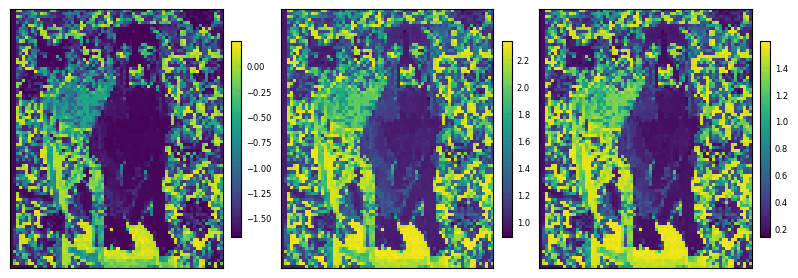

In [40]:
embeddings(encode, shape_=image.shape[0:2], figsize=(10, 5))


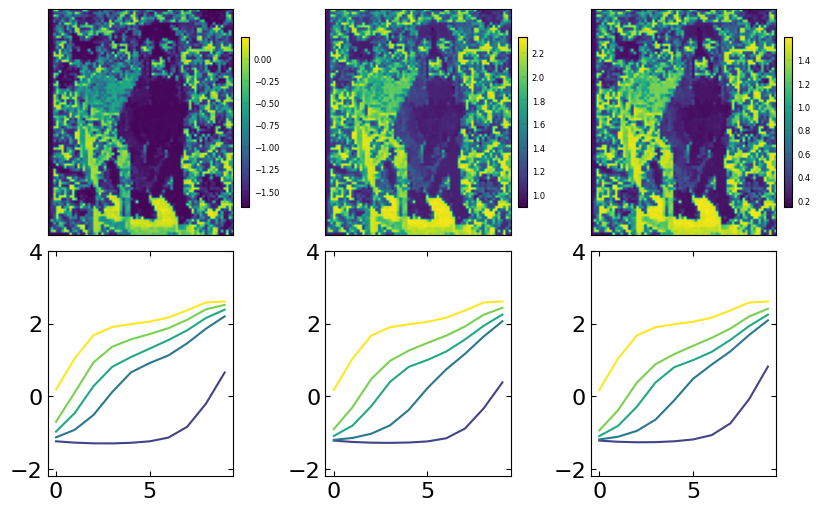

In [41]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(10, 5), divider_=False)


- This once again is very hard to interpret and the spectra do not really contain the necessary details


## Disentanglement

### Regularization

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/L1_reg.png?raw=true)


### Builds the Model


In [42]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [43]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [44]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [45]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [46]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-3, # adds a regularization term l1
    mse=False,
    device=device,
)


100%|██████████| 19/19 [00:00<00:00, 20.90it/s]


Epoch 0, Train Loss: 2.1840
.............................


 11%|█         | 2/19 [00:00<00:01, 16.97it/s]

100%|██████████| 19/19 [00:00<00:00, 21.33it/s]


Epoch 1, Train Loss: 2.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 22.31it/s]


Epoch 2, Train Loss: 2.1666
.............................


100%|██████████| 19/19 [00:00<00:00, 37.26it/s]


Epoch 3, Train Loss: 2.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 48.34it/s]


Epoch 4, Train Loss: 2.1497
.............................


100%|██████████| 19/19 [00:00<00:00, 51.16it/s]


Epoch 5, Train Loss: 2.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 54.41it/s]


Epoch 6, Train Loss: 2.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 47.70it/s]


Epoch 7, Train Loss: 2.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 43.98it/s]


Epoch 8, Train Loss: 2.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 35.24it/s]


Epoch 9, Train Loss: 2.1088
.............................


100%|██████████| 19/19 [00:00<00:00, 41.52it/s]


Epoch 10, Train Loss: 2.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 47.08it/s]


Epoch 11, Train Loss: 2.0927
.............................


100%|██████████| 19/19 [00:00<00:00, 42.05it/s]


Epoch 12, Train Loss: 2.0848
.............................


100%|██████████| 19/19 [00:00<00:00, 43.97it/s]


Epoch 13, Train Loss: 2.0770
.............................


100%|██████████| 19/19 [00:00<00:00, 49.85it/s]


Epoch 14, Train Loss: 2.0693
.............................


100%|██████████| 19/19 [00:00<00:00, 47.50it/s]


Epoch 15, Train Loss: 2.0616
.............................


100%|██████████| 19/19 [00:00<00:00, 53.28it/s]


Epoch 16, Train Loss: 2.0540
.............................


100%|██████████| 19/19 [00:00<00:00, 55.77it/s]


Epoch 17, Train Loss: 2.0464
.............................


100%|██████████| 19/19 [00:00<00:00, 50.90it/s]


Epoch 18, Train Loss: 2.0389
.............................


100%|██████████| 19/19 [00:00<00:00, 46.17it/s]


Epoch 19, Train Loss: 2.0315
.............................


100%|██████████| 19/19 [00:00<00:00, 44.64it/s]


Epoch 20, Train Loss: 2.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 45.29it/s]


Epoch 21, Train Loss: 2.0170
.............................


100%|██████████| 19/19 [00:00<00:00, 48.60it/s]


Epoch 22, Train Loss: 2.0099
.............................


100%|██████████| 19/19 [00:00<00:00, 49.41it/s]


Epoch 23, Train Loss: 2.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch 24, Train Loss: 1.9958
.............................


100%|██████████| 19/19 [00:00<00:00, 40.19it/s]


Epoch 25, Train Loss: 1.9888
.............................


100%|██████████| 19/19 [00:00<00:00, 55.43it/s]


Epoch 26, Train Loss: 1.9819
.............................


100%|██████████| 19/19 [00:00<00:00, 60.18it/s]


Epoch 27, Train Loss: 1.9749
.............................


100%|██████████| 19/19 [00:00<00:00, 63.55it/s]


Epoch 28, Train Loss: 1.9679
.............................


100%|██████████| 19/19 [00:00<00:00, 69.34it/s]


Epoch 29, Train Loss: 1.9611
.............................


100%|██████████| 19/19 [00:00<00:00, 68.10it/s]


Epoch 30, Train Loss: 1.9546
.............................


100%|██████████| 19/19 [00:00<00:00, 65.13it/s]


Epoch 31, Train Loss: 1.9482
.............................


100%|██████████| 19/19 [00:00<00:00, 58.70it/s]


Epoch 32, Train Loss: 1.9419
.............................


100%|██████████| 19/19 [00:00<00:00, 52.45it/s]


Epoch 33, Train Loss: 1.9357
.............................


100%|██████████| 19/19 [00:00<00:00, 49.15it/s]


Epoch 34, Train Loss: 1.9296
.............................


100%|██████████| 19/19 [00:00<00:00, 51.05it/s]


Epoch 35, Train Loss: 1.9235
.............................


100%|██████████| 19/19 [00:00<00:00, 26.25it/s]


Epoch 36, Train Loss: 1.9176
.............................


100%|██████████| 19/19 [00:00<00:00, 20.57it/s]


Epoch 37, Train Loss: 1.9117
.............................


100%|██████████| 19/19 [00:00<00:00, 22.33it/s]


Epoch 38, Train Loss: 1.9058
.............................


100%|██████████| 19/19 [00:00<00:00, 48.76it/s]


Epoch 39, Train Loss: 1.8999
.............................


100%|██████████| 19/19 [00:00<00:00, 57.67it/s]


Epoch 40, Train Loss: 1.8940
.............................


100%|██████████| 19/19 [00:00<00:00, 55.48it/s]


Epoch 41, Train Loss: 1.8882
.............................


100%|██████████| 19/19 [00:00<00:00, 49.45it/s]


Epoch 42, Train Loss: 1.8824
.............................


100%|██████████| 19/19 [00:00<00:00, 50.65it/s]


Epoch 43, Train Loss: 1.8766
.............................


100%|██████████| 19/19 [00:00<00:00, 49.71it/s]


Epoch 44, Train Loss: 1.8707
.............................


100%|██████████| 19/19 [00:00<00:00, 60.29it/s]


Epoch 45, Train Loss: 1.8648
.............................


100%|██████████| 19/19 [00:00<00:00, 63.28it/s]


Epoch 46, Train Loss: 1.8589
.............................


100%|██████████| 19/19 [00:00<00:00, 59.00it/s]


Epoch 47, Train Loss: 1.8534
.............................


100%|██████████| 19/19 [00:00<00:00, 52.65it/s]


Epoch 48, Train Loss: 1.8478
.............................


100%|██████████| 19/19 [00:00<00:00, 51.41it/s]


Epoch 49, Train Loss: 1.8423
.............................


100%|██████████| 19/19 [00:00<00:00, 57.88it/s]


Epoch 50, Train Loss: 1.8367
.............................


100%|██████████| 19/19 [00:00<00:00, 63.71it/s]


Epoch 51, Train Loss: 1.8312
.............................


100%|██████████| 19/19 [00:00<00:00, 59.79it/s]


Epoch 52, Train Loss: 1.8255
.............................


100%|██████████| 19/19 [00:00<00:00, 62.03it/s]


Epoch 53, Train Loss: 1.8199
.............................


100%|██████████| 19/19 [00:00<00:00, 67.74it/s]


Epoch 54, Train Loss: 1.8141
.............................


100%|██████████| 19/19 [00:00<00:00, 63.82it/s]


Epoch 55, Train Loss: 1.8082
.............................


100%|██████████| 19/19 [00:00<00:00, 67.73it/s]


Epoch 56, Train Loss: 1.8023
.............................


100%|██████████| 19/19 [00:00<00:00, 64.25it/s]


Epoch 57, Train Loss: 1.7962
.............................


100%|██████████| 19/19 [00:00<00:00, 57.57it/s]


Epoch 58, Train Loss: 1.7900
.............................


100%|██████████| 19/19 [00:00<00:00, 60.01it/s]


Epoch 59, Train Loss: 1.7837
.............................


100%|██████████| 19/19 [00:00<00:00, 67.36it/s]


Epoch 60, Train Loss: 1.7773
.............................


100%|██████████| 19/19 [00:00<00:00, 65.99it/s]


Epoch 61, Train Loss: 1.7707
.............................


100%|██████████| 19/19 [00:00<00:00, 58.37it/s]


Epoch 62, Train Loss: 1.7640
.............................


100%|██████████| 19/19 [00:00<00:00, 47.63it/s]


Epoch 63, Train Loss: 1.7573
.............................


100%|██████████| 19/19 [00:00<00:00, 51.09it/s]


Epoch 64, Train Loss: 1.7504
.............................


100%|██████████| 19/19 [00:00<00:00, 62.99it/s]


Epoch 65, Train Loss: 1.7435
.............................


100%|██████████| 19/19 [00:00<00:00, 62.96it/s]


Epoch 66, Train Loss: 1.7365
.............................


100%|██████████| 19/19 [00:00<00:00, 57.66it/s]


Epoch 67, Train Loss: 1.7294
.............................


100%|██████████| 19/19 [00:00<00:00, 53.54it/s]


Epoch 68, Train Loss: 1.7221
.............................


100%|██████████| 19/19 [00:00<00:00, 59.99it/s]


Epoch 69, Train Loss: 1.7147
.............................


100%|██████████| 19/19 [00:00<00:00, 72.26it/s]


Epoch 70, Train Loss: 1.7072
.............................


100%|██████████| 19/19 [00:00<00:00, 66.79it/s]


Epoch 71, Train Loss: 1.6994
.............................


100%|██████████| 19/19 [00:00<00:00, 57.74it/s]


Epoch 72, Train Loss: 1.6916
.............................


100%|██████████| 19/19 [00:00<00:00, 58.00it/s]


Epoch 73, Train Loss: 1.6836
.............................


100%|██████████| 19/19 [00:00<00:00, 56.63it/s]


Epoch 74, Train Loss: 1.6754
.............................


100%|██████████| 19/19 [00:00<00:00, 65.69it/s]


Epoch 75, Train Loss: 1.6672
.............................


100%|██████████| 19/19 [00:00<00:00, 74.49it/s]


Epoch 76, Train Loss: 1.6588
.............................


100%|██████████| 19/19 [00:00<00:00, 73.41it/s]


Epoch 77, Train Loss: 1.6503
.............................


100%|██████████| 19/19 [00:00<00:00, 63.15it/s]


Epoch 78, Train Loss: 1.6416
.............................


100%|██████████| 19/19 [00:00<00:00, 55.02it/s]


Epoch 79, Train Loss: 1.6329
.............................


100%|██████████| 19/19 [00:00<00:00, 61.24it/s]


Epoch 80, Train Loss: 1.6240
.............................


100%|██████████| 19/19 [00:00<00:00, 64.74it/s]


Epoch 81, Train Loss: 1.6150
.............................


100%|██████████| 19/19 [00:00<00:00, 69.15it/s]


Epoch 82, Train Loss: 1.6059
.............................


100%|██████████| 19/19 [00:00<00:00, 72.31it/s]


Epoch 83, Train Loss: 1.5967
.............................


100%|██████████| 19/19 [00:00<00:00, 69.16it/s]


Epoch 84, Train Loss: 1.5875
.............................


100%|██████████| 19/19 [00:00<00:00, 61.83it/s]


Epoch 85, Train Loss: 1.5781
.............................


100%|██████████| 19/19 [00:00<00:00, 65.11it/s]


Epoch 86, Train Loss: 1.5686
.............................


100%|██████████| 19/19 [00:00<00:00, 66.46it/s]


Epoch 87, Train Loss: 1.5590
.............................


100%|██████████| 19/19 [00:00<00:00, 64.04it/s]


Epoch 88, Train Loss: 1.5493
.............................


100%|██████████| 19/19 [00:00<00:00, 58.66it/s]


Epoch 89, Train Loss: 1.5394
.............................


100%|██████████| 19/19 [00:00<00:00, 54.01it/s]


Epoch 90, Train Loss: 1.5295
.............................


100%|██████████| 19/19 [00:00<00:00, 51.36it/s]


Epoch 91, Train Loss: 1.5194
.............................


100%|██████████| 19/19 [00:00<00:00, 53.26it/s]


Epoch 92, Train Loss: 1.5093
.............................


100%|██████████| 19/19 [00:00<00:00, 31.08it/s]


Epoch 93, Train Loss: 1.4992
.............................


100%|██████████| 19/19 [00:00<00:00, 47.58it/s]


Epoch 94, Train Loss: 1.4890
.............................


100%|██████████| 19/19 [00:00<00:00, 44.02it/s]


Epoch 95, Train Loss: 1.4787
.............................


100%|██████████| 19/19 [00:00<00:00, 38.39it/s]


Epoch 96, Train Loss: 1.4684
.............................


100%|██████████| 19/19 [00:00<00:00, 50.47it/s]


Epoch 97, Train Loss: 1.4581
.............................


100%|██████████| 19/19 [00:00<00:00, 50.70it/s]


Epoch 98, Train Loss: 1.4478
.............................


100%|██████████| 19/19 [00:00<00:00, 53.28it/s]


Epoch 99, Train Loss: 1.4376
.............................


100%|██████████| 19/19 [00:00<00:00, 56.59it/s]


Epoch 100, Train Loss: 1.4273
.............................


100%|██████████| 19/19 [00:00<00:00, 49.31it/s]


Epoch 101, Train Loss: 1.4171
.............................


100%|██████████| 19/19 [00:00<00:00, 58.26it/s]


Epoch 102, Train Loss: 1.4069
.............................


100%|██████████| 19/19 [00:00<00:00, 58.37it/s]


Epoch 103, Train Loss: 1.3967
.............................


100%|██████████| 19/19 [00:00<00:00, 56.69it/s]


Epoch 104, Train Loss: 1.3866
.............................


100%|██████████| 19/19 [00:00<00:00, 63.75it/s]


Epoch 105, Train Loss: 1.3766
.............................


100%|██████████| 19/19 [00:00<00:00, 69.43it/s]


Epoch 106, Train Loss: 1.3667
.............................


100%|██████████| 19/19 [00:00<00:00, 60.52it/s]


Epoch 107, Train Loss: 1.3568
.............................


100%|██████████| 19/19 [00:00<00:00, 60.49it/s]


Epoch 108, Train Loss: 1.3470
.............................


100%|██████████| 19/19 [00:00<00:00, 63.31it/s]


Epoch 109, Train Loss: 1.3373
.............................


100%|██████████| 19/19 [00:00<00:00, 67.14it/s]


Epoch 110, Train Loss: 1.3277
.............................


100%|██████████| 19/19 [00:00<00:00, 73.30it/s]


Epoch 111, Train Loss: 1.3182
.............................


100%|██████████| 19/19 [00:00<00:00, 65.85it/s]


Epoch 112, Train Loss: 1.3088
.............................


100%|██████████| 19/19 [00:00<00:00, 63.65it/s]


Epoch 113, Train Loss: 1.2995
.............................


100%|██████████| 19/19 [00:00<00:00, 54.75it/s]


Epoch 114, Train Loss: 1.2902
.............................


100%|██████████| 19/19 [00:00<00:00, 54.93it/s]


Epoch 115, Train Loss: 1.2811
.............................


100%|██████████| 19/19 [00:00<00:00, 49.97it/s]


Epoch 116, Train Loss: 1.2720
.............................


100%|██████████| 19/19 [00:00<00:00, 49.59it/s]


Epoch 117, Train Loss: 1.2630
.............................


100%|██████████| 19/19 [00:00<00:00, 45.85it/s]


Epoch 118, Train Loss: 1.2542
.............................


100%|██████████| 19/19 [00:00<00:00, 63.18it/s]


Epoch 119, Train Loss: 1.2455
.............................


100%|██████████| 19/19 [00:00<00:00, 65.73it/s]


Epoch 120, Train Loss: 1.2369
.............................


100%|██████████| 19/19 [00:00<00:00, 74.27it/s]


Epoch 121, Train Loss: 1.2286
.............................


100%|██████████| 19/19 [00:00<00:00, 79.14it/s]


Epoch 122, Train Loss: 1.2203
.............................


100%|██████████| 19/19 [00:00<00:00, 72.72it/s]


Epoch 123, Train Loss: 1.2123
.............................


100%|██████████| 19/19 [00:00<00:00, 73.65it/s]


Epoch 124, Train Loss: 1.2043
.............................


100%|██████████| 19/19 [00:00<00:00, 82.52it/s]


Epoch 125, Train Loss: 1.1966
.............................


100%|██████████| 19/19 [00:00<00:00, 82.62it/s]


Epoch 126, Train Loss: 1.1890
.............................


100%|██████████| 19/19 [00:00<00:00, 64.07it/s]


Epoch 127, Train Loss: 1.1816
.............................


100%|██████████| 19/19 [00:00<00:00, 62.61it/s]


Epoch 128, Train Loss: 1.1743
.............................


100%|██████████| 19/19 [00:00<00:00, 66.46it/s]


Epoch 129, Train Loss: 1.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 64.18it/s]


Epoch 130, Train Loss: 1.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 66.25it/s]


Epoch 131, Train Loss: 1.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 61.56it/s]


Epoch 132, Train Loss: 1.1468
.............................


100%|██████████| 19/19 [00:00<00:00, 54.33it/s]


Epoch 133, Train Loss: 1.1404
.............................


100%|██████████| 19/19 [00:00<00:00, 45.99it/s]


Epoch 134, Train Loss: 1.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 52.14it/s]


Epoch 135, Train Loss: 1.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 59.69it/s]


Epoch 136, Train Loss: 1.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 60.72it/s]


Epoch 137, Train Loss: 1.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 61.49it/s]


Epoch 138, Train Loss: 1.1103
.............................


100%|██████████| 19/19 [00:00<00:00, 51.50it/s]


Epoch 139, Train Loss: 1.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 62.19it/s]


Epoch 140, Train Loss: 1.0993
.............................


100%|██████████| 19/19 [00:00<00:00, 64.92it/s]


Epoch 141, Train Loss: 1.0940
.............................


100%|██████████| 19/19 [00:00<00:00, 56.95it/s]


Epoch 142, Train Loss: 1.0888
.............................


100%|██████████| 19/19 [00:00<00:00, 56.31it/s]


Epoch 143, Train Loss: 1.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 50.76it/s]


Epoch 144, Train Loss: 1.0787
.............................


100%|██████████| 19/19 [00:00<00:00, 61.86it/s]


Epoch 145, Train Loss: 1.0738
.............................


100%|██████████| 19/19 [00:00<00:00, 60.79it/s]


Epoch 146, Train Loss: 1.0690
.............................


100%|██████████| 19/19 [00:00<00:00, 61.59it/s]


Epoch 147, Train Loss: 1.0642
.............................


100%|██████████| 19/19 [00:00<00:00, 41.52it/s]


Epoch 148, Train Loss: 1.0595
.............................


100%|██████████| 19/19 [00:00<00:00, 35.61it/s]


Epoch 149, Train Loss: 1.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 50.42it/s]


Epoch 150, Train Loss: 1.0502
.............................


100%|██████████| 19/19 [00:00<00:00, 59.71it/s]


Epoch 151, Train Loss: 1.0457
.............................


100%|██████████| 19/19 [00:00<00:00, 57.85it/s]


Epoch 152, Train Loss: 1.0411
.............................


100%|██████████| 19/19 [00:00<00:00, 52.54it/s]


Epoch 153, Train Loss: 1.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 43.80it/s]


Epoch 154, Train Loss: 1.0319
.............................


100%|██████████| 19/19 [00:00<00:00, 49.55it/s]


Epoch 155, Train Loss: 1.0273
.............................


100%|██████████| 19/19 [00:00<00:00, 48.77it/s]


Epoch 156, Train Loss: 1.0226
.............................


100%|██████████| 19/19 [00:00<00:00, 39.78it/s]


Epoch 157, Train Loss: 1.0179
.............................


100%|██████████| 19/19 [00:00<00:00, 46.15it/s]


Epoch 158, Train Loss: 1.0130
.............................


100%|██████████| 19/19 [00:00<00:00, 50.53it/s]


Epoch 159, Train Loss: 1.0081
.............................


100%|██████████| 19/19 [00:00<00:00, 44.70it/s]


Epoch 160, Train Loss: 1.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 33.07it/s]


Epoch 161, Train Loss: 0.9977
.............................


100%|██████████| 19/19 [00:00<00:00, 36.85it/s]


Epoch 162, Train Loss: 0.9923
.............................


100%|██████████| 19/19 [00:00<00:00, 51.43it/s]


Epoch 163, Train Loss: 0.9866
.............................


100%|██████████| 19/19 [00:00<00:00, 55.84it/s]


Epoch 164, Train Loss: 0.9807
.............................


100%|██████████| 19/19 [00:00<00:00, 48.59it/s]


Epoch 165, Train Loss: 0.9745
.............................


100%|██████████| 19/19 [00:00<00:00, 53.77it/s]


Epoch 166, Train Loss: 0.9680
.............................


100%|██████████| 19/19 [00:00<00:00, 47.77it/s]


Epoch 167, Train Loss: 0.9611
.............................


100%|██████████| 19/19 [00:00<00:00, 43.22it/s]


Epoch 168, Train Loss: 0.9538
.............................


100%|██████████| 19/19 [00:00<00:00, 49.45it/s]


Epoch 169, Train Loss: 0.9460
.............................


100%|██████████| 19/19 [00:00<00:00, 52.56it/s]


Epoch 170, Train Loss: 0.9377
.............................


100%|██████████| 19/19 [00:00<00:00, 42.45it/s]


Epoch 171, Train Loss: 0.9289
.............................


100%|██████████| 19/19 [00:00<00:00, 43.66it/s]


Epoch 172, Train Loss: 0.9194
.............................


100%|██████████| 19/19 [00:00<00:00, 51.43it/s]


Epoch 173, Train Loss: 0.9092
.............................


100%|██████████| 19/19 [00:00<00:00, 61.61it/s]


Epoch 174, Train Loss: 0.8983
.............................


100%|██████████| 19/19 [00:00<00:00, 59.52it/s]


Epoch 175, Train Loss: 0.8866
.............................


100%|██████████| 19/19 [00:00<00:00, 69.58it/s]


Epoch 176, Train Loss: 0.8741
.............................


100%|██████████| 19/19 [00:00<00:00, 63.20it/s]


Epoch 177, Train Loss: 0.8608
.............................


100%|██████████| 19/19 [00:00<00:00, 22.29it/s]


Epoch 178, Train Loss: 0.8466
.............................


100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch 179, Train Loss: 0.8315
.............................


100%|██████████| 19/19 [00:00<00:00, 51.15it/s]


Epoch 180, Train Loss: 0.8157
.............................


100%|██████████| 19/19 [00:00<00:00, 57.16it/s]


Epoch 181, Train Loss: 0.7990
.............................


100%|██████████| 19/19 [00:00<00:00, 31.97it/s]


Epoch 182, Train Loss: 0.7817
.............................


100%|██████████| 19/19 [00:00<00:00, 21.43it/s]


Epoch 183, Train Loss: 0.7639
.............................


100%|██████████| 19/19 [00:00<00:00, 36.75it/s]


Epoch 184, Train Loss: 0.7454
.............................


100%|██████████| 19/19 [00:00<00:00, 39.40it/s]


Epoch 185, Train Loss: 0.7260
.............................


100%|██████████| 19/19 [00:00<00:00, 31.26it/s]


Epoch 186, Train Loss: 0.7059
.............................


100%|██████████| 19/19 [00:00<00:00, 36.28it/s]


Epoch 187, Train Loss: 0.6858
.............................


100%|██████████| 19/19 [00:00<00:00, 49.32it/s]


Epoch 188, Train Loss: 0.6661
.............................


100%|██████████| 19/19 [00:00<00:00, 64.19it/s]


Epoch 189, Train Loss: 0.6470
.............................


100%|██████████| 19/19 [00:00<00:00, 67.80it/s]


Epoch 190, Train Loss: 0.6288
.............................


100%|██████████| 19/19 [00:00<00:00, 57.81it/s]


Epoch 191, Train Loss: 0.6116
.............................


100%|██████████| 19/19 [00:00<00:00, 47.85it/s]


Epoch 192, Train Loss: 0.5954
.............................


100%|██████████| 19/19 [00:00<00:00, 48.31it/s]


Epoch 193, Train Loss: 0.5802
.............................


100%|██████████| 19/19 [00:00<00:00, 48.78it/s]


Epoch 194, Train Loss: 0.5660
.............................


100%|██████████| 19/19 [00:00<00:00, 47.14it/s]


Epoch 195, Train Loss: 0.5529
.............................


100%|██████████| 19/19 [00:00<00:00, 49.77it/s]


Epoch 196, Train Loss: 0.5407
.............................


100%|██████████| 19/19 [00:00<00:00, 57.27it/s]


Epoch 197, Train Loss: 0.5293
.............................


100%|██████████| 19/19 [00:00<00:00, 57.14it/s]


Epoch 198, Train Loss: 0.5187
.............................


100%|██████████| 19/19 [00:00<00:00, 54.21it/s]


Epoch 199, Train Loss: 0.5089
.............................


100%|██████████| 19/19 [00:00<00:00, 57.74it/s]


Epoch 200, Train Loss: 0.4998
.............................


100%|██████████| 19/19 [00:00<00:00, 59.66it/s]


Epoch 201, Train Loss: 0.4913
.............................


100%|██████████| 19/19 [00:00<00:00, 68.10it/s]


Epoch 202, Train Loss: 0.4834
.............................


100%|██████████| 19/19 [00:00<00:00, 62.71it/s]


Epoch 203, Train Loss: 0.4760
.............................


100%|██████████| 19/19 [00:00<00:00, 55.27it/s]


Epoch 204, Train Loss: 0.4690
.............................


100%|██████████| 19/19 [00:00<00:00, 57.71it/s]


Epoch 205, Train Loss: 0.4626
.............................


100%|██████████| 19/19 [00:00<00:00, 64.63it/s]


Epoch 206, Train Loss: 0.4565
.............................


100%|██████████| 19/19 [00:00<00:00, 64.05it/s]


Epoch 207, Train Loss: 0.4507
.............................


100%|██████████| 19/19 [00:00<00:00, 56.18it/s]


Epoch 208, Train Loss: 0.4453
.............................


100%|██████████| 19/19 [00:00<00:00, 46.54it/s]


Epoch 209, Train Loss: 0.4403
.............................


100%|██████████| 19/19 [00:00<00:00, 34.97it/s]


Epoch 210, Train Loss: 0.4355
.............................


100%|██████████| 19/19 [00:00<00:00, 51.04it/s]


Epoch 211, Train Loss: 0.4309
.............................


100%|██████████| 19/19 [00:00<00:00, 63.61it/s]


Epoch 212, Train Loss: 0.4266
.............................


100%|██████████| 19/19 [00:00<00:00, 63.22it/s]


Epoch 213, Train Loss: 0.4226
.............................


100%|██████████| 19/19 [00:00<00:00, 57.37it/s]


Epoch 214, Train Loss: 0.4187
.............................


100%|██████████| 19/19 [00:00<00:00, 63.78it/s]


Epoch 215, Train Loss: 0.4150
.............................


100%|██████████| 19/19 [00:00<00:00, 68.06it/s]


Epoch 216, Train Loss: 0.4116
.............................


100%|██████████| 19/19 [00:00<00:00, 65.58it/s]


Epoch 217, Train Loss: 0.4083
.............................


100%|██████████| 19/19 [00:00<00:00, 75.09it/s]


Epoch 218, Train Loss: 0.4051
.............................


100%|██████████| 19/19 [00:00<00:00, 72.52it/s]


Epoch 219, Train Loss: 0.4022
.............................


100%|██████████| 19/19 [00:00<00:00, 77.00it/s]


Epoch 220, Train Loss: 0.3993
.............................


100%|██████████| 19/19 [00:00<00:00, 64.55it/s]


Epoch 221, Train Loss: 0.3966
.............................


100%|██████████| 19/19 [00:00<00:00, 64.74it/s]


Epoch 222, Train Loss: 0.3941
.............................


100%|██████████| 19/19 [00:00<00:00, 55.52it/s]


Epoch 223, Train Loss: 0.3916
.............................


100%|██████████| 19/19 [00:00<00:00, 55.48it/s]


Epoch 224, Train Loss: 0.3893
.............................


100%|██████████| 19/19 [00:00<00:00, 58.38it/s]


Epoch 225, Train Loss: 0.3871
.............................


100%|██████████| 19/19 [00:00<00:00, 66.82it/s]


Epoch 226, Train Loss: 0.3850
.............................


100%|██████████| 19/19 [00:00<00:00, 67.33it/s]


Epoch 227, Train Loss: 0.3829
.............................


100%|██████████| 19/19 [00:00<00:00, 68.41it/s]


Epoch 228, Train Loss: 0.3810
.............................


100%|██████████| 19/19 [00:00<00:00, 68.17it/s]


Epoch 229, Train Loss: 0.3792
.............................


100%|██████████| 19/19 [00:00<00:00, 64.13it/s]


Epoch 230, Train Loss: 0.3774
.............................


100%|██████████| 19/19 [00:00<00:00, 64.12it/s]


Epoch 231, Train Loss: 0.3757
.............................


100%|██████████| 19/19 [00:00<00:00, 70.48it/s]


Epoch 232, Train Loss: 0.3740
.............................


100%|██████████| 19/19 [00:00<00:00, 70.22it/s]


Epoch 233, Train Loss: 0.3724
.............................


100%|██████████| 19/19 [00:00<00:00, 70.34it/s]


Epoch 234, Train Loss: 0.3709
.............................


100%|██████████| 19/19 [00:00<00:00, 64.07it/s]


Epoch 235, Train Loss: 0.3694
.............................


100%|██████████| 19/19 [00:00<00:00, 69.22it/s]


Epoch 236, Train Loss: 0.3680
.............................


100%|██████████| 19/19 [00:00<00:00, 65.08it/s]


Epoch 237, Train Loss: 0.3666
.............................


100%|██████████| 19/19 [00:00<00:00, 53.09it/s]


Epoch 238, Train Loss: 0.3652
.............................


100%|██████████| 19/19 [00:00<00:00, 63.03it/s]


Epoch 239, Train Loss: 0.3639
.............................


100%|██████████| 19/19 [00:00<00:00, 58.30it/s]


Epoch 240, Train Loss: 0.3626
.............................


100%|██████████| 19/19 [00:00<00:00, 53.03it/s]


Epoch 241, Train Loss: 0.3614
.............................


100%|██████████| 19/19 [00:00<00:00, 60.26it/s]


Epoch 242, Train Loss: 0.3601
.............................


100%|██████████| 19/19 [00:00<00:00, 61.84it/s]


Epoch 243, Train Loss: 0.3590
.............................


100%|██████████| 19/19 [00:00<00:00, 58.38it/s]


Epoch 244, Train Loss: 0.3578
.............................


100%|██████████| 19/19 [00:00<00:00, 59.49it/s]


Epoch 245, Train Loss: 0.3566
.............................


100%|██████████| 19/19 [00:00<00:00, 55.13it/s]


Epoch 246, Train Loss: 0.3555
.............................


100%|██████████| 19/19 [00:00<00:00, 52.64it/s]


Epoch 247, Train Loss: 0.3544
.............................


100%|██████████| 19/19 [00:00<00:00, 63.73it/s]


Epoch 248, Train Loss: 0.3533
.............................


100%|██████████| 19/19 [00:00<00:00, 58.66it/s]


Epoch 249, Train Loss: 0.3523
.............................


100%|██████████| 19/19 [00:00<00:00, 58.79it/s]


Epoch 250, Train Loss: 0.3513
.............................


100%|██████████| 19/19 [00:00<00:00, 64.05it/s]


Epoch 251, Train Loss: 0.3502
.............................


100%|██████████| 19/19 [00:00<00:00, 66.48it/s]


Epoch 252, Train Loss: 0.3492
.............................


100%|██████████| 19/19 [00:00<00:00, 66.77it/s]


Epoch 253, Train Loss: 0.3483
.............................


100%|██████████| 19/19 [00:00<00:00, 66.65it/s]


Epoch 254, Train Loss: 0.3473
.............................


100%|██████████| 19/19 [00:00<00:00, 56.79it/s]


Epoch 255, Train Loss: 0.3463
.............................


100%|██████████| 19/19 [00:00<00:00, 44.55it/s]


Epoch 256, Train Loss: 0.3454
.............................


100%|██████████| 19/19 [00:00<00:00, 49.98it/s]


Epoch 257, Train Loss: 0.3445
.............................


100%|██████████| 19/19 [00:00<00:00, 65.92it/s]


Epoch 258, Train Loss: 0.3436
.............................


100%|██████████| 19/19 [00:00<00:00, 69.11it/s]


Epoch 259, Train Loss: 0.3427
.............................


100%|██████████| 19/19 [00:00<00:00, 62.59it/s]


Epoch 260, Train Loss: 0.3418
.............................


100%|██████████| 19/19 [00:00<00:00, 48.91it/s]


Epoch 261, Train Loss: 0.3409
.............................


100%|██████████| 19/19 [00:00<00:00, 56.64it/s]


Epoch 262, Train Loss: 0.3400
.............................


100%|██████████| 19/19 [00:00<00:00, 65.77it/s]


Epoch 263, Train Loss: 0.3391
.............................


100%|██████████| 19/19 [00:00<00:00, 71.12it/s]


Epoch 264, Train Loss: 0.3383
.............................


100%|██████████| 19/19 [00:00<00:00, 67.96it/s]


Epoch 265, Train Loss: 0.3374
.............................


100%|██████████| 19/19 [00:00<00:00, 58.06it/s]


Epoch 266, Train Loss: 0.3366
.............................


100%|██████████| 19/19 [00:00<00:00, 59.67it/s]


Epoch 267, Train Loss: 0.3357
.............................


100%|██████████| 19/19 [00:00<00:00, 60.63it/s]


Epoch 268, Train Loss: 0.3349
.............................


100%|██████████| 19/19 [00:00<00:00, 62.39it/s]


Epoch 269, Train Loss: 0.3341
.............................


100%|██████████| 19/19 [00:00<00:00, 64.55it/s]


Epoch 270, Train Loss: 0.3333
.............................


100%|██████████| 19/19 [00:00<00:00, 55.46it/s]


Epoch 271, Train Loss: 0.3325
.............................


100%|██████████| 19/19 [00:00<00:00, 51.13it/s]


Epoch 272, Train Loss: 0.3317
.............................


100%|██████████| 19/19 [00:00<00:00, 61.05it/s]


Epoch 273, Train Loss: 0.3309
.............................


100%|██████████| 19/19 [00:00<00:00, 63.24it/s]


Epoch 274, Train Loss: 0.3302
.............................


100%|██████████| 19/19 [00:00<00:00, 64.27it/s]


Epoch 275, Train Loss: 0.3294
.............................


100%|██████████| 19/19 [00:00<00:00, 58.07it/s]


Epoch 276, Train Loss: 0.3286
.............................


100%|██████████| 19/19 [00:00<00:00, 48.61it/s]


Epoch 277, Train Loss: 0.3278
.............................


100%|██████████| 19/19 [00:00<00:00, 64.07it/s]


Epoch 278, Train Loss: 0.3271
.............................


100%|██████████| 19/19 [00:00<00:00, 69.81it/s]


Epoch 279, Train Loss: 0.3263
.............................


100%|██████████| 19/19 [00:00<00:00, 74.62it/s]


Epoch 280, Train Loss: 0.3256
.............................


100%|██████████| 19/19 [00:00<00:00, 69.35it/s]


Epoch 281, Train Loss: 0.3248
.............................


100%|██████████| 19/19 [00:00<00:00, 74.06it/s]


Epoch 282, Train Loss: 0.3241
.............................


100%|██████████| 19/19 [00:00<00:00, 71.17it/s]


Epoch 283, Train Loss: 0.3234
.............................


100%|██████████| 19/19 [00:00<00:00, 70.41it/s]


Epoch 284, Train Loss: 0.3226
.............................


100%|██████████| 19/19 [00:00<00:00, 75.59it/s]


Epoch 285, Train Loss: 0.3219
.............................


100%|██████████| 19/19 [00:00<00:00, 52.20it/s]


Epoch 286, Train Loss: 0.3212
.............................


100%|██████████| 19/19 [00:00<00:00, 57.04it/s]


Epoch 287, Train Loss: 0.3205
.............................


100%|██████████| 19/19 [00:00<00:00, 55.88it/s]


Epoch 288, Train Loss: 0.3198
.............................


100%|██████████| 19/19 [00:00<00:00, 65.21it/s]


Epoch 289, Train Loss: 0.3191
.............................


100%|██████████| 19/19 [00:00<00:00, 64.34it/s]


Epoch 290, Train Loss: 0.3184
.............................


100%|██████████| 19/19 [00:00<00:00, 67.20it/s]


Epoch 291, Train Loss: 0.3177
.............................


100%|██████████| 19/19 [00:00<00:00, 66.15it/s]


Epoch 292, Train Loss: 0.3170
.............................


100%|██████████| 19/19 [00:00<00:00, 65.05it/s]


Epoch 293, Train Loss: 0.3163
.............................


100%|██████████| 19/19 [00:00<00:00, 68.62it/s]


Epoch 294, Train Loss: 0.3157
.............................


100%|██████████| 19/19 [00:00<00:00, 63.09it/s]


Epoch 295, Train Loss: 0.3150
.............................


100%|██████████| 19/19 [00:00<00:00, 66.05it/s]


Epoch 296, Train Loss: 0.3144
.............................


100%|██████████| 19/19 [00:00<00:00, 63.39it/s]


Epoch 297, Train Loss: 0.3137
.............................


100%|██████████| 19/19 [00:00<00:00, 62.22it/s]


Epoch 298, Train Loss: 0.3131
.............................


100%|██████████| 19/19 [00:00<00:00, 67.94it/s]


Epoch 299, Train Loss: 0.3125
.............................


100%|██████████| 19/19 [00:00<00:00, 68.16it/s]


Epoch 300, Train Loss: 0.3119
.............................


100%|██████████| 19/19 [00:00<00:00, 63.66it/s]


Epoch 301, Train Loss: 0.3113
.............................


100%|██████████| 19/19 [00:00<00:00, 64.35it/s]


Epoch 302, Train Loss: 0.3107
.............................


100%|██████████| 19/19 [00:00<00:00, 54.73it/s]


Epoch 303, Train Loss: 0.3101
.............................


100%|██████████| 19/19 [00:00<00:00, 49.21it/s]


Epoch 304, Train Loss: 0.3095
.............................


100%|██████████| 19/19 [00:00<00:00, 55.10it/s]


Epoch 305, Train Loss: 0.3090
.............................


100%|██████████| 19/19 [00:00<00:00, 66.53it/s]


Epoch 306, Train Loss: 0.3084
.............................


100%|██████████| 19/19 [00:00<00:00, 63.12it/s]


Epoch 307, Train Loss: 0.3079
.............................


100%|██████████| 19/19 [00:00<00:00, 50.27it/s]


Epoch 308, Train Loss: 0.3073
.............................


100%|██████████| 19/19 [00:00<00:00, 54.42it/s]


Epoch 309, Train Loss: 0.3068
.............................


100%|██████████| 19/19 [00:00<00:00, 57.86it/s]


Epoch 310, Train Loss: 0.3063
.............................


100%|██████████| 19/19 [00:00<00:00, 52.72it/s]


Epoch 311, Train Loss: 0.3058
.............................


100%|██████████| 19/19 [00:00<00:00, 55.11it/s]


Epoch 312, Train Loss: 0.3053
.............................


100%|██████████| 19/19 [00:00<00:00, 57.60it/s]


Epoch 313, Train Loss: 0.3048
.............................


100%|██████████| 19/19 [00:00<00:00, 67.61it/s]


Epoch 314, Train Loss: 0.3043
.............................


100%|██████████| 19/19 [00:00<00:00, 70.12it/s]


Epoch 315, Train Loss: 0.3039
.............................


100%|██████████| 19/19 [00:00<00:00, 62.97it/s]


Epoch 316, Train Loss: 0.3034
.............................


100%|██████████| 19/19 [00:00<00:00, 62.51it/s]


Epoch 317, Train Loss: 0.3029
.............................


100%|██████████| 19/19 [00:00<00:00, 58.59it/s]


Epoch 318, Train Loss: 0.3025
.............................


100%|██████████| 19/19 [00:00<00:00, 59.83it/s]


Epoch 319, Train Loss: 0.3020
.............................


100%|██████████| 19/19 [00:00<00:00, 56.30it/s]


Epoch 320, Train Loss: 0.3016
.............................


100%|██████████| 19/19 [00:00<00:00, 64.20it/s]


Epoch 321, Train Loss: 0.3011
.............................


100%|██████████| 19/19 [00:00<00:00, 66.49it/s]


Epoch 322, Train Loss: 0.3007
.............................


100%|██████████| 19/19 [00:00<00:00, 62.99it/s]


Epoch 323, Train Loss: 0.3003
.............................


100%|██████████| 19/19 [00:00<00:00, 59.01it/s]


Epoch 324, Train Loss: 0.2998
.............................


100%|██████████| 19/19 [00:00<00:00, 58.92it/s]


Epoch 325, Train Loss: 0.2994
.............................


100%|██████████| 19/19 [00:00<00:00, 58.53it/s]


Epoch 326, Train Loss: 0.2990
.............................


100%|██████████| 19/19 [00:00<00:00, 69.57it/s]


Epoch 327, Train Loss: 0.2986
.............................


100%|██████████| 19/19 [00:00<00:00, 67.68it/s]


Epoch 328, Train Loss: 0.2982
.............................


100%|██████████| 19/19 [00:00<00:00, 61.94it/s]


Epoch 329, Train Loss: 0.2977
.............................


100%|██████████| 19/19 [00:00<00:00, 52.21it/s]


Epoch 330, Train Loss: 0.2973
.............................


100%|██████████| 19/19 [00:00<00:00, 64.56it/s]


Epoch 331, Train Loss: 0.2969
.............................


100%|██████████| 19/19 [00:00<00:00, 66.66it/s]


Epoch 332, Train Loss: 0.2965
.............................


100%|██████████| 19/19 [00:00<00:00, 56.70it/s]


Epoch 333, Train Loss: 0.2961
.............................


100%|██████████| 19/19 [00:00<00:00, 55.39it/s]


Epoch 334, Train Loss: 0.2957
.............................


100%|██████████| 19/19 [00:00<00:00, 52.76it/s]


Epoch 335, Train Loss: 0.2953
.............................


100%|██████████| 19/19 [00:00<00:00, 59.92it/s]


Epoch 336, Train Loss: 0.2949
.............................


100%|██████████| 19/19 [00:00<00:00, 60.40it/s]


Epoch 337, Train Loss: 0.2945
.............................


100%|██████████| 19/19 [00:00<00:00, 64.27it/s]


Epoch 338, Train Loss: 0.2941
.............................


100%|██████████| 19/19 [00:00<00:00, 57.88it/s]


Epoch 339, Train Loss: 0.2937
.............................


100%|██████████| 19/19 [00:00<00:00, 58.77it/s]


Epoch 340, Train Loss: 0.2933
.............................


100%|██████████| 19/19 [00:00<00:00, 43.73it/s]


Epoch 341, Train Loss: 0.2929
.............................


100%|██████████| 19/19 [00:00<00:00, 41.39it/s]


Epoch 342, Train Loss: 0.2925
.............................


100%|██████████| 19/19 [00:00<00:00, 46.53it/s]


Epoch 343, Train Loss: 0.2921
.............................


100%|██████████| 19/19 [00:00<00:00, 57.36it/s]


Epoch 344, Train Loss: 0.2917
.............................


100%|██████████| 19/19 [00:00<00:00, 68.84it/s]


Epoch 345, Train Loss: 0.2913
.............................


100%|██████████| 19/19 [00:00<00:00, 78.85it/s]


Epoch 346, Train Loss: 0.2909
.............................


100%|██████████| 19/19 [00:00<00:00, 72.16it/s]


Epoch 347, Train Loss: 0.2904
.............................


100%|██████████| 19/19 [00:00<00:00, 59.25it/s]


Epoch 348, Train Loss: 0.2900
.............................


100%|██████████| 19/19 [00:00<00:00, 63.46it/s]


Epoch 349, Train Loss: 0.2896
.............................


100%|██████████| 19/19 [00:00<00:00, 64.34it/s]


Epoch 350, Train Loss: 0.2892
.............................


100%|██████████| 19/19 [00:00<00:00, 75.21it/s]


Epoch 351, Train Loss: 0.2888
.............................


100%|██████████| 19/19 [00:00<00:00, 70.84it/s]


Epoch 352, Train Loss: 0.2884
.............................


100%|██████████| 19/19 [00:00<00:00, 78.46it/s]


Epoch 353, Train Loss: 0.2880
.............................


100%|██████████| 19/19 [00:00<00:00, 70.91it/s]


Epoch 354, Train Loss: 0.2876
.............................


100%|██████████| 19/19 [00:00<00:00, 63.34it/s]


Epoch 355, Train Loss: 0.2872
.............................


100%|██████████| 19/19 [00:00<00:00, 26.11it/s]


Epoch 356, Train Loss: 0.2868
.............................


100%|██████████| 19/19 [00:01<00:00, 16.21it/s]


Epoch 357, Train Loss: 0.2864
.............................


100%|██████████| 19/19 [00:01<00:00, 18.52it/s]


Epoch 358, Train Loss: 0.2860
.............................


100%|██████████| 19/19 [00:01<00:00, 17.91it/s]


Epoch 359, Train Loss: 0.2856
.............................


100%|██████████| 19/19 [00:00<00:00, 20.38it/s]


Epoch 360, Train Loss: 0.2852
.............................


100%|██████████| 19/19 [00:00<00:00, 21.74it/s]


Epoch 361, Train Loss: 0.2848
.............................


100%|██████████| 19/19 [00:00<00:00, 21.89it/s]


Epoch 362, Train Loss: 0.2844
.............................


100%|██████████| 19/19 [00:00<00:00, 20.28it/s]


Epoch 363, Train Loss: 0.2840
.............................


100%|██████████| 19/19 [00:00<00:00, 23.48it/s]


Epoch 364, Train Loss: 0.2836
.............................


100%|██████████| 19/19 [00:00<00:00, 36.20it/s]


Epoch 365, Train Loss: 0.2832
.............................


100%|██████████| 19/19 [00:00<00:00, 46.42it/s]


Epoch 366, Train Loss: 0.2828
.............................


100%|██████████| 19/19 [00:00<00:00, 43.49it/s]


Epoch 367, Train Loss: 0.2824
.............................


100%|██████████| 19/19 [00:00<00:00, 36.95it/s]


Epoch 368, Train Loss: 0.2820
.............................


100%|██████████| 19/19 [00:00<00:00, 42.73it/s]


Epoch 369, Train Loss: 0.2816
.............................


100%|██████████| 19/19 [00:00<00:00, 45.37it/s]


Epoch 370, Train Loss: 0.2812
.............................


100%|██████████| 19/19 [00:00<00:00, 26.49it/s]


Epoch 371, Train Loss: 0.2808
.............................


100%|██████████| 19/19 [00:00<00:00, 41.07it/s]


Epoch 372, Train Loss: 0.2803
.............................


100%|██████████| 19/19 [00:00<00:00, 27.82it/s]


Epoch 373, Train Loss: 0.2799
.............................


100%|██████████| 19/19 [00:00<00:00, 26.25it/s]


Epoch 374, Train Loss: 0.2795
.............................


100%|██████████| 19/19 [00:00<00:00, 47.02it/s]


Epoch 375, Train Loss: 0.2791
.............................


100%|██████████| 19/19 [00:00<00:00, 44.53it/s]


Epoch 376, Train Loss: 0.2787
.............................


100%|██████████| 19/19 [00:00<00:00, 39.90it/s]


Epoch 377, Train Loss: 0.2783
.............................


100%|██████████| 19/19 [00:00<00:00, 42.74it/s]


Epoch 378, Train Loss: 0.2779
.............................


100%|██████████| 19/19 [00:00<00:00, 43.83it/s]


Epoch 379, Train Loss: 0.2774
.............................


100%|██████████| 19/19 [00:00<00:00, 39.52it/s]


Epoch 380, Train Loss: 0.2770
.............................


100%|██████████| 19/19 [00:00<00:00, 26.63it/s]


Epoch 381, Train Loss: 0.2766
.............................


100%|██████████| 19/19 [00:00<00:00, 39.66it/s]


Epoch 382, Train Loss: 0.2762
.............................


100%|██████████| 19/19 [00:01<00:00, 17.30it/s]


Epoch 383, Train Loss: 0.2758
.............................


100%|██████████| 19/19 [00:00<00:00, 31.38it/s]


Epoch 384, Train Loss: 0.2753
.............................


100%|██████████| 19/19 [00:00<00:00, 26.93it/s]


Epoch 385, Train Loss: 0.2749
.............................


100%|██████████| 19/19 [00:00<00:00, 28.73it/s]


Epoch 386, Train Loss: 0.2745
.............................


100%|██████████| 19/19 [00:00<00:00, 21.27it/s]


Epoch 387, Train Loss: 0.2741
.............................


100%|██████████| 19/19 [00:00<00:00, 35.06it/s]


Epoch 388, Train Loss: 0.2737
.............................


100%|██████████| 19/19 [00:00<00:00, 36.31it/s]


Epoch 389, Train Loss: 0.2733
.............................


100%|██████████| 19/19 [00:00<00:00, 39.64it/s]


Epoch 390, Train Loss: 0.2729
.............................


100%|██████████| 19/19 [00:00<00:00, 32.03it/s]


Epoch 391, Train Loss: 0.2725
.............................


100%|██████████| 19/19 [00:00<00:00, 44.22it/s]


Epoch 392, Train Loss: 0.2721
.............................


100%|██████████| 19/19 [00:00<00:00, 52.03it/s]


Epoch 393, Train Loss: 0.2716
.............................


100%|██████████| 19/19 [00:00<00:00, 49.40it/s]


Epoch 394, Train Loss: 0.2712
.............................


100%|██████████| 19/19 [00:00<00:00, 37.32it/s]


Epoch 395, Train Loss: 0.2708
.............................


100%|██████████| 19/19 [00:00<00:00, 52.62it/s]


Epoch 396, Train Loss: 0.2704
.............................


100%|██████████| 19/19 [00:00<00:00, 49.47it/s]


Epoch 397, Train Loss: 0.2700
.............................


100%|██████████| 19/19 [00:00<00:00, 43.27it/s]


Epoch 398, Train Loss: 0.2696
.............................


100%|██████████| 19/19 [00:00<00:00, 50.97it/s]


Epoch 399, Train Loss: 0.2692
.............................


100%|██████████| 19/19 [00:00<00:00, 53.63it/s]


Epoch 400, Train Loss: 0.2688
.............................


100%|██████████| 19/19 [00:00<00:00, 38.01it/s]


Epoch 401, Train Loss: 0.2684
.............................


100%|██████████| 19/19 [00:00<00:00, 47.09it/s]


Epoch 402, Train Loss: 0.2681
.............................


100%|██████████| 19/19 [00:00<00:00, 39.90it/s]


Epoch 403, Train Loss: 0.2677
.............................


100%|██████████| 19/19 [00:00<00:00, 36.01it/s]


Epoch 404, Train Loss: 0.2673
.............................


100%|██████████| 19/19 [00:00<00:00, 52.64it/s]


Epoch 405, Train Loss: 0.2669
.............................


100%|██████████| 19/19 [00:00<00:00, 37.83it/s]


Epoch 406, Train Loss: 0.2665
.............................


100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch 407, Train Loss: 0.2661
.............................


100%|██████████| 19/19 [00:00<00:00, 51.29it/s]


Epoch 408, Train Loss: 0.2657
.............................


100%|██████████| 19/19 [00:00<00:00, 57.65it/s]


Epoch 409, Train Loss: 0.2653
.............................


100%|██████████| 19/19 [00:00<00:00, 52.64it/s]


Epoch 410, Train Loss: 0.2649
.............................


100%|██████████| 19/19 [00:00<00:00, 49.22it/s]


Epoch 411, Train Loss: 0.2645
.............................


100%|██████████| 19/19 [00:00<00:00, 43.28it/s]


Epoch 412, Train Loss: 0.2641
.............................


100%|██████████| 19/19 [00:00<00:00, 36.94it/s]


Epoch 413, Train Loss: 0.2638
.............................


100%|██████████| 19/19 [00:00<00:00, 36.91it/s]


Epoch 414, Train Loss: 0.2634
.............................


100%|██████████| 19/19 [00:00<00:00, 51.86it/s]


Epoch 415, Train Loss: 0.2630
.............................


100%|██████████| 19/19 [00:00<00:00, 48.42it/s]


Epoch 416, Train Loss: 0.2626
.............................


100%|██████████| 19/19 [00:00<00:00, 38.43it/s]


Epoch 417, Train Loss: 0.2622
.............................


100%|██████████| 19/19 [00:00<00:00, 50.76it/s]


Epoch 418, Train Loss: 0.2618
.............................


100%|██████████| 19/19 [00:00<00:00, 54.16it/s]


Epoch 419, Train Loss: 0.2614
.............................


100%|██████████| 19/19 [00:00<00:00, 41.65it/s]


Epoch 420, Train Loss: 0.2610
.............................


100%|██████████| 19/19 [00:00<00:00, 57.40it/s]


Epoch 421, Train Loss: 0.2607
.............................


100%|██████████| 19/19 [00:00<00:00, 55.93it/s]


Epoch 422, Train Loss: 0.2603
.............................


100%|██████████| 19/19 [00:00<00:00, 50.24it/s]


Epoch 423, Train Loss: 0.2599
.............................


100%|██████████| 19/19 [00:00<00:00, 41.79it/s]


Epoch 424, Train Loss: 0.2595
.............................


100%|██████████| 19/19 [00:00<00:00, 48.17it/s]


Epoch 425, Train Loss: 0.2591
.............................


100%|██████████| 19/19 [00:00<00:00, 51.49it/s]


Epoch 426, Train Loss: 0.2587
.............................


100%|██████████| 19/19 [00:00<00:00, 55.05it/s]


Epoch 427, Train Loss: 0.2584
.............................


100%|██████████| 19/19 [00:00<00:00, 39.66it/s]


Epoch 428, Train Loss: 0.2580
.............................


100%|██████████| 19/19 [00:00<00:00, 37.65it/s]


Epoch 429, Train Loss: 0.2576
.............................


100%|██████████| 19/19 [00:00<00:00, 35.69it/s]


Epoch 430, Train Loss: 0.2572
.............................


100%|██████████| 19/19 [00:00<00:00, 51.54it/s]


Epoch 431, Train Loss: 0.2568
.............................


100%|██████████| 19/19 [00:00<00:00, 48.07it/s]


Epoch 432, Train Loss: 0.2564
.............................


100%|██████████| 19/19 [00:00<00:00, 43.54it/s]


Epoch 433, Train Loss: 0.2561
.............................


100%|██████████| 19/19 [00:00<00:00, 57.84it/s]


Epoch 434, Train Loss: 0.2557
.............................


100%|██████████| 19/19 [00:00<00:00, 55.43it/s]


Epoch 435, Train Loss: 0.2553
.............................


100%|██████████| 19/19 [00:00<00:00, 45.11it/s]


Epoch 436, Train Loss: 0.2549
.............................


100%|██████████| 19/19 [00:00<00:00, 44.83it/s]


Epoch 437, Train Loss: 0.2545
.............................


100%|██████████| 19/19 [00:00<00:00, 42.27it/s]


Epoch 438, Train Loss: 0.2541
.............................


100%|██████████| 19/19 [00:00<00:00, 51.82it/s]


Epoch 439, Train Loss: 0.2538
.............................


100%|██████████| 19/19 [00:00<00:00, 53.81it/s]


Epoch 440, Train Loss: 0.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 50.48it/s]


Epoch 441, Train Loss: 0.2530
.............................


100%|██████████| 19/19 [00:00<00:00, 44.31it/s]


Epoch 442, Train Loss: 0.2526
.............................


100%|██████████| 19/19 [00:00<00:00, 46.71it/s]


Epoch 443, Train Loss: 0.2522
.............................


100%|██████████| 19/19 [00:00<00:00, 56.23it/s]


Epoch 444, Train Loss: 0.2519
.............................


100%|██████████| 19/19 [00:00<00:00, 60.95it/s]


Epoch 445, Train Loss: 0.2515
.............................


100%|██████████| 19/19 [00:00<00:00, 67.74it/s]


Epoch 446, Train Loss: 0.2511
.............................


100%|██████████| 19/19 [00:00<00:00, 61.42it/s]


Epoch 447, Train Loss: 0.2507
.............................


100%|██████████| 19/19 [00:00<00:00, 54.92it/s]


Epoch 448, Train Loss: 0.2503
.............................


100%|██████████| 19/19 [00:00<00:00, 51.36it/s]


Epoch 449, Train Loss: 0.2499
.............................


100%|██████████| 19/19 [00:00<00:00, 43.60it/s]


Epoch 450, Train Loss: 0.2496
.............................


100%|██████████| 19/19 [00:00<00:00, 48.25it/s]


Epoch 451, Train Loss: 0.2492
.............................


100%|██████████| 19/19 [00:00<00:00, 54.16it/s]


Epoch 452, Train Loss: 0.2488
.............................


100%|██████████| 19/19 [00:00<00:00, 63.38it/s]


Epoch 453, Train Loss: 0.2484
.............................


100%|██████████| 19/19 [00:00<00:00, 60.80it/s]


Epoch 454, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 57.19it/s]


Epoch 455, Train Loss: 0.2477
.............................


100%|██████████| 19/19 [00:00<00:00, 42.36it/s]


Epoch 456, Train Loss: 0.2473
.............................


100%|██████████| 19/19 [00:00<00:00, 48.62it/s]


Epoch 457, Train Loss: 0.2469
.............................


100%|██████████| 19/19 [00:00<00:00, 37.38it/s]


Epoch 458, Train Loss: 0.2465
.............................


100%|██████████| 19/19 [00:00<00:00, 47.13it/s]


Epoch 459, Train Loss: 0.2462
.............................


100%|██████████| 19/19 [00:00<00:00, 48.33it/s]


Epoch 460, Train Loss: 0.2458
.............................


100%|██████████| 19/19 [00:00<00:00, 47.61it/s]


Epoch 461, Train Loss: 0.2454
.............................


100%|██████████| 19/19 [00:00<00:00, 39.51it/s]


Epoch 462, Train Loss: 0.2450
.............................


100%|██████████| 19/19 [00:00<00:00, 46.12it/s]


Epoch 463, Train Loss: 0.2447
.............................


100%|██████████| 19/19 [00:00<00:00, 38.34it/s]


Epoch 464, Train Loss: 0.2443
.............................


100%|██████████| 19/19 [00:00<00:00, 52.51it/s]


Epoch 465, Train Loss: 0.2439
.............................


100%|██████████| 19/19 [00:00<00:00, 63.92it/s]


Epoch 466, Train Loss: 0.2435
.............................


100%|██████████| 19/19 [00:00<00:00, 58.29it/s]


Epoch 467, Train Loss: 0.2432
.............................


100%|██████████| 19/19 [00:00<00:00, 39.49it/s]


Epoch 468, Train Loss: 0.2428
.............................


100%|██████████| 19/19 [00:00<00:00, 53.52it/s]


Epoch 469, Train Loss: 0.2424
.............................


100%|██████████| 19/19 [00:00<00:00, 50.99it/s]


Epoch 470, Train Loss: 0.2420
.............................


100%|██████████| 19/19 [00:00<00:00, 50.67it/s]


Epoch 471, Train Loss: 0.2417
.............................


100%|██████████| 19/19 [00:00<00:00, 51.45it/s]


Epoch 472, Train Loss: 0.2413
.............................


100%|██████████| 19/19 [00:00<00:00, 52.51it/s]


Epoch 473, Train Loss: 0.2409
.............................


100%|██████████| 19/19 [00:00<00:00, 30.17it/s]


Epoch 474, Train Loss: 0.2405
.............................


100%|██████████| 19/19 [00:00<00:00, 48.18it/s]


Epoch 475, Train Loss: 0.2402
.............................


100%|██████████| 19/19 [00:00<00:00, 52.74it/s]


Epoch 476, Train Loss: 0.2398
.............................


100%|██████████| 19/19 [00:00<00:00, 60.51it/s]


Epoch 477, Train Loss: 0.2394
.............................


100%|██████████| 19/19 [00:00<00:00, 63.06it/s]


Epoch 478, Train Loss: 0.2391
.............................


100%|██████████| 19/19 [00:00<00:00, 66.62it/s]


Epoch 479, Train Loss: 0.2387
.............................


100%|██████████| 19/19 [00:00<00:00, 62.60it/s]


Epoch 480, Train Loss: 0.2383
.............................


100%|██████████| 19/19 [00:00<00:00, 48.60it/s]


Epoch 481, Train Loss: 0.2380
.............................


100%|██████████| 19/19 [00:00<00:00, 49.25it/s]


Epoch 482, Train Loss: 0.2376
.............................


100%|██████████| 19/19 [00:00<00:00, 52.23it/s]


Epoch 483, Train Loss: 0.2372
.............................


100%|██████████| 19/19 [00:00<00:00, 60.18it/s]


Epoch 484, Train Loss: 0.2369
.............................


100%|██████████| 19/19 [00:00<00:00, 62.34it/s]


Epoch 485, Train Loss: 0.2365
.............................


100%|██████████| 19/19 [00:00<00:00, 62.50it/s]


Epoch 486, Train Loss: 0.2361
.............................


100%|██████████| 19/19 [00:00<00:00, 67.25it/s]


Epoch 487, Train Loss: 0.2358
.............................


100%|██████████| 19/19 [00:00<00:00, 61.77it/s]


Epoch 488, Train Loss: 0.2354
.............................


100%|██████████| 19/19 [00:00<00:00, 55.05it/s]


Epoch 489, Train Loss: 0.2350
.............................


100%|██████████| 19/19 [00:00<00:00, 32.71it/s]


Epoch 490, Train Loss: 0.2347
.............................


100%|██████████| 19/19 [00:00<00:00, 54.00it/s]


Epoch 491, Train Loss: 0.2343
.............................


100%|██████████| 19/19 [00:00<00:00, 59.24it/s]


Epoch 492, Train Loss: 0.2339
.............................


100%|██████████| 19/19 [00:00<00:00, 55.03it/s]


Epoch 493, Train Loss: 0.2336
.............................


100%|██████████| 19/19 [00:00<00:00, 52.11it/s]


Epoch 494, Train Loss: 0.2332
.............................


100%|██████████| 19/19 [00:00<00:00, 60.49it/s]


Epoch 495, Train Loss: 0.2329
.............................


100%|██████████| 19/19 [00:00<00:00, 61.53it/s]


Epoch 496, Train Loss: 0.2325
.............................


100%|██████████| 19/19 [00:00<00:00, 56.72it/s]


Epoch 497, Train Loss: 0.2321
.............................


100%|██████████| 19/19 [00:00<00:00, 55.03it/s]


Epoch 498, Train Loss: 0.2318
.............................


100%|██████████| 19/19 [00:00<00:00, 64.45it/s]


Epoch 499, Train Loss: 0.2314
.............................


### Validation


In [47]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


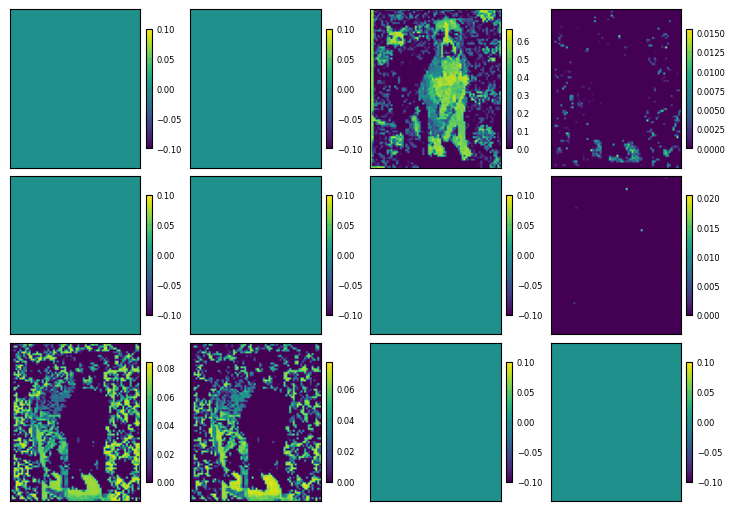

In [48]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


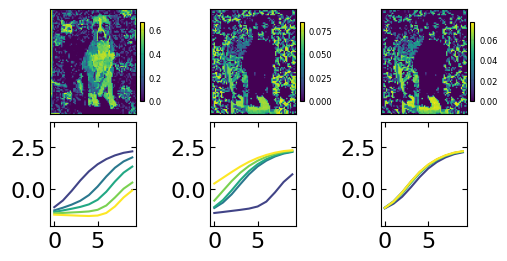

In [49]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False, indx=[2, 8, 9])


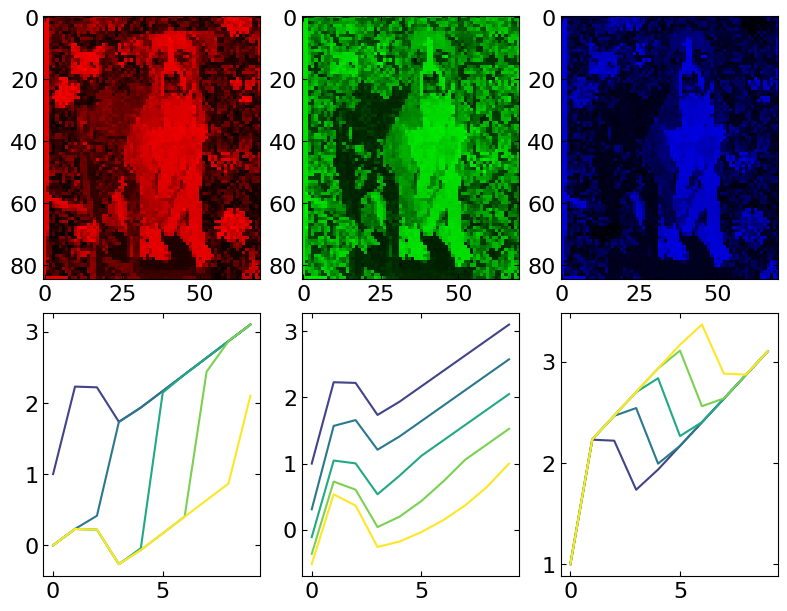

In [50]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [51]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)


c:\Users\jca92\.conda\envs\tutorials\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Beta Variational Autoencoder

- Constrict and sample the latent space from some prior distribution --> generally a gaussian distribution


### Normal Autoencoder

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE1.png?raw=true)


### VAE

- Encoder identifies some distribution --> generates from that distribution
  ![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE2.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE3.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE4.png?raw=true)


### Builds the Model


In [52]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        # extracts the mean and standard deviation
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(
            latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [53]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


### Training


In [54]:
# training with beta regularization scheduling

def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device=device,
    save=False,
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:
            # starts training with no VAE regularization
            beta = 0
        else:
            # adds VAE regularization
            beta = ((epoch - initial_epochs) //
                    epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if save:
            if (
                (epoch - initial_epochs) // epoch_per_beta
                == (epoch - initial_epochs) / epoch_per_beta
            ) and (epoch >= initial_epochs):

                best_train_loss = float("inf")

            if best_train_loss > train_loss:
                best_train_loss = train_loss
                patience_counter = 1
                checkpoint = {
                    "net": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "encoder": encoder.state_dict(),
                    "decoder": decoder.state_dict(),
                }
                if epoch >= 0:
                    torch.save(
                        checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                    )


In [55]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device=device,
)


Pytorch seed was set to 42
Numpy seed was set to 42


100%|██████████| 19/19 [00:01<00:00, 18.46it/s]


Epoch 0, Train Loss: 1.8868
.............................


100%|██████████| 19/19 [00:00<00:00, 23.93it/s]


Epoch 1, Train Loss: 1.8601
.............................


100%|██████████| 19/19 [00:00<00:00, 43.28it/s]


Epoch 2, Train Loss: 1.8369
.............................


100%|██████████| 19/19 [00:00<00:00, 38.55it/s]


Epoch 3, Train Loss: 1.8194
.............................


100%|██████████| 19/19 [00:00<00:00, 46.23it/s]


Epoch 4, Train Loss: 1.7971
.............................


100%|██████████| 19/19 [00:00<00:00, 43.61it/s]


Epoch 5, Train Loss: 1.7614
.............................


100%|██████████| 19/19 [00:00<00:00, 50.27it/s]


Epoch 6, Train Loss: 1.7277
.............................


100%|██████████| 19/19 [00:00<00:00, 46.77it/s]


Epoch 7, Train Loss: 1.6581
.............................


100%|██████████| 19/19 [00:00<00:00, 37.99it/s]


Epoch 8, Train Loss: 1.5673
.............................


100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch 9, Train Loss: 1.4347
.............................


100%|██████████| 19/19 [00:00<00:00, 45.96it/s]


Epoch 10, Train Loss: 1.2674
.............................


100%|██████████| 19/19 [00:00<00:00, 50.62it/s]


Epoch 11, Train Loss: 1.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 44.35it/s]


Epoch 12, Train Loss: 0.9595
.............................


100%|██████████| 19/19 [00:00<00:00, 35.20it/s]


Epoch 13, Train Loss: 0.8134
.............................


100%|██████████| 19/19 [00:00<00:00, 42.45it/s]


Epoch 14, Train Loss: 0.6702
.............................


100%|██████████| 19/19 [00:00<00:00, 54.99it/s]


Epoch 15, Train Loss: 0.5385
.............................


100%|██████████| 19/19 [00:00<00:00, 54.30it/s]


Epoch 16, Train Loss: 0.4226
.............................


100%|██████████| 19/19 [00:00<00:00, 56.71it/s]


Epoch 17, Train Loss: 0.3489
.............................


100%|██████████| 19/19 [00:00<00:00, 55.32it/s]


Epoch 18, Train Loss: 0.3002
.............................


100%|██████████| 19/19 [00:00<00:00, 54.77it/s]


Epoch 19, Train Loss: 0.2694
.............................


100%|██████████| 19/19 [00:00<00:00, 51.30it/s]


Epoch 20, Train Loss: 0.2484
.............................


100%|██████████| 19/19 [00:00<00:00, 44.32it/s]


Epoch 21, Train Loss: 0.2366
.............................


100%|██████████| 19/19 [00:00<00:00, 41.09it/s]


Epoch 22, Train Loss: 0.2302
.............................


100%|██████████| 19/19 [00:00<00:00, 48.64it/s]


Epoch 23, Train Loss: 0.2195
.............................


100%|██████████| 19/19 [00:00<00:00, 52.99it/s]


Epoch 24, Train Loss: 0.2134
.............................


100%|██████████| 19/19 [00:00<00:00, 50.36it/s]


Epoch 25, Train Loss: 0.2084
.............................


100%|██████████| 19/19 [00:00<00:00, 52.27it/s]


Epoch 26, Train Loss: 0.2034
.............................


100%|██████████| 19/19 [00:00<00:00, 63.00it/s]


Epoch 27, Train Loss: 0.1974
.............................


100%|██████████| 19/19 [00:00<00:00, 58.58it/s]


Epoch 28, Train Loss: 0.1946
.............................


100%|██████████| 19/19 [00:00<00:00, 60.93it/s]


Epoch 29, Train Loss: 0.1912
.............................


100%|██████████| 19/19 [00:00<00:00, 59.53it/s]


Epoch 30, Train Loss: 0.1883
.............................


100%|██████████| 19/19 [00:00<00:00, 58.22it/s]


Epoch 31, Train Loss: 0.1846
.............................


100%|██████████| 19/19 [00:00<00:00, 57.57it/s]


Epoch 32, Train Loss: 0.1818
.............................


100%|██████████| 19/19 [00:00<00:00, 57.09it/s]


Epoch 33, Train Loss: 0.1795
.............................


100%|██████████| 19/19 [00:00<00:00, 40.14it/s]


Epoch 34, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 41.35it/s]


Epoch 35, Train Loss: 0.1745
.............................


100%|██████████| 19/19 [00:00<00:00, 49.91it/s]


Epoch 36, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 54.29it/s]


Epoch 37, Train Loss: 0.1700
.............................


100%|██████████| 19/19 [00:00<00:00, 54.39it/s]


Epoch 38, Train Loss: 0.1682
.............................


100%|██████████| 19/19 [00:00<00:00, 51.95it/s]


Epoch 39, Train Loss: 0.1660
.............................


100%|██████████| 19/19 [00:00<00:00, 51.60it/s]


Epoch 40, Train Loss: 0.1636
.............................


100%|██████████| 19/19 [00:00<00:00, 61.29it/s]


Epoch 41, Train Loss: 0.1618
.............................


100%|██████████| 19/19 [00:00<00:00, 57.85it/s]


Epoch 42, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 48.67it/s]


Epoch 43, Train Loss: 0.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 43.65it/s]


Epoch 44, Train Loss: 0.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 47.86it/s]


Epoch 45, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 48.68it/s]


Epoch 46, Train Loss: 0.1523
.............................


100%|██████████| 19/19 [00:00<00:00, 45.47it/s]


Epoch 47, Train Loss: 0.1502
.............................


100%|██████████| 19/19 [00:00<00:00, 49.45it/s]


Epoch 48, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 49.52it/s]


Epoch 49, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 38.26it/s]


Epoch 50, Train Loss: 0.1448
.............................


100%|██████████| 19/19 [00:00<00:00, 41.27it/s]


Epoch 51, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 42.79it/s]


Epoch 52, Train Loss: 0.1410
.............................


100%|██████████| 19/19 [00:00<00:00, 57.67it/s]


Epoch 53, Train Loss: 0.1391
.............................


100%|██████████| 19/19 [00:00<00:00, 49.03it/s]


Epoch 54, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 52.80it/s]


Epoch 55, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 54.65it/s]


Epoch 56, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 52.72it/s]


Epoch 57, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 51.64it/s]


Epoch 58, Train Loss: 0.1316
.............................


100%|██████████| 19/19 [00:00<00:00, 49.17it/s]


Epoch 59, Train Loss: 0.1302
.............................


100%|██████████| 19/19 [00:00<00:00, 43.78it/s]


Epoch 60, Train Loss: 0.1289
.............................


100%|██████████| 19/19 [00:00<00:00, 52.79it/s]


Epoch 61, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 55.43it/s]


Epoch 62, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 56.36it/s]


Epoch 63, Train Loss: 0.1255
.............................


100%|██████████| 19/19 [00:00<00:00, 47.87it/s]


Epoch 64, Train Loss: 0.1247
.............................


100%|██████████| 19/19 [00:00<00:00, 47.25it/s]


Epoch 65, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 53.12it/s]


Epoch 66, Train Loss: 0.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 53.60it/s]


Epoch 67, Train Loss: 0.1214
.............................


100%|██████████| 19/19 [00:00<00:00, 54.72it/s]


Epoch 68, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 50.27it/s]


Epoch 69, Train Loss: 0.1196
.............................


100%|██████████| 19/19 [00:00<00:00, 50.72it/s]


Epoch 70, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 47.23it/s]


Epoch 71, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 42.34it/s]


Epoch 72, Train Loss: 0.1171
.............................


100%|██████████| 19/19 [00:00<00:00, 32.51it/s]


Epoch 73, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 36.37it/s]


Epoch 74, Train Loss: 0.1157
.............................


100%|██████████| 19/19 [00:00<00:00, 44.20it/s]


Epoch 75, Train Loss: 0.1146
.............................


100%|██████████| 19/19 [00:00<00:00, 33.78it/s]


Epoch 76, Train Loss: 0.1141
.............................


100%|██████████| 19/19 [00:00<00:00, 28.27it/s]


Epoch 77, Train Loss: 0.1135
.............................


100%|██████████| 19/19 [00:00<00:00, 35.14it/s]


Epoch 78, Train Loss: 0.1125
.............................


100%|██████████| 19/19 [00:00<00:00, 35.43it/s]


Epoch 79, Train Loss: 0.1119
.............................


100%|██████████| 19/19 [00:00<00:00, 41.14it/s]


Epoch 80, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 35.53it/s]


Epoch 81, Train Loss: 0.1106
.............................


100%|██████████| 19/19 [00:00<00:00, 38.23it/s]


Epoch 82, Train Loss: 0.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 40.18it/s]


Epoch 83, Train Loss: 0.1091
.............................


100%|██████████| 19/19 [00:00<00:00, 51.21it/s]


Epoch 84, Train Loss: 0.1085
.............................


100%|██████████| 19/19 [00:00<00:00, 49.21it/s]


Epoch 85, Train Loss: 0.1080
.............................


100%|██████████| 19/19 [00:00<00:00, 35.35it/s]


Epoch 86, Train Loss: 0.1072
.............................


100%|██████████| 19/19 [00:00<00:00, 32.58it/s]


Epoch 87, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 39.13it/s]


Epoch 88, Train Loss: 0.1059
.............................


100%|██████████| 19/19 [00:00<00:00, 46.14it/s]


Epoch 89, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 47.88it/s]


Epoch 90, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 50.35it/s]


Epoch 91, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 37.70it/s]


Epoch 92, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 40.88it/s]


Epoch 93, Train Loss: 0.1032
.............................


100%|██████████| 19/19 [00:00<00:00, 44.55it/s]


Epoch 94, Train Loss: 0.1026
.............................


100%|██████████| 19/19 [00:00<00:00, 50.36it/s]


Epoch 95, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 52.68it/s]


Epoch 96, Train Loss: 0.1016
.............................


100%|██████████| 19/19 [00:00<00:00, 47.98it/s]


Epoch 97, Train Loss: 0.1011
.............................


100%|██████████| 19/19 [00:00<00:00, 46.22it/s]


Epoch 98, Train Loss: 0.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 28.73it/s]


Epoch 99, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 31.01it/s]


Epoch 100, Train Loss: 0.0997
.............................


100%|██████████| 19/19 [00:00<00:00, 41.23it/s]


Epoch 101, Train Loss: 0.0993
.............................


100%|██████████| 19/19 [00:00<00:00, 38.98it/s]


Epoch 102, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 30.67it/s]


Epoch 103, Train Loss: 0.0983
.............................


100%|██████████| 19/19 [00:00<00:00, 41.98it/s]


Epoch 104, Train Loss: 0.0976
.............................


100%|██████████| 19/19 [00:00<00:00, 47.10it/s]


Epoch 105, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 52.67it/s]


Epoch 106, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 52.46it/s]


Epoch 107, Train Loss: 0.0960
.............................


100%|██████████| 19/19 [00:00<00:00, 47.98it/s]


Epoch 108, Train Loss: 0.0958
.............................


100%|██████████| 19/19 [00:00<00:00, 55.82it/s]


Epoch 109, Train Loss: 0.0949
.............................


100%|██████████| 19/19 [00:00<00:00, 60.20it/s]


Epoch 110, Train Loss: 0.0945
.............................


100%|██████████| 19/19 [00:00<00:00, 64.31it/s]


Epoch 111, Train Loss: 0.0937
.............................


100%|██████████| 19/19 [00:00<00:00, 58.38it/s]


Epoch 112, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 57.02it/s]


Epoch 113, Train Loss: 0.0924
.............................


100%|██████████| 19/19 [00:00<00:00, 56.78it/s]


Epoch 114, Train Loss: 0.0917
.............................


100%|██████████| 19/19 [00:00<00:00, 56.27it/s]


Epoch 115, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 47.74it/s]


Epoch 116, Train Loss: 0.0901
.............................


100%|██████████| 19/19 [00:00<00:00, 50.04it/s]


Epoch 117, Train Loss: 0.0892
.............................


100%|██████████| 19/19 [00:00<00:00, 46.88it/s]


Epoch 118, Train Loss: 0.0883
.............................


100%|██████████| 19/19 [00:00<00:00, 47.87it/s]


Epoch 119, Train Loss: 0.0872
.............................


100%|██████████| 19/19 [00:00<00:00, 40.26it/s]


Epoch 120, Train Loss: 0.0862
.............................


100%|██████████| 19/19 [00:00<00:00, 21.02it/s]


Epoch 121, Train Loss: 0.0849
.............................


100%|██████████| 19/19 [00:00<00:00, 32.46it/s]


Epoch 122, Train Loss: 0.0836
.............................


100%|██████████| 19/19 [00:00<00:00, 40.58it/s]


Epoch 123, Train Loss: 0.0821
.............................


100%|██████████| 19/19 [00:00<00:00, 32.26it/s]


Epoch 124, Train Loss: 0.0804
.............................


100%|██████████| 19/19 [00:00<00:00, 38.83it/s]


Epoch 125, Train Loss: 0.0786
.............................


100%|██████████| 19/19 [00:00<00:00, 37.82it/s]


Epoch 126, Train Loss: 0.0768
.............................


100%|██████████| 19/19 [00:00<00:00, 41.93it/s]


Epoch 127, Train Loss: 0.0744
.............................


100%|██████████| 19/19 [00:00<00:00, 52.78it/s]


Epoch 128, Train Loss: 0.0723
.............................


100%|██████████| 19/19 [00:00<00:00, 60.73it/s]


Epoch 129, Train Loss: 0.0704
.............................


100%|██████████| 19/19 [00:00<00:00, 47.06it/s]


Epoch 130, Train Loss: 0.0687
.............................


100%|██████████| 19/19 [00:00<00:00, 46.29it/s]


Epoch 131, Train Loss: 0.0670
.............................


100%|██████████| 19/19 [00:00<00:00, 59.07it/s]


Epoch 132, Train Loss: 0.0653
.............................


100%|██████████| 19/19 [00:00<00:00, 56.82it/s]


Epoch 133, Train Loss: 0.0638
.............................


100%|██████████| 19/19 [00:00<00:00, 57.35it/s]


Epoch 134, Train Loss: 0.0623
.............................


100%|██████████| 19/19 [00:00<00:00, 53.37it/s]


Epoch 135, Train Loss: 0.0611
.............................


100%|██████████| 19/19 [00:00<00:00, 54.13it/s]


Epoch 136, Train Loss: 0.0600
.............................


100%|██████████| 19/19 [00:00<00:00, 53.07it/s]


Epoch 137, Train Loss: 0.0588
.............................


100%|██████████| 19/19 [00:00<00:00, 48.12it/s]


Epoch 138, Train Loss: 0.0578
.............................


100%|██████████| 19/19 [00:00<00:00, 36.78it/s]


Epoch 139, Train Loss: 0.0569
.............................


100%|██████████| 19/19 [00:00<00:00, 46.92it/s]


Epoch 140, Train Loss: 0.0560
.............................


100%|██████████| 19/19 [00:00<00:00, 52.67it/s]


Epoch 141, Train Loss: 0.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 61.76it/s]


Epoch 142, Train Loss: 0.0541
.............................


100%|██████████| 19/19 [00:00<00:00, 54.08it/s]


Epoch 143, Train Loss: 0.0533
.............................


100%|██████████| 19/19 [00:00<00:00, 48.36it/s]


Epoch 144, Train Loss: 0.0526
.............................


100%|██████████| 19/19 [00:00<00:00, 56.25it/s]


Epoch 145, Train Loss: 0.0518
.............................


100%|██████████| 19/19 [00:00<00:00, 56.00it/s]


Epoch 146, Train Loss: 0.0512
.............................


100%|██████████| 19/19 [00:00<00:00, 54.10it/s]


Epoch 147, Train Loss: 0.0504
.............................


100%|██████████| 19/19 [00:00<00:00, 54.80it/s]


Epoch 148, Train Loss: 0.0497
.............................


100%|██████████| 19/19 [00:00<00:00, 50.53it/s]


Epoch 149, Train Loss: 0.0489
.............................


100%|██████████| 19/19 [00:00<00:00, 46.28it/s]


Epoch 150, Train Loss: 0.0482
.............................


100%|██████████| 19/19 [00:00<00:00, 39.31it/s]


Epoch 151, Train Loss: 0.0477
.............................


100%|██████████| 19/19 [00:00<00:00, 34.00it/s]


Epoch 152, Train Loss: 0.0471
.............................


100%|██████████| 19/19 [00:00<00:00, 48.57it/s]


Epoch 153, Train Loss: 0.0466
.............................


100%|██████████| 19/19 [00:00<00:00, 52.64it/s]


Epoch 154, Train Loss: 0.0461
.............................


100%|██████████| 19/19 [00:00<00:00, 60.36it/s]


Epoch 155, Train Loss: 0.0454
.............................


100%|██████████| 19/19 [00:00<00:00, 55.32it/s]


Epoch 156, Train Loss: 0.0450
.............................


100%|██████████| 19/19 [00:00<00:00, 49.63it/s]


Epoch 157, Train Loss: 0.0443
.............................


100%|██████████| 19/19 [00:00<00:00, 52.52it/s]


Epoch 158, Train Loss: 0.0438
.............................


100%|██████████| 19/19 [00:00<00:00, 56.27it/s]


Epoch 159, Train Loss: 0.0433
.............................


100%|██████████| 19/19 [00:00<00:00, 55.09it/s]


Epoch 160, Train Loss: 0.0428
.............................


100%|██████████| 19/19 [00:00<00:00, 58.85it/s]


Epoch 161, Train Loss: 0.0423
.............................


100%|██████████| 19/19 [00:00<00:00, 61.36it/s]


Epoch 162, Train Loss: 0.0419
.............................


100%|██████████| 19/19 [00:00<00:00, 60.82it/s]


Epoch 163, Train Loss: 0.0412
.............................


100%|██████████| 19/19 [00:00<00:00, 57.58it/s]


Epoch 164, Train Loss: 0.0408
.............................


100%|██████████| 19/19 [00:00<00:00, 53.86it/s]


Epoch 165, Train Loss: 0.0404
.............................


100%|██████████| 19/19 [00:00<00:00, 53.61it/s]


Epoch 166, Train Loss: 0.0400
.............................


100%|██████████| 19/19 [00:00<00:00, 56.79it/s]


Epoch 167, Train Loss: 0.0396
.............................


100%|██████████| 19/19 [00:00<00:00, 63.22it/s]


Epoch 168, Train Loss: 0.0392
.............................


100%|██████████| 19/19 [00:00<00:00, 60.56it/s]


Epoch 169, Train Loss: 0.0385
.............................


100%|██████████| 19/19 [00:00<00:00, 52.05it/s]


Epoch 170, Train Loss: 0.0380
.............................


100%|██████████| 19/19 [00:00<00:00, 56.85it/s]


Epoch 171, Train Loss: 0.0377
.............................


100%|██████████| 19/19 [00:00<00:00, 57.53it/s]


Epoch 172, Train Loss: 0.0371
.............................


100%|██████████| 19/19 [00:00<00:00, 70.47it/s]


Epoch 173, Train Loss: 0.0369
.............................


100%|██████████| 19/19 [00:00<00:00, 65.46it/s]


Epoch 174, Train Loss: 0.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 74.42it/s]


Epoch 175, Train Loss: 0.0360
.............................


100%|██████████| 19/19 [00:00<00:00, 64.36it/s]


Epoch 176, Train Loss: 0.0356
.............................


100%|██████████| 19/19 [00:00<00:00, 63.11it/s]


Epoch 177, Train Loss: 0.0351
.............................


100%|██████████| 19/19 [00:00<00:00, 67.57it/s]


Epoch 178, Train Loss: 0.0346
.............................


100%|██████████| 19/19 [00:00<00:00, 69.02it/s]


Epoch 179, Train Loss: 0.0343
.............................


100%|██████████| 19/19 [00:00<00:00, 52.95it/s]


Epoch 180, Train Loss: 0.0338
.............................


100%|██████████| 19/19 [00:00<00:00, 48.04it/s]


Epoch 181, Train Loss: 0.0335
.............................


100%|██████████| 19/19 [00:00<00:00, 53.08it/s]


Epoch 182, Train Loss: 0.0331
.............................


100%|██████████| 19/19 [00:00<00:00, 50.44it/s]


Epoch 183, Train Loss: 0.0326
.............................


100%|██████████| 19/19 [00:00<00:00, 59.61it/s]


Epoch 184, Train Loss: 0.0323
.............................


100%|██████████| 19/19 [00:00<00:00, 56.69it/s]


Epoch 185, Train Loss: 0.0317
.............................


100%|██████████| 19/19 [00:00<00:00, 55.41it/s]


Epoch 186, Train Loss: 0.0313
.............................


100%|██████████| 19/19 [00:00<00:00, 63.68it/s]


Epoch 187, Train Loss: 0.0310
.............................


100%|██████████| 19/19 [00:00<00:00, 65.98it/s]


Epoch 188, Train Loss: 0.0304
.............................


100%|██████████| 19/19 [00:00<00:00, 59.54it/s]


Epoch 189, Train Loss: 0.0299
.............................


100%|██████████| 19/19 [00:00<00:00, 66.57it/s]


Epoch 190, Train Loss: 0.0294
.............................


100%|██████████| 19/19 [00:00<00:00, 63.86it/s]


Epoch 191, Train Loss: 0.0288
.............................


100%|██████████| 19/19 [00:00<00:00, 62.00it/s]


Epoch 192, Train Loss: 0.0283
.............................


100%|██████████| 19/19 [00:00<00:00, 62.43it/s]


Epoch 193, Train Loss: 0.0277
.............................


100%|██████████| 19/19 [00:00<00:00, 59.70it/s]


Epoch 194, Train Loss: 0.0272
.............................


100%|██████████| 19/19 [00:00<00:00, 50.96it/s]


Epoch 195, Train Loss: 0.0269
.............................


100%|██████████| 19/19 [00:00<00:00, 47.79it/s]


Epoch 196, Train Loss: 0.0263
.............................


100%|██████████| 19/19 [00:00<00:00, 50.47it/s]


Epoch 197, Train Loss: 0.0259
.............................


100%|██████████| 19/19 [00:00<00:00, 56.71it/s]


Epoch 198, Train Loss: 0.0255
.............................


100%|██████████| 19/19 [00:00<00:00, 59.03it/s]


Epoch 199, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 57.91it/s]


Epoch 200, Train Loss: 2.6322
.............................


100%|██████████| 19/19 [00:00<00:00, 49.30it/s]


Epoch 201, Train Loss: 1.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 59.18it/s]


Epoch 202, Train Loss: 0.7742
.............................


100%|██████████| 19/19 [00:00<00:00, 61.48it/s]


Epoch 203, Train Loss: 0.6060
.............................


100%|██████████| 19/19 [00:00<00:00, 60.57it/s]


Epoch 204, Train Loss: 0.5094
.............................


100%|██████████| 19/19 [00:00<00:00, 55.11it/s]


Epoch 205, Train Loss: 0.4462
.............................


100%|██████████| 19/19 [00:00<00:00, 61.07it/s]


Epoch 206, Train Loss: 0.4063
.............................


100%|██████████| 19/19 [00:00<00:00, 59.69it/s]


Epoch 207, Train Loss: 0.3747
.............................


100%|██████████| 19/19 [00:00<00:00, 66.93it/s]


Epoch 208, Train Loss: 0.3496
.............................


100%|██████████| 19/19 [00:00<00:00, 64.62it/s]


Epoch 209, Train Loss: 0.3333
.............................


100%|██████████| 19/19 [00:00<00:00, 55.62it/s]


Epoch 210, Train Loss: 0.3203
.............................


100%|██████████| 19/19 [00:00<00:00, 51.88it/s]


Epoch 211, Train Loss: 0.3077
.............................


100%|██████████| 19/19 [00:00<00:00, 52.60it/s]


Epoch 212, Train Loss: 0.3000
.............................


100%|██████████| 19/19 [00:00<00:00, 52.71it/s]


Epoch 213, Train Loss: 0.2910
.............................


100%|██████████| 19/19 [00:00<00:00, 60.11it/s]


Epoch 214, Train Loss: 0.2819
.............................


100%|██████████| 19/19 [00:00<00:00, 53.95it/s]


Epoch 215, Train Loss: 0.2749
.............................


100%|██████████| 19/19 [00:00<00:00, 42.77it/s]


Epoch 216, Train Loss: 0.2684
.............................


100%|██████████| 19/19 [00:00<00:00, 55.55it/s]


Epoch 217, Train Loss: 0.2664
.............................


100%|██████████| 19/19 [00:00<00:00, 61.53it/s]


Epoch 218, Train Loss: 0.2622
.............................


100%|██████████| 19/19 [00:00<00:00, 59.00it/s]


Epoch 219, Train Loss: 0.2600
.............................


100%|██████████| 19/19 [00:00<00:00, 64.08it/s]


Epoch 220, Train Loss: 0.2551
.............................


100%|██████████| 19/19 [00:00<00:00, 68.81it/s]


Epoch 221, Train Loss: 0.2516
.............................


100%|██████████| 19/19 [00:00<00:00, 70.50it/s]


Epoch 222, Train Loss: 0.2482
.............................


100%|██████████| 19/19 [00:00<00:00, 68.24it/s]


Epoch 223, Train Loss: 0.2441
.............................


100%|██████████| 19/19 [00:00<00:00, 65.97it/s]


Epoch 224, Train Loss: 0.2412
.............................


100%|██████████| 19/19 [00:00<00:00, 59.84it/s]


Epoch 225, Train Loss: 0.2382
.............................


100%|██████████| 19/19 [00:00<00:00, 53.66it/s]


Epoch 226, Train Loss: 0.2361
.............................


100%|██████████| 19/19 [00:00<00:00, 59.04it/s]


Epoch 227, Train Loss: 0.2343
.............................


100%|██████████| 19/19 [00:00<00:00, 63.50it/s]


Epoch 228, Train Loss: 0.2323
.............................


100%|██████████| 19/19 [00:00<00:00, 62.35it/s]


Epoch 229, Train Loss: 0.2304
.............................


100%|██████████| 19/19 [00:00<00:00, 61.60it/s]


Epoch 230, Train Loss: 0.2305
.............................


100%|██████████| 19/19 [00:00<00:00, 70.53it/s]


Epoch 231, Train Loss: 0.2264
.............................


100%|██████████| 19/19 [00:00<00:00, 70.00it/s]


Epoch 232, Train Loss: 0.2256
.............................


100%|██████████| 19/19 [00:00<00:00, 69.78it/s]


Epoch 233, Train Loss: 0.2229
.............................


100%|██████████| 19/19 [00:00<00:00, 71.20it/s]


Epoch 234, Train Loss: 0.2220
.............................


100%|██████████| 19/19 [00:00<00:00, 68.67it/s]


Epoch 235, Train Loss: 0.2192
.............................


100%|██████████| 19/19 [00:00<00:00, 72.66it/s]


Epoch 236, Train Loss: 0.2173
.............................


100%|██████████| 19/19 [00:00<00:00, 69.72it/s]


Epoch 237, Train Loss: 0.2159
.............................


100%|██████████| 19/19 [00:00<00:00, 72.17it/s]


Epoch 238, Train Loss: 0.2162
.............................


100%|██████████| 19/19 [00:00<00:00, 72.69it/s]


Epoch 239, Train Loss: 0.2119
.............................


100%|██████████| 19/19 [00:00<00:00, 57.32it/s]


Epoch 240, Train Loss: 0.2105
.............................


100%|██████████| 19/19 [00:00<00:00, 60.04it/s]


Epoch 241, Train Loss: 0.2092
.............................


100%|██████████| 19/19 [00:00<00:00, 58.51it/s]


Epoch 242, Train Loss: 0.2083
.............................


100%|██████████| 19/19 [00:00<00:00, 55.10it/s]


Epoch 243, Train Loss: 0.2080
.............................


100%|██████████| 19/19 [00:00<00:00, 63.32it/s]


Epoch 244, Train Loss: 0.2048
.............................


100%|██████████| 19/19 [00:00<00:00, 66.84it/s]


Epoch 245, Train Loss: 0.2044
.............................


100%|██████████| 19/19 [00:00<00:00, 57.22it/s]


Epoch 246, Train Loss: 0.1998
.............................


100%|██████████| 19/19 [00:00<00:00, 48.80it/s]


Epoch 247, Train Loss: 0.1961
.............................


100%|██████████| 19/19 [00:00<00:00, 59.41it/s]


Epoch 248, Train Loss: 0.1948
.............................


100%|██████████| 19/19 [00:00<00:00, 57.63it/s]


Epoch 249, Train Loss: 0.1931
.............................


100%|██████████| 19/19 [00:00<00:00, 67.43it/s]


Epoch 250, Train Loss: 0.1918
.............................


100%|██████████| 19/19 [00:00<00:00, 74.95it/s]


Epoch 251, Train Loss: 0.1872
.............................


100%|██████████| 19/19 [00:00<00:00, 71.30it/s]


Epoch 252, Train Loss: 0.1866
.............................


100%|██████████| 19/19 [00:00<00:00, 76.22it/s]


Epoch 253, Train Loss: 0.1848
.............................


100%|██████████| 19/19 [00:00<00:00, 68.67it/s]


Epoch 254, Train Loss: 0.1814
.............................


100%|██████████| 19/19 [00:00<00:00, 67.08it/s]


Epoch 255, Train Loss: 0.1800
.............................


100%|██████████| 19/19 [00:00<00:00, 71.04it/s]


Epoch 256, Train Loss: 0.1773
.............................


100%|██████████| 19/19 [00:00<00:00, 61.71it/s]


Epoch 257, Train Loss: 0.1760
.............................


100%|██████████| 19/19 [00:00<00:00, 54.57it/s]


Epoch 258, Train Loss: 0.1761
.............................


100%|██████████| 19/19 [00:00<00:00, 52.52it/s]


Epoch 259, Train Loss: 0.1731
.............................


100%|██████████| 19/19 [00:00<00:00, 57.88it/s]


Epoch 260, Train Loss: 0.1726
.............................


100%|██████████| 19/19 [00:00<00:00, 59.91it/s]


Epoch 261, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 61.61it/s]


Epoch 262, Train Loss: 0.1688
.............................


100%|██████████| 19/19 [00:00<00:00, 49.95it/s]


Epoch 263, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 52.38it/s]


Epoch 264, Train Loss: 0.1662
.............................


100%|██████████| 19/19 [00:00<00:00, 60.88it/s]


Epoch 265, Train Loss: 0.1656
.............................


100%|██████████| 19/19 [00:00<00:00, 65.93it/s]


Epoch 266, Train Loss: 0.1650
.............................


100%|██████████| 19/19 [00:00<00:00, 64.40it/s]


Epoch 267, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 63.18it/s]


Epoch 268, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 66.33it/s]


Epoch 269, Train Loss: 0.1605
.............................


100%|██████████| 19/19 [00:00<00:00, 67.65it/s]


Epoch 270, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 68.38it/s]


Epoch 271, Train Loss: 0.1586
.............................


100%|██████████| 19/19 [00:00<00:00, 53.30it/s]


Epoch 272, Train Loss: 0.1577
.............................


100%|██████████| 19/19 [00:00<00:00, 55.47it/s]


Epoch 273, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 53.04it/s]


Epoch 274, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 57.14it/s]


Epoch 275, Train Loss: 0.1546
.............................


100%|██████████| 19/19 [00:00<00:00, 64.62it/s]


Epoch 276, Train Loss: 0.1519
.............................


100%|██████████| 19/19 [00:00<00:00, 65.17it/s]


Epoch 277, Train Loss: 0.1517
.............................


100%|██████████| 19/19 [00:00<00:00, 68.05it/s]


Epoch 278, Train Loss: 0.1516
.............................


100%|██████████| 19/19 [00:00<00:00, 57.19it/s]


Epoch 279, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 56.79it/s]


Epoch 280, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 57.68it/s]


Epoch 281, Train Loss: 0.1471
.............................


100%|██████████| 19/19 [00:00<00:00, 58.27it/s]


Epoch 282, Train Loss: 0.1471
.............................


100%|██████████| 19/19 [00:00<00:00, 59.66it/s]


Epoch 283, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 63.67it/s]


Epoch 284, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 57.35it/s]


Epoch 285, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 60.20it/s]


Epoch 286, Train Loss: 0.1437
.............................


100%|██████████| 19/19 [00:00<00:00, 59.84it/s]


Epoch 287, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 60.66it/s]


Epoch 288, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 52.68it/s]


Epoch 289, Train Loss: 0.1420
.............................


100%|██████████| 19/19 [00:00<00:00, 52.60it/s]


Epoch 290, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 59.16it/s]


Epoch 291, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 63.58it/s]


Epoch 292, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 64.49it/s]


Epoch 293, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 56.50it/s]


Epoch 294, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 59.99it/s]


Epoch 295, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 49.55it/s]


Epoch 296, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 61.14it/s]


Epoch 297, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 65.03it/s]


Epoch 298, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 63.11it/s]


Epoch 299, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 61.15it/s]


Epoch 300, Train Loss: 0.1889
.............................


100%|██████████| 19/19 [00:00<00:00, 64.83it/s]


Epoch 301, Train Loss: 0.1851
.............................


100%|██████████| 19/19 [00:00<00:00, 56.71it/s]


Epoch 302, Train Loss: 0.1802
.............................


100%|██████████| 19/19 [00:00<00:00, 42.19it/s]


Epoch 303, Train Loss: 0.1783
.............................


100%|██████████| 19/19 [00:00<00:00, 51.45it/s]


Epoch 304, Train Loss: 0.1761
.............................


100%|██████████| 19/19 [00:00<00:00, 44.25it/s]


Epoch 305, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 55.08it/s]


Epoch 306, Train Loss: 0.1758
.............................


100%|██████████| 19/19 [00:00<00:00, 56.41it/s]


Epoch 307, Train Loss: 0.1750
.............................


100%|██████████| 19/19 [00:00<00:00, 57.74it/s]


Epoch 308, Train Loss: 0.1740
.............................


100%|██████████| 19/19 [00:00<00:00, 54.79it/s]


Epoch 309, Train Loss: 0.1726
.............................


100%|██████████| 19/19 [00:00<00:00, 56.29it/s]


Epoch 310, Train Loss: 0.1718
.............................


100%|██████████| 19/19 [00:00<00:00, 56.44it/s]


Epoch 311, Train Loss: 0.1701
.............................


100%|██████████| 19/19 [00:00<00:00, 58.71it/s]


Epoch 312, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 62.70it/s]


Epoch 313, Train Loss: 0.1697
.............................


100%|██████████| 19/19 [00:00<00:00, 61.24it/s]


Epoch 314, Train Loss: 0.1684
.............................


100%|██████████| 19/19 [00:00<00:00, 63.32it/s]


Epoch 315, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 64.95it/s]


Epoch 316, Train Loss: 0.1662
.............................


100%|██████████| 19/19 [00:00<00:00, 62.78it/s]


Epoch 317, Train Loss: 0.1671
.............................


100%|██████████| 19/19 [00:00<00:00, 55.58it/s]


Epoch 318, Train Loss: 0.1658
.............................


100%|██████████| 19/19 [00:00<00:00, 55.25it/s]


Epoch 319, Train Loss: 0.1656
.............................


100%|██████████| 19/19 [00:00<00:00, 47.57it/s]


Epoch 320, Train Loss: 0.1645
.............................


100%|██████████| 19/19 [00:00<00:00, 52.03it/s]


Epoch 321, Train Loss: 0.1632
.............................


100%|██████████| 19/19 [00:00<00:00, 59.25it/s]


Epoch 322, Train Loss: 0.1640
.............................


100%|██████████| 19/19 [00:00<00:00, 53.23it/s]


Epoch 323, Train Loss: 0.1643
.............................


100%|██████████| 19/19 [00:00<00:00, 49.39it/s]


Epoch 324, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 57.06it/s]


Epoch 325, Train Loss: 0.1622
.............................


100%|██████████| 19/19 [00:00<00:00, 59.44it/s]


Epoch 326, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 59.39it/s]


Epoch 327, Train Loss: 0.1609
.............................


100%|██████████| 19/19 [00:00<00:00, 61.24it/s]


Epoch 328, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 60.22it/s]


Epoch 329, Train Loss: 0.1584
.............................


100%|██████████| 19/19 [00:00<00:00, 56.11it/s]


Epoch 330, Train Loss: 0.1570
.............................


100%|██████████| 19/19 [00:00<00:00, 60.88it/s]


Epoch 331, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 59.41it/s]


Epoch 332, Train Loss: 0.1589
.............................


100%|██████████| 19/19 [00:00<00:00, 57.10it/s]


Epoch 333, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 53.28it/s]


Epoch 334, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 61.19it/s]


Epoch 335, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 52.00it/s]


Epoch 336, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 44.70it/s]


Epoch 337, Train Loss: 0.1532
.............................


100%|██████████| 19/19 [00:00<00:00, 41.34it/s]


Epoch 338, Train Loss: 0.1512
.............................


100%|██████████| 19/19 [00:00<00:00, 39.05it/s]


Epoch 339, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 44.28it/s]


Epoch 340, Train Loss: 0.1517
.............................


100%|██████████| 19/19 [00:00<00:00, 42.23it/s]


Epoch 341, Train Loss: 0.1502
.............................


100%|██████████| 19/19 [00:00<00:00, 33.30it/s]


Epoch 342, Train Loss: 0.1515
.............................


100%|██████████| 19/19 [00:00<00:00, 50.89it/s]


Epoch 343, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 57.15it/s]


Epoch 344, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 55.36it/s]


Epoch 345, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 49.87it/s]


Epoch 346, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 56.27it/s]


Epoch 347, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 56.61it/s]


Epoch 348, Train Loss: 0.1464
.............................


100%|██████████| 19/19 [00:00<00:00, 51.42it/s]


Epoch 349, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 53.13it/s]


Epoch 350, Train Loss: 0.1442
.............................


100%|██████████| 19/19 [00:00<00:00, 57.63it/s]


Epoch 351, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 57.20it/s]


Epoch 352, Train Loss: 0.1443
.............................


100%|██████████| 19/19 [00:00<00:00, 61.08it/s]


Epoch 353, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 57.64it/s]


Epoch 354, Train Loss: 0.1424
.............................


100%|██████████| 19/19 [00:00<00:00, 51.06it/s]


Epoch 355, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 52.65it/s]


Epoch 356, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 46.15it/s]


Epoch 357, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 48.14it/s]


Epoch 358, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 41.77it/s]


Epoch 359, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 40.04it/s]


Epoch 360, Train Loss: 0.1393
.............................


100%|██████████| 19/19 [00:00<00:00, 50.66it/s]


Epoch 361, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 43.46it/s]


Epoch 362, Train Loss: 0.1380
.............................


100%|██████████| 19/19 [00:00<00:00, 45.20it/s]


Epoch 363, Train Loss: 0.1375
.............................


100%|██████████| 19/19 [00:00<00:00, 40.71it/s]


Epoch 364, Train Loss: 0.1375
.............................


100%|██████████| 19/19 [00:00<00:00, 51.17it/s]


Epoch 365, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 58.98it/s]


Epoch 366, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 57.07it/s]


Epoch 367, Train Loss: 0.1352
.............................


100%|██████████| 19/19 [00:00<00:00, 51.50it/s]


Epoch 368, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 52.88it/s]


Epoch 369, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 48.81it/s]


Epoch 370, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 47.36it/s]


Epoch 371, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 46.27it/s]


Epoch 372, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 43.02it/s]


Epoch 373, Train Loss: 0.1329
.............................


100%|██████████| 19/19 [00:00<00:00, 45.87it/s]


Epoch 374, Train Loss: 0.1301
.............................


100%|██████████| 19/19 [00:00<00:00, 41.80it/s]


Epoch 375, Train Loss: 0.1310
.............................


100%|██████████| 19/19 [00:00<00:00, 44.53it/s]


Epoch 376, Train Loss: 0.1290
.............................


100%|██████████| 19/19 [00:00<00:00, 49.11it/s]


Epoch 377, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 53.55it/s]


Epoch 378, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 60.95it/s]


Epoch 379, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 55.77it/s]


Epoch 380, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 48.46it/s]


Epoch 381, Train Loss: 0.1273
.............................


100%|██████████| 19/19 [00:00<00:00, 56.90it/s]


Epoch 382, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 54.67it/s]


Epoch 383, Train Loss: 0.1254
.............................


100%|██████████| 19/19 [00:00<00:00, 49.34it/s]


Epoch 384, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 47.33it/s]


Epoch 385, Train Loss: 0.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 53.22it/s]


Epoch 386, Train Loss: 0.1243
.............................


100%|██████████| 19/19 [00:00<00:00, 57.83it/s]


Epoch 387, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 56.52it/s]


Epoch 388, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 53.58it/s]


Epoch 389, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 49.39it/s]


Epoch 390, Train Loss: 0.1211
.............................


100%|██████████| 19/19 [00:00<00:00, 49.14it/s]


Epoch 391, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 51.34it/s]


Epoch 392, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 55.84it/s]


Epoch 393, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 53.37it/s]


Epoch 394, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:00<00:00, 49.77it/s]


Epoch 395, Train Loss: 0.1189
.............................


100%|██████████| 19/19 [00:00<00:00, 45.62it/s]


Epoch 396, Train Loss: 0.1182
.............................


100%|██████████| 19/19 [00:00<00:00, 27.84it/s]


Epoch 397, Train Loss: 0.1194
.............................


100%|██████████| 19/19 [00:00<00:00, 39.09it/s]


Epoch 398, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 49.43it/s]


Epoch 399, Train Loss: 0.1178
.............................


100%|██████████| 19/19 [00:00<00:00, 48.50it/s]


Epoch 400, Train Loss: 0.1453
.............................


100%|██████████| 19/19 [00:00<00:00, 40.53it/s]


Epoch 401, Train Loss: 0.1418
.............................


100%|██████████| 19/19 [00:00<00:00, 35.11it/s]


Epoch 402, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 46.24it/s]


Epoch 403, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 46.51it/s]


Epoch 404, Train Loss: 0.1398
.............................


100%|██████████| 19/19 [00:00<00:00, 45.64it/s]


Epoch 405, Train Loss: 0.1390
.............................


100%|██████████| 19/19 [00:00<00:00, 50.35it/s]


Epoch 406, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 45.25it/s]


Epoch 407, Train Loss: 0.1374
.............................


100%|██████████| 19/19 [00:00<00:00, 42.93it/s]


Epoch 408, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 32.69it/s]


Epoch 409, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 48.40it/s]


Epoch 410, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 52.63it/s]


Epoch 411, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 43.55it/s]


Epoch 412, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 41.01it/s]


Epoch 413, Train Loss: 0.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 44.26it/s]


Epoch 414, Train Loss: 0.1340
.............................


100%|██████████| 19/19 [00:00<00:00, 50.28it/s]


Epoch 415, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 49.05it/s]


Epoch 416, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 51.21it/s]


Epoch 417, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 55.22it/s]


Epoch 418, Train Loss: 0.1308
.............................


100%|██████████| 19/19 [00:00<00:00, 39.41it/s]


Epoch 419, Train Loss: 0.1303
.............................


100%|██████████| 19/19 [00:00<00:00, 40.03it/s]


Epoch 420, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 35.93it/s]


Epoch 421, Train Loss: 0.1294
.............................


100%|██████████| 19/19 [00:00<00:00, 49.13it/s]


Epoch 422, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 54.73it/s]


Epoch 423, Train Loss: 0.1284
.............................


100%|██████████| 19/19 [00:00<00:00, 52.85it/s]


Epoch 424, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 50.68it/s]


Epoch 425, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 52.74it/s]


Epoch 426, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 54.43it/s]


Epoch 427, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 55.55it/s]


Epoch 428, Train Loss: 0.1283
.............................


100%|██████████| 19/19 [00:00<00:00, 56.78it/s]


Epoch 429, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 56.44it/s]


Epoch 430, Train Loss: 0.1253
.............................


100%|██████████| 19/19 [00:00<00:00, 55.70it/s]


Epoch 431, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 50.85it/s]


Epoch 432, Train Loss: 0.1258
.............................


100%|██████████| 19/19 [00:00<00:00, 48.83it/s]


Epoch 433, Train Loss: 0.1272
.............................


100%|██████████| 19/19 [00:00<00:00, 49.24it/s]


Epoch 434, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 58.90it/s]


Epoch 435, Train Loss: 0.1248
.............................


100%|██████████| 19/19 [00:00<00:00, 55.24it/s]


Epoch 436, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 54.25it/s]


Epoch 437, Train Loss: 0.1249
.............................


100%|██████████| 19/19 [00:00<00:00, 53.36it/s]


Epoch 438, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 60.38it/s]


Epoch 439, Train Loss: 0.1226
.............................


100%|██████████| 19/19 [00:00<00:00, 49.32it/s]


Epoch 440, Train Loss: 0.1243
.............................


100%|██████████| 19/19 [00:00<00:00, 61.79it/s]


Epoch 441, Train Loss: 0.1234
.............................


100%|██████████| 19/19 [00:00<00:00, 60.23it/s]


Epoch 442, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 61.15it/s]


Epoch 443, Train Loss: 0.1218
.............................


100%|██████████| 19/19 [00:00<00:00, 63.35it/s]


Epoch 444, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 58.11it/s]


Epoch 445, Train Loss: 0.1222
.............................


100%|██████████| 19/19 [00:00<00:00, 54.78it/s]


Epoch 446, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 51.08it/s]


Epoch 447, Train Loss: 0.1207
.............................


100%|██████████| 19/19 [00:00<00:00, 46.94it/s]


Epoch 448, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 53.42it/s]


Epoch 449, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 42.74it/s]


Epoch 450, Train Loss: 0.1197
.............................


100%|██████████| 19/19 [00:00<00:00, 32.45it/s]


Epoch 451, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:01<00:00, 18.20it/s]


Epoch 452, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 21.05it/s]


Epoch 453, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 29.76it/s]


Epoch 454, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 43.14it/s]


Epoch 455, Train Loss: 0.1174
.............................


100%|██████████| 19/19 [00:00<00:00, 48.47it/s]


Epoch 456, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 52.01it/s]


Epoch 457, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 46.42it/s]


Epoch 458, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 61.78it/s]


Epoch 459, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 54.63it/s]


Epoch 460, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 59.68it/s]


Epoch 461, Train Loss: 0.1176
.............................


100%|██████████| 19/19 [00:00<00:00, 62.50it/s]


Epoch 462, Train Loss: 0.1178
.............................


100%|██████████| 19/19 [00:00<00:00, 62.66it/s]


Epoch 463, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 67.57it/s]


Epoch 464, Train Loss: 0.1172
.............................


100%|██████████| 19/19 [00:00<00:00, 68.27it/s]


Epoch 465, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 69.10it/s]


Epoch 466, Train Loss: 0.1157
.............................


100%|██████████| 19/19 [00:00<00:00, 61.60it/s]


Epoch 467, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 74.41it/s]


Epoch 468, Train Loss: 0.1163
.............................


100%|██████████| 19/19 [00:00<00:00, 68.44it/s]


Epoch 469, Train Loss: 0.1165
.............................


100%|██████████| 19/19 [00:00<00:00, 59.80it/s]


Epoch 470, Train Loss: 0.1167
.............................


100%|██████████| 19/19 [00:00<00:00, 48.90it/s]


Epoch 471, Train Loss: 0.1170
.............................


100%|██████████| 19/19 [00:00<00:00, 50.72it/s]


Epoch 472, Train Loss: 0.1149
.............................


100%|██████████| 19/19 [00:00<00:00, 51.31it/s]


Epoch 473, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 55.81it/s]


Epoch 474, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 51.75it/s]


Epoch 475, Train Loss: 0.1158
.............................


100%|██████████| 19/19 [00:00<00:00, 49.55it/s]


Epoch 476, Train Loss: 0.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 58.14it/s]


Epoch 477, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 61.73it/s]


Epoch 478, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 64.14it/s]


Epoch 479, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 71.00it/s]


Epoch 480, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 62.45it/s]


Epoch 481, Train Loss: 0.1151
.............................


100%|██████████| 19/19 [00:00<00:00, 67.80it/s]


Epoch 482, Train Loss: 0.1133
.............................


100%|██████████| 19/19 [00:00<00:00, 58.18it/s]


Epoch 483, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 61.32it/s]


Epoch 484, Train Loss: 0.1144
.............................


100%|██████████| 19/19 [00:00<00:00, 52.16it/s]


Epoch 485, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 44.91it/s]


Epoch 486, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 47.60it/s]


Epoch 487, Train Loss: 0.1149
.............................


100%|██████████| 19/19 [00:00<00:00, 48.11it/s]


Epoch 488, Train Loss: 0.1129
.............................


100%|██████████| 19/19 [00:00<00:00, 54.09it/s]


Epoch 489, Train Loss: 0.1128
.............................


100%|██████████| 19/19 [00:00<00:00, 45.62it/s]


Epoch 490, Train Loss: 0.1124
.............................


100%|██████████| 19/19 [00:00<00:00, 53.26it/s]


Epoch 491, Train Loss: 0.1123
.............................


100%|██████████| 19/19 [00:00<00:00, 57.80it/s]


Epoch 492, Train Loss: 0.1129
.............................


100%|██████████| 19/19 [00:00<00:00, 62.82it/s]


Epoch 493, Train Loss: 0.1128
.............................


100%|██████████| 19/19 [00:00<00:00, 62.97it/s]


Epoch 494, Train Loss: 0.1122
.............................


100%|██████████| 19/19 [00:00<00:00, 64.79it/s]


Epoch 495, Train Loss: 0.1129
.............................


100%|██████████| 19/19 [00:00<00:00, 65.84it/s]


Epoch 496, Train Loss: 0.1124
.............................


100%|██████████| 19/19 [00:00<00:00, 68.91it/s]


Epoch 497, Train Loss: 0.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 65.91it/s]


Epoch 498, Train Loss: 0.1108
.............................


100%|██████████| 19/19 [00:00<00:00, 49.67it/s]

Epoch 499, Train Loss: 0.1119
.............................


### Validation


In [56]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)


In [57]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()


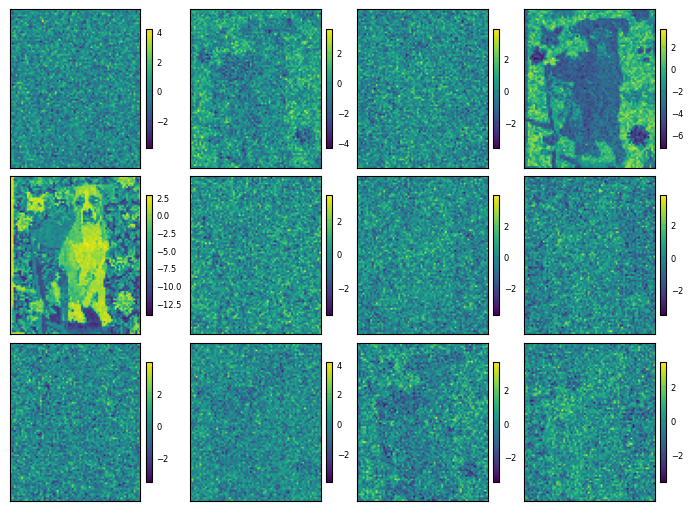

In [58]:
embeddings(encoded_spectra, shape_=image.shape[0:2], figsize=(15, 5))


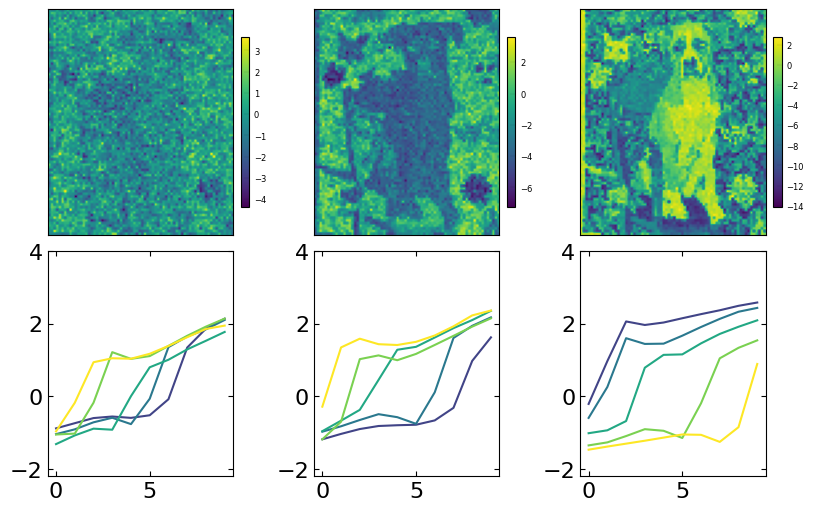

In [59]:
latent_generator(decoder, encoded_spectra, image, 5, 10,
                 device=device, figsize=(15, 5), divider_=False, indx=[1, 3, 4])


- disentanglement with $\beta$ VAE requires careful control of optimiztion.
